# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import gc
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = './Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = './eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = './semantic_graphs_output/graph_semantic.pkl'
    NODE_MAPPING_PATH: str = './semantic_graphs_output/node_mapping_semantic.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    ARTICLE_RERANKER_MODEL: str = 'Qwen/Qwen3-Reranker-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    TOP_K_IMAGES_FAISS: int = 20

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="bfs",
    hops=1,
    max_candidates=200,
    topk_per_node=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])

    if not seed_idxs:
        return []

    if mode == "bfs" or graph_weights is None:
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue
            for nbr in graph_adj.get(node, []):
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_topk":
        score = defaultdict(float)
        for s in seed_idxs:
            nbrs = graph_weights.get(s, {})
            for nbr, w in nbrs.items():
                if nbr in seed_idxs:
                    continue
                score[nbr] += float(w)

        ranked = sorted(score.items(), key=lambda x: x[1], reverse=True)
        selected = [idx for idx, _ in ranked][:max_candidates]

        result = []
        for idx in seed_idxs:
            if idx not in result:
                result.append(idx_to_aid[idx])
        for idx in selected:
            aid = idx_to_aid.get(idx)
            if aid is None:
                continue
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_hops":
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue

            nbr_w = graph_weights.get(node, None)
            if nbr_w:
                nbr_candidates = sorted(nbr_w.items(), key=lambda x: x[1], reverse=True)
                nbr_candidates = [n for n, _ in nbr_candidates[:topk_per_node]]
            else:
                nbr_candidates = list(graph_adj.get(node, []))

            for nbr in nbr_candidates:
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    return expand_candidates_via_graph(seed_article_ids, graph_adj, aid_to_idx, idx_to_aid,
                                       graph_weights=None, mode="bfs", hops=hops, max_candidates=max_candidates)



# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def load_qwen3_reranker():
    tok = AutoTokenizer.from_pretrained(config.ARTICLE_RERANKER_MODEL, trust_remote_code=True, padding_side='left')
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        config.ARTICLE_RERANKER_MODEL,
        torch_dtype=torch.float16 if config.DEVICE=='cuda' else torch.float32,
        trust_remote_code=True
    ).to(config.DEVICE)
    model.eval()
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".\n<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
    pre = tok.encode(prefix, add_special_tokens=False)
    suf = tok.encode(suffix, add_special_tokens=False)
    yes_id = tok.convert_tokens_to_ids("yes") or tok.convert_tokens_to_ids("Yes")
    no_id  = tok.convert_tokens_to_ids("no")  or tok.convert_tokens_to_ids("No")
    return tok, model, pre, suf, yes_id, no_id

reranker_tokenizer, reranker_model, prefix_tokens, suffix_tokens, yes_id, no_id = load_qwen3_reranker()

def format_instruction(query, doc):
    return f"<Instruct>: Determine relevance\n<Query>: {query}\n<Document>: {doc}"

def process_inputs(pairs):
    toks = reranker_tokenizer(pairs, add_special_tokens=False, padding=False, truncation='longest_first')
    for i, ids in enumerate(toks['input_ids']):
        toks['input_ids'][i] = prefix_tokens + ids + suffix_tokens
    toks = reranker_tokenizer.pad(
        {"input_ids": toks['input_ids']},
        padding=True, return_tensors="pt",
        max_length=config.MAX_RERANKER_LENGTH
    )
    return {k: v.to(config.DEVICE) for k, v in toks.items()}

@torch.no_grad()
def compute_yes_scores(inputs):
    logits = reranker_model(**inputs).logits[:, -1, :]
    pair = torch.stack([logits[:, no_id], logits[:, yes_id]], dim=1)
    probs = torch.nn.functional.log_softmax(pair, dim=1)
    return probs[:,1].exp().cpu().tolist()

def rerank_articles(query, article_ids, batch_size=4):
    pairs = []
    for aid in article_ids:
        art = database[aid]
        title = art.get("title", "")[:200]
        content = art.get("content", "")[:config.MAX_DOC_CHARS]
        doc = f"Title: {title}\nContent: {content}"
        pairs.append(format_instruction(query, doc))
    scores = []
    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i:i+batch_size]
        inp = process_inputs(batch_pairs)
        s = compute_yes_scores(inp)
        scores.extend(s)
        torch.cuda.empty_cache()
    ranked = sorted(zip(article_ids, scores), key=lambda x: x[1], reverse=True)
    return [a for a,_ in ranked[:config.TOP_K_ARTICLES_RERANK]]

## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE)
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(config.GRAPH_PATH, config.NODE_MAPPING_PATH)

edges = []
weights = []
with open(config.GRAPH_PATH, 'rb') as f:
    graw = pickle.load(f)

for u, v, w in graw["edge_list"]:
    edges.append((int(u), int(v)))
    weights.append(float(w))

g_ig = ig.Graph(n=len(idx_to_aid), edges=edges)

plt.hist(weights, bins=50)
plt.title("Semantic Graph Edge Weight Distribution")
plt.savefig("graph_edge_weight_distribution.png", dpi=150)
plt.close()

num_components = len(g_ig.components())
largest_comp = g_ig.components().giant()
avg_path = largest_comp.average_path_length()

print("Graph Connectivity (igraph):")
print("Components:", num_components)
print("Avg shortest path (largest component):", avg_path)


Graph Connectivity (igraph):
Components: 78070
Avg shortest path (largest component): 16.134888841731446


# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for c in candidates:
    exp = expand_candidates_via_graph(
        c,
        graph_adj,
        aid_to_idx,
        idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode=config.GRAPH_EXPANSION_MODE,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )
    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.81s/it]

100%|██████████| 1/1 [00:04<00:00,  4.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 1/1 [02:01<00:00, 121.94s/it]

100%|██████████| 1/1 [02:01<00:00, 121.94s/it]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:09<03:25,  9.79s/it]

  9%|▉         | 2/22 [00:12<01:47,  5.37s/it]

 14%|█▎        | 3/22 [00:18<01:52,  5.94s/it]

 18%|█▊        | 4/22 [00:19<01:12,  4.03s/it]

 23%|██▎       | 5/22 [00:21<00:52,  3.09s/it]

 27%|██▋       | 6/22 [00:50<03:10, 11.91s/it]

 32%|███▏      | 7/22 [01:07<03:22, 13.50s/it]

 36%|███▋      | 8/22 [01:30<03:53, 16.68s/it]

 41%|████      | 9/22 [01:32<02:35, 11.96s/it]

 45%|████▌     | 10/22 [01:32<01:42,  8.55s/it]

 50%|█████     | 11/22 [01:42<01:35,  8.70s/it]

 55%|█████▍    | 12/22 [01:44<01:08,  6.83s/it]

 59%|█████▉    | 13/22 [01:50<00:58,  6.46s/it]

 64%|██████▎   | 14/22 [01:53<00:42,  5.36s/it]

 68%|██████▊   | 15/22 [02:23<01:31, 13.05s/it]

 73%|███████▎  | 16/22 [02:26<00:59,  9.90s/it]

 77%|███████▋  | 17/22 [02:29<00:39,  7.89s/it]

 82%|████████▏ | 18/22 [02:30<00:23,  5.91s/it]

 86%|████████▋ | 19/22 [02:32<00:13,  4.62s/it]

 91%|█████████ | 20/22 [02:33<00:07,  3.57s/it]

 95%|█████████▌| 21/22 [02:38<00:03,  3.94s/it]

100%|██████████| 22/22 [02:40<00:00,  3.27s/it]

100%|██████████| 22/22 [02:40<00:00,  7.28s/it]


Article Retrieval Metrics:
mAP: 0.5736
MRR: 0.5736
Recall@1: 0.4545
Recall@5: 0.7273
Recall@10: 0.7727
Recall@20: 0.8182
Recall@50: 0.8182

Image Retrieval Metrics:
mAP: 0.4057
MRR: 0.4057
Recall@1: 0.2727
Recall@5: 0.5909
Recall@10: 0.7273
Recall@20: 0.7273
Recall@50: 0.7273


# VISUALIZATION

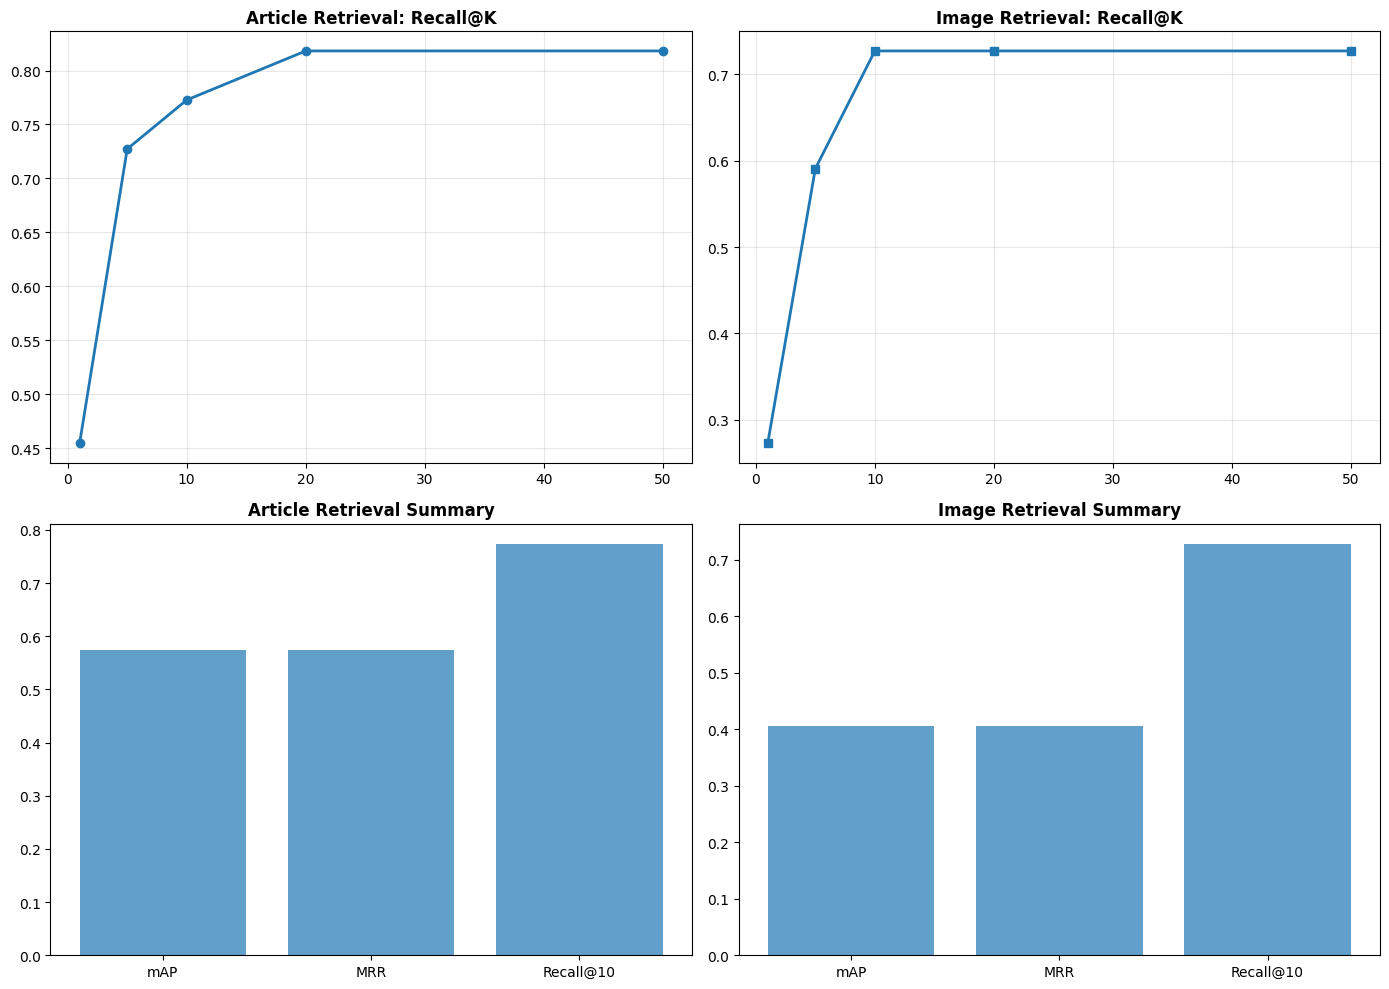

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:18,  2.46it/s]

  4%|▍         | 2/47 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/47 [00:01<00:18,  2.41it/s]

  9%|▊         | 4/47 [00:01<00:18,  2.35it/s]

 11%|█         | 5/47 [00:02<00:17,  2.45it/s]

 13%|█▎        | 6/47 [00:02<00:17,  2.38it/s]

 15%|█▍        | 7/47 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/47 [00:03<00:15,  2.56it/s]

 19%|█▉        | 9/47 [00:03<00:14,  2.58it/s]

 21%|██▏       | 10/47 [00:04<00:15,  2.46it/s]

 23%|██▎       | 11/47 [00:04<00:14,  2.49it/s]

 26%|██▌       | 12/47 [00:04<00:14,  2.49it/s]

 28%|██▊       | 13/47 [00:05<00:13,  2.46it/s]

 30%|██▉       | 14/47 [00:05<00:12,  2.54it/s]

 32%|███▏      | 15/47 [00:05<00:12,  2.60it/s]

 34%|███▍      | 16/47 [00:06<00:11,  2.69it/s]

 36%|███▌      | 17/47 [00:06<00:11,  2.65it/s]

 38%|███▊      | 18/47 [00:07<00:10,  2.64it/s]

 40%|████      | 19/47 [00:07<00:10,  2.57it/s]

 43%|████▎     | 20/47 [00:07<00:10,  2.58it/s]

 45%|████▍     | 21/47 [00:08<00:10,  2.52it/s]

 47%|████▋     | 22/47 [00:08<00:09,  2.53it/s]

 49%|████▉     | 23/47 [00:09<00:11,  2.02it/s]

 51%|█████     | 24/47 [00:10<00:11,  1.92it/s]

 53%|█████▎    | 25/47 [00:10<00:11,  1.98it/s]

 55%|█████▌    | 26/47 [00:11<00:10,  1.97it/s]

 57%|█████▋    | 27/47 [00:11<00:09,  2.10it/s]

 60%|█████▉    | 28/47 [00:11<00:08,  2.20it/s]

 62%|██████▏   | 29/47 [00:12<00:07,  2.27it/s]

 64%|██████▍   | 30/47 [00:12<00:07,  2.27it/s]

 66%|██████▌   | 31/47 [00:13<00:06,  2.40it/s]

 68%|██████▊   | 32/47 [00:13<00:05,  2.60it/s]

 70%|███████   | 33/47 [00:13<00:05,  2.62it/s]

 72%|███████▏  | 34/47 [00:14<00:04,  2.68it/s]

 74%|███████▍  | 35/47 [00:14<00:04,  2.78it/s]

 77%|███████▋  | 36/47 [00:14<00:04,  2.68it/s]

 79%|███████▊  | 37/47 [00:15<00:03,  2.57it/s]

 81%|████████  | 38/47 [00:15<00:03,  2.47it/s]

 83%|████████▎ | 39/47 [00:16<00:03,  2.39it/s]

 85%|████████▌ | 40/47 [00:16<00:03,  2.26it/s]

 87%|████████▋ | 41/47 [00:17<00:02,  2.28it/s]

 89%|████████▉ | 42/47 [00:17<00:02,  2.22it/s]

 91%|█████████▏| 43/47 [00:17<00:01,  2.23it/s]

 94%|█████████▎| 44/47 [00:18<00:01,  1.75it/s]

 96%|█████████▌| 45/47 [00:19<00:01,  1.71it/s]

 98%|█████████▊| 46/47 [00:19<00:00,  1.80it/s]

100%|██████████| 47/47 [00:20<00:00,  1.85it/s]

100%|██████████| 47/47 [00:20<00:00,  2.30it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [05:42<4:22:35, 342.51s/it]

  4%|▍         | 2/47 [11:20<4:15:01, 340.03s/it]

  6%|▋         | 3/47 [16:53<4:06:58, 336.77s/it]

  9%|▊         | 4/47 [22:42<4:04:46, 341.54s/it]

 11%|█         | 5/47 [28:18<3:57:41, 339.57s/it]

 13%|█▎        | 6/47 [33:47<3:49:35, 335.98s/it]

 15%|█▍        | 7/47 [39:22<3:43:47, 335.68s/it]

 17%|█▋        | 8/47 [44:53<3:37:12, 334.16s/it]

 19%|█▉        | 9/47 [50:34<3:33:03, 336.40s/it]

 21%|██▏       | 10/47 [56:19<3:29:04, 339.05s/it]

 23%|██▎       | 11/47 [1:02:07<3:24:57, 341.60s/it]

 26%|██▌       | 12/47 [1:07:50<3:19:29, 342.00s/it]

 28%|██▊       | 13/47 [1:13:34<3:14:11, 342.68s/it]

 30%|██▉       | 14/47 [1:19:13<3:07:50, 341.54s/it]

 32%|███▏      | 15/47 [1:24:55<3:02:11, 341.59s/it]

 34%|███▍      | 16/47 [1:30:36<2:56:23, 341.40s/it]

 36%|███▌      | 17/47 [1:37:21<3:00:17, 360.57s/it]

 38%|███▊      | 18/47 [1:43:40<2:56:58, 366.15s/it]

 40%|████      | 19/47 [1:49:17<2:46:45, 357.35s/it]

 43%|████▎     | 20/47 [1:54:57<2:38:27, 352.14s/it]

 45%|████▍     | 21/47 [2:00:32<2:30:27, 347.22s/it]

 47%|████▋     | 22/47 [2:06:14<2:23:59, 345.56s/it]

 49%|████▉     | 23/47 [2:11:47<2:16:39, 341.63s/it]

 51%|█████     | 24/47 [2:17:28<2:10:56, 341.60s/it]

 53%|█████▎    | 25/47 [2:22:53<2:03:23, 336.50s/it]

 55%|█████▌    | 26/47 [2:28:24<1:57:15, 335.00s/it]

 57%|█████▋    | 27/47 [2:34:02<1:51:55, 335.77s/it]

 60%|█████▉    | 28/47 [2:39:37<1:46:14, 335.53s/it]

 62%|██████▏   | 29/47 [2:45:04<1:39:55, 333.11s/it]

 64%|██████▍   | 30/47 [2:50:35<1:34:13, 332.55s/it]

 66%|██████▌   | 31/47 [2:56:06<1:28:30, 331.88s/it]

 68%|██████▊   | 32/47 [3:01:40<1:23:08, 332.54s/it]

 70%|███████   | 33/47 [3:07:09<1:17:22, 331.62s/it]

 72%|███████▏  | 34/47 [3:12:44<1:12:01, 332.39s/it]

 74%|███████▍  | 35/47 [3:18:23<1:06:53, 334.44s/it]

 77%|███████▋  | 36/47 [3:23:57<1:01:19, 334.50s/it]

 79%|███████▊  | 37/47 [3:29:35<55:53, 335.36s/it]  

 81%|████████  | 38/47 [3:35:10<50:18, 335.39s/it]

 83%|████████▎ | 39/47 [3:40:52<44:58, 337.28s/it]

 85%|████████▌ | 40/47 [3:46:37<39:36, 339.56s/it]

 87%|████████▋ | 41/47 [3:52:06<33:39, 336.53s/it]

 89%|████████▉ | 42/47 [3:57:49<28:12, 338.49s/it]

 91%|█████████▏| 43/47 [4:03:30<22:36, 339.20s/it]

 94%|█████████▎| 44/47 [4:09:13<17:01, 340.41s/it]

 96%|█████████▌| 45/47 [4:14:54<11:20, 340.44s/it]

 98%|█████████▊| 46/47 [4:20:33<05:40, 340.10s/it]

100%|██████████| 47/47 [4:25:48<00:00, 332.66s/it]

100%|██████████| 47/47 [4:25:48<00:00, 339.34s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:18<15:03:04, 18.07s/it]

  0%|          | 2/3000 [00:34<14:20:55, 17.23s/it]

  0%|          | 3/3000 [00:41<10:17:45, 12.37s/it]

  0%|          | 4/3000 [00:51<9:42:14, 11.66s/it] 

  0%|          | 5/3000 [01:02<9:31:30, 11.45s/it]

  0%|          | 6/3000 [01:13<9:15:36, 11.13s/it]

  0%|          | 7/3000 [01:23<8:53:01, 10.69s/it]

  0%|          | 8/3000 [01:40<10:40:36, 12.85s/it]

  0%|          | 9/3000 [01:48<9:19:00, 11.21s/it] 

  0%|          | 10/3000 [01:58<9:08:46, 11.01s/it]

  0%|          | 11/3000 [02:02<7:21:43,  8.87s/it]

  0%|          | 12/3000 [02:06<6:05:04,  7.33s/it]

  0%|          | 13/3000 [02:21<7:55:41,  9.56s/it]

  0%|          | 14/3000 [02:26<6:54:56,  8.34s/it]

  0%|          | 15/3000 [02:40<8:12:30,  9.90s/it]

  1%|          | 16/3000 [02:51<8:36:43, 10.39s/it]

  1%|          | 17/3000 [02:55<6:52:54,  8.31s/it]

  1%|          | 18/3000 [03:04<6:58:42,  8.42s/it]

  1%|          | 19/3000 [03:09<6:06:24,  7.37s/it]

  1%|          | 20/3000 [03:12<5:12:24,  6.29s/it]

  1%|          | 21/3000 [03:18<5:05:03,  6.14s/it]

  1%|          | 22/3000 [03:23<4:44:35,  5.73s/it]

  1%|          | 23/3000 [03:32<5:42:09,  6.90s/it]

  1%|          | 24/3000 [03:36<4:45:17,  5.75s/it]

  1%|          | 25/3000 [03:41<4:37:52,  5.60s/it]

  1%|          | 26/3000 [03:45<4:22:34,  5.30s/it]

  1%|          | 27/3000 [03:49<4:03:51,  4.92s/it]

  1%|          | 28/3000 [03:52<3:27:27,  4.19s/it]

  1%|          | 29/3000 [03:53<2:45:00,  3.33s/it]

  1%|          | 30/3000 [03:57<2:52:17,  3.48s/it]

  1%|          | 31/3000 [04:00<2:38:10,  3.20s/it]

  1%|          | 32/3000 [04:09<4:05:49,  4.97s/it]

  1%|          | 33/3000 [04:15<4:25:10,  5.36s/it]

  1%|          | 34/3000 [04:22<4:51:06,  5.89s/it]

  1%|          | 35/3000 [04:26<4:19:21,  5.25s/it]

  1%|          | 36/3000 [04:30<4:03:57,  4.94s/it]

  1%|          | 37/3000 [04:32<3:12:43,  3.90s/it]

  1%|▏         | 38/3000 [04:33<2:41:16,  3.27s/it]

  1%|▏         | 39/3000 [04:37<2:47:07,  3.39s/it]

  1%|▏         | 40/3000 [04:40<2:35:16,  3.15s/it]

  1%|▏         | 41/3000 [04:43<2:38:20,  3.21s/it]

  1%|▏         | 42/3000 [04:44<2:06:19,  2.56s/it]

  1%|▏         | 43/3000 [04:47<2:06:50,  2.57s/it]

  1%|▏         | 44/3000 [04:50<2:12:55,  2.70s/it]

  2%|▏         | 45/3000 [04:54<2:34:07,  3.13s/it]

  2%|▏         | 46/3000 [04:58<2:55:11,  3.56s/it]

  2%|▏         | 47/3000 [05:02<2:49:54,  3.45s/it]

  2%|▏         | 48/3000 [05:04<2:37:34,  3.20s/it]

  2%|▏         | 49/3000 [05:05<2:09:11,  2.63s/it]

  2%|▏         | 50/3000 [05:08<2:05:45,  2.56s/it]

  2%|▏         | 51/3000 [05:16<3:25:24,  4.18s/it]

  2%|▏         | 52/3000 [05:21<3:39:17,  4.46s/it]

  2%|▏         | 53/3000 [05:26<3:50:09,  4.69s/it]

  2%|▏         | 54/3000 [05:34<4:41:34,  5.73s/it]

  2%|▏         | 55/3000 [05:37<4:02:43,  4.95s/it]

  2%|▏         | 56/3000 [05:41<3:45:53,  4.60s/it]

  2%|▏         | 57/3000 [05:44<3:19:42,  4.07s/it]

  2%|▏         | 58/3000 [05:48<3:11:51,  3.91s/it]

  2%|▏         | 59/3000 [05:49<2:28:51,  3.04s/it]

  2%|▏         | 60/3000 [05:53<2:45:54,  3.39s/it]

  2%|▏         | 61/3000 [05:54<2:20:30,  2.87s/it]

  2%|▏         | 62/3000 [06:02<3:34:19,  4.38s/it]

  2%|▏         | 63/3000 [06:06<3:18:37,  4.06s/it]

  2%|▏         | 64/3000 [06:11<3:43:57,  4.58s/it]

  2%|▏         | 65/3000 [06:16<3:46:59,  4.64s/it]

  2%|▏         | 66/3000 [06:20<3:34:49,  4.39s/it]

  2%|▏         | 67/3000 [06:24<3:30:30,  4.31s/it]

  2%|▏         | 68/3000 [06:30<3:48:41,  4.68s/it]

  2%|▏         | 69/3000 [06:34<3:45:46,  4.62s/it]

  2%|▏         | 70/3000 [06:37<3:26:26,  4.23s/it]

  2%|▏         | 71/3000 [06:43<3:37:56,  4.46s/it]

  2%|▏         | 72/3000 [06:45<3:08:30,  3.86s/it]

  2%|▏         | 73/3000 [06:49<3:17:13,  4.04s/it]

  2%|▏         | 74/3000 [06:55<3:40:05,  4.51s/it]

  2%|▎         | 75/3000 [07:05<4:54:07,  6.03s/it]

  3%|▎         | 76/3000 [07:08<4:13:09,  5.19s/it]

  3%|▎         | 77/3000 [07:13<4:07:32,  5.08s/it]

  3%|▎         | 78/3000 [07:17<3:53:32,  4.80s/it]

  3%|▎         | 79/3000 [07:21<3:49:46,  4.72s/it]

  3%|▎         | 80/3000 [07:29<4:33:31,  5.62s/it]

  3%|▎         | 81/3000 [07:34<4:30:18,  5.56s/it]

  3%|▎         | 82/3000 [07:37<3:42:44,  4.58s/it]

  3%|▎         | 83/3000 [07:40<3:24:46,  4.21s/it]

  3%|▎         | 84/3000 [07:43<3:07:44,  3.86s/it]

  3%|▎         | 85/3000 [07:46<2:54:57,  3.60s/it]

  3%|▎         | 86/3000 [07:48<2:33:11,  3.15s/it]

  3%|▎         | 87/3000 [07:54<3:03:18,  3.78s/it]

  3%|▎         | 88/3000 [08:00<3:41:33,  4.57s/it]

  3%|▎         | 89/3000 [08:05<3:54:13,  4.83s/it]

  3%|▎         | 90/3000 [08:11<4:06:14,  5.08s/it]

  3%|▎         | 91/3000 [08:14<3:39:07,  4.52s/it]

  3%|▎         | 92/3000 [08:18<3:27:22,  4.28s/it]

  3%|▎         | 93/3000 [08:21<3:15:05,  4.03s/it]

  3%|▎         | 94/3000 [08:23<2:40:38,  3.32s/it]

  3%|▎         | 95/3000 [08:25<2:21:24,  2.92s/it]

  3%|▎         | 96/3000 [08:27<2:01:51,  2.52s/it]

  3%|▎         | 97/3000 [08:29<1:56:09,  2.40s/it]

  3%|▎         | 98/3000 [08:31<1:48:29,  2.24s/it]

  3%|▎         | 99/3000 [08:33<1:55:31,  2.39s/it]

  3%|▎         | 100/3000 [08:35<1:39:34,  2.06s/it]

  3%|▎         | 101/3000 [08:41<2:42:10,  3.36s/it]

  3%|▎         | 102/3000 [08:44<2:42:09,  3.36s/it]

  3%|▎         | 103/3000 [08:49<2:54:39,  3.62s/it]

  3%|▎         | 104/3000 [08:58<4:16:32,  5.32s/it]

  4%|▎         | 105/3000 [08:58<3:07:41,  3.89s/it]

  4%|▎         | 106/3000 [09:04<3:27:10,  4.30s/it]

  4%|▎         | 107/3000 [09:05<2:47:31,  3.47s/it]

  4%|▎         | 108/3000 [09:14<4:09:45,  5.18s/it]

  4%|▎         | 109/3000 [09:22<4:39:11,  5.79s/it]

  4%|▎         | 110/3000 [09:27<4:26:41,  5.54s/it]

  4%|▎         | 111/3000 [09:31<4:15:48,  5.31s/it]

  4%|▎         | 112/3000 [09:34<3:35:05,  4.47s/it]

  4%|▍         | 113/3000 [09:36<2:56:55,  3.68s/it]

  4%|▍         | 114/3000 [09:45<4:14:32,  5.29s/it]

  4%|▍         | 115/3000 [09:51<4:32:16,  5.66s/it]

  4%|▍         | 116/3000 [09:55<4:07:31,  5.15s/it]

  4%|▍         | 117/3000 [10:00<3:54:41,  4.88s/it]

  4%|▍         | 118/3000 [10:02<3:24:59,  4.27s/it]

  4%|▍         | 119/3000 [10:06<3:13:49,  4.04s/it]

  4%|▍         | 120/3000 [10:09<2:56:24,  3.68s/it]

  4%|▍         | 121/3000 [10:17<3:59:29,  4.99s/it]

  4%|▍         | 122/3000 [10:23<4:16:32,  5.35s/it]

  4%|▍         | 123/3000 [10:27<3:54:14,  4.89s/it]

  4%|▍         | 124/3000 [10:32<3:53:40,  4.88s/it]

  4%|▍         | 125/3000 [10:34<3:16:40,  4.10s/it]

  4%|▍         | 126/3000 [10:37<3:08:11,  3.93s/it]

  4%|▍         | 127/3000 [10:44<3:49:17,  4.79s/it]

  4%|▍         | 128/3000 [10:54<4:56:18,  6.19s/it]

  4%|▍         | 129/3000 [11:00<5:00:22,  6.28s/it]

  4%|▍         | 130/3000 [11:06<4:59:53,  6.27s/it]

  4%|▍         | 131/3000 [11:11<4:36:45,  5.79s/it]

  4%|▍         | 132/3000 [11:20<5:22:46,  6.75s/it]

  4%|▍         | 133/3000 [11:27<5:20:05,  6.70s/it]

  4%|▍         | 134/3000 [11:34<5:29:10,  6.89s/it]

  4%|▍         | 135/3000 [11:37<4:33:28,  5.73s/it]

  5%|▍         | 136/3000 [11:46<5:13:41,  6.57s/it]

  5%|▍         | 137/3000 [11:51<5:00:37,  6.30s/it]

  5%|▍         | 138/3000 [11:55<4:24:05,  5.54s/it]

  5%|▍         | 139/3000 [11:58<3:42:33,  4.67s/it]

  5%|▍         | 140/3000 [12:00<3:13:00,  4.05s/it]

  5%|▍         | 141/3000 [12:02<2:38:10,  3.32s/it]

  5%|▍         | 142/3000 [12:03<2:14:53,  2.83s/it]

  5%|▍         | 143/3000 [12:06<2:09:47,  2.73s/it]

  5%|▍         | 144/3000 [12:12<2:55:39,  3.69s/it]

  5%|▍         | 145/3000 [12:15<2:46:21,  3.50s/it]

  5%|▍         | 146/3000 [12:16<2:14:16,  2.82s/it]

  5%|▍         | 147/3000 [12:17<1:50:53,  2.33s/it]

  5%|▍         | 148/3000 [12:19<1:34:08,  1.98s/it]

  5%|▍         | 149/3000 [12:22<1:52:27,  2.37s/it]

  5%|▌         | 150/3000 [12:24<1:42:47,  2.16s/it]

  5%|▌         | 151/3000 [12:26<1:52:04,  2.36s/it]

  5%|▌         | 152/3000 [12:34<3:10:30,  4.01s/it]

  5%|▌         | 153/3000 [12:43<4:20:52,  5.50s/it]

  5%|▌         | 154/3000 [12:55<5:50:07,  7.38s/it]

  5%|▌         | 155/3000 [13:00<5:23:47,  6.83s/it]

  5%|▌         | 156/3000 [13:07<5:23:44,  6.83s/it]

  5%|▌         | 157/3000 [13:10<4:27:14,  5.64s/it]

  5%|▌         | 158/3000 [13:15<4:20:32,  5.50s/it]

  5%|▌         | 159/3000 [13:18<3:35:17,  4.55s/it]

  5%|▌         | 160/3000 [13:20<3:09:00,  3.99s/it]

  5%|▌         | 161/3000 [13:25<3:24:28,  4.32s/it]

  5%|▌         | 162/3000 [13:30<3:22:27,  4.28s/it]

  5%|▌         | 163/3000 [13:34<3:28:20,  4.41s/it]

  5%|▌         | 164/3000 [13:37<2:58:28,  3.78s/it]

  6%|▌         | 165/3000 [13:39<2:39:20,  3.37s/it]

  6%|▌         | 166/3000 [13:41<2:14:01,  2.84s/it]

  6%|▌         | 167/3000 [13:44<2:17:30,  2.91s/it]

  6%|▌         | 168/3000 [13:48<2:35:40,  3.30s/it]

  6%|▌         | 169/3000 [13:50<2:14:40,  2.85s/it]

  6%|▌         | 170/3000 [13:51<1:54:37,  2.43s/it]

  6%|▌         | 171/3000 [13:55<2:10:59,  2.78s/it]

  6%|▌         | 172/3000 [13:56<1:48:14,  2.30s/it]

  6%|▌         | 173/3000 [14:02<2:35:38,  3.30s/it]

  6%|▌         | 174/3000 [14:08<3:12:02,  4.08s/it]

  6%|▌         | 175/3000 [14:10<2:55:03,  3.72s/it]

  6%|▌         | 176/3000 [14:14<2:52:54,  3.67s/it]

  6%|▌         | 177/3000 [14:17<2:39:34,  3.39s/it]

  6%|▌         | 178/3000 [14:21<2:53:12,  3.68s/it]

  6%|▌         | 179/3000 [14:24<2:45:57,  3.53s/it]

  6%|▌         | 180/3000 [14:28<2:46:13,  3.54s/it]

  6%|▌         | 181/3000 [14:32<2:54:49,  3.72s/it]

  6%|▌         | 182/3000 [14:36<2:57:24,  3.78s/it]

  6%|▌         | 183/3000 [14:40<3:08:30,  4.02s/it]

  6%|▌         | 184/3000 [14:46<3:35:21,  4.59s/it]

  6%|▌         | 185/3000 [14:49<3:06:13,  3.97s/it]

  6%|▌         | 186/3000 [14:54<3:17:14,  4.21s/it]

  6%|▌         | 187/3000 [14:56<2:58:14,  3.80s/it]

  6%|▋         | 188/3000 [15:02<3:16:53,  4.20s/it]

  6%|▋         | 189/3000 [15:06<3:25:28,  4.39s/it]

  6%|▋         | 190/3000 [15:09<2:58:34,  3.81s/it]

  6%|▋         | 191/3000 [15:11<2:33:40,  3.28s/it]

  6%|▋         | 192/3000 [15:15<2:41:07,  3.44s/it]

  6%|▋         | 193/3000 [15:24<4:06:42,  5.27s/it]

  6%|▋         | 194/3000 [15:27<3:30:20,  4.50s/it]

  6%|▋         | 195/3000 [15:36<4:27:33,  5.72s/it]

  7%|▋         | 196/3000 [15:39<3:57:23,  5.08s/it]

  7%|▋         | 197/3000 [15:44<3:56:16,  5.06s/it]

  7%|▋         | 198/3000 [15:47<3:31:23,  4.53s/it]

  7%|▋         | 199/3000 [15:52<3:37:04,  4.65s/it]

  7%|▋         | 200/3000 [15:55<3:13:35,  4.15s/it]

  7%|▋         | 201/3000 [15:59<3:04:54,  3.96s/it]

  7%|▋         | 202/3000 [16:03<3:00:16,  3.87s/it]

  7%|▋         | 203/3000 [16:07<3:02:50,  3.92s/it]

  7%|▋         | 204/3000 [16:10<2:57:11,  3.80s/it]

  7%|▋         | 205/3000 [16:13<2:45:07,  3.54s/it]

  7%|▋         | 206/3000 [16:20<3:32:52,  4.57s/it]

  7%|▋         | 207/3000 [16:27<4:05:37,  5.28s/it]

  7%|▋         | 208/3000 [16:29<3:23:39,  4.38s/it]

  7%|▋         | 209/3000 [16:40<4:50:16,  6.24s/it]

  7%|▋         | 210/3000 [16:48<5:23:30,  6.96s/it]

  7%|▋         | 211/3000 [16:57<5:41:42,  7.35s/it]

  7%|▋         | 212/3000 [17:01<5:04:15,  6.55s/it]

  7%|▋         | 213/3000 [17:05<4:19:22,  5.58s/it]

  7%|▋         | 214/3000 [17:11<4:28:53,  5.79s/it]

  7%|▋         | 215/3000 [17:15<4:00:14,  5.18s/it]

  7%|▋         | 216/3000 [17:18<3:37:48,  4.69s/it]

  7%|▋         | 217/3000 [17:22<3:30:08,  4.53s/it]

  7%|▋         | 218/3000 [17:26<3:14:32,  4.20s/it]

  7%|▋         | 219/3000 [17:30<3:15:16,  4.21s/it]

  7%|▋         | 220/3000 [17:35<3:30:12,  4.54s/it]

  7%|▋         | 221/3000 [17:44<4:32:42,  5.89s/it]

  7%|▋         | 222/3000 [17:49<4:08:18,  5.36s/it]

  7%|▋         | 223/3000 [17:53<3:53:28,  5.04s/it]

  7%|▋         | 224/3000 [17:57<3:46:27,  4.89s/it]

  8%|▊         | 225/3000 [18:00<3:11:20,  4.14s/it]

  8%|▊         | 226/3000 [18:07<3:54:30,  5.07s/it]

  8%|▊         | 227/3000 [18:13<4:02:35,  5.25s/it]

  8%|▊         | 228/3000 [18:17<3:44:06,  4.85s/it]

  8%|▊         | 229/3000 [18:20<3:24:55,  4.44s/it]

  8%|▊         | 230/3000 [18:24<3:21:18,  4.36s/it]

  8%|▊         | 231/3000 [18:26<2:41:38,  3.50s/it]

  8%|▊         | 232/3000 [18:31<3:09:46,  4.11s/it]

  8%|▊         | 233/3000 [18:34<2:51:45,  3.72s/it]

  8%|▊         | 234/3000 [18:39<3:09:51,  4.12s/it]

  8%|▊         | 235/3000 [18:45<3:26:44,  4.49s/it]

  8%|▊         | 236/3000 [18:48<3:07:26,  4.07s/it]

  8%|▊         | 237/3000 [18:49<2:34:55,  3.36s/it]

  8%|▊         | 238/3000 [19:01<4:29:49,  5.86s/it]

  8%|▊         | 239/3000 [19:04<3:49:15,  4.98s/it]

  8%|▊         | 240/3000 [19:11<4:18:51,  5.63s/it]

  8%|▊         | 241/3000 [19:45<10:46:35, 14.06s/it]

  8%|▊         | 242/3000 [19:50<8:48:42, 11.50s/it] 

  8%|▊         | 243/3000 [19:54<6:57:46,  9.09s/it]

  8%|▊         | 244/3000 [20:01<6:32:09,  8.54s/it]

  8%|▊         | 245/3000 [20:04<5:14:12,  6.84s/it]

  8%|▊         | 246/3000 [20:07<4:23:45,  5.75s/it]

  8%|▊         | 247/3000 [20:11<4:02:55,  5.29s/it]

  8%|▊         | 248/3000 [20:15<3:41:53,  4.84s/it]

  8%|▊         | 249/3000 [20:22<4:15:17,  5.57s/it]

  8%|▊         | 250/3000 [20:25<3:38:09,  4.76s/it]

  8%|▊         | 251/3000 [20:31<3:55:02,  5.13s/it]

  8%|▊         | 252/3000 [20:33<3:01:53,  3.97s/it]

  8%|▊         | 253/3000 [20:36<2:55:02,  3.82s/it]

  8%|▊         | 254/3000 [20:41<3:10:22,  4.16s/it]

  8%|▊         | 255/3000 [20:45<3:06:28,  4.08s/it]

  9%|▊         | 256/3000 [20:49<3:10:07,  4.16s/it]

  9%|▊         | 257/3000 [20:50<2:26:45,  3.21s/it]

  9%|▊         | 258/3000 [20:55<2:51:51,  3.76s/it]

  9%|▊         | 259/3000 [20:58<2:37:15,  3.44s/it]

  9%|▊         | 260/3000 [21:02<2:38:40,  3.47s/it]

  9%|▊         | 261/3000 [21:05<2:35:08,  3.40s/it]

  9%|▊         | 262/3000 [21:08<2:31:34,  3.32s/it]

  9%|▉         | 263/3000 [21:11<2:25:17,  3.19s/it]

  9%|▉         | 264/3000 [21:14<2:25:00,  3.18s/it]

  9%|▉         | 265/3000 [21:19<2:55:10,  3.84s/it]

  9%|▉         | 266/3000 [21:27<3:48:12,  5.01s/it]

  9%|▉         | 267/3000 [21:30<3:15:35,  4.29s/it]

  9%|▉         | 268/3000 [21:42<4:59:45,  6.58s/it]

  9%|▉         | 269/3000 [21:46<4:33:32,  6.01s/it]

  9%|▉         | 270/3000 [21:49<3:50:58,  5.08s/it]

  9%|▉         | 271/3000 [21:53<3:36:22,  4.76s/it]

  9%|▉         | 272/3000 [22:00<4:06:22,  5.42s/it]

  9%|▉         | 273/3000 [22:05<3:57:55,  5.23s/it]

  9%|▉         | 274/3000 [22:10<3:53:34,  5.14s/it]

  9%|▉         | 275/3000 [22:13<3:29:03,  4.60s/it]

  9%|▉         | 276/3000 [22:16<3:06:00,  4.10s/it]

  9%|▉         | 277/3000 [22:19<2:43:13,  3.60s/it]

  9%|▉         | 278/3000 [22:24<3:02:25,  4.02s/it]

  9%|▉         | 279/3000 [22:33<4:16:35,  5.66s/it]

  9%|▉         | 280/3000 [22:36<3:40:26,  4.86s/it]

  9%|▉         | 281/3000 [22:42<3:54:59,  5.19s/it]

  9%|▉         | 282/3000 [22:44<3:10:57,  4.22s/it]

  9%|▉         | 283/3000 [22:47<2:59:48,  3.97s/it]

  9%|▉         | 284/3000 [22:49<2:32:46,  3.37s/it]

 10%|▉         | 285/3000 [22:52<2:20:24,  3.10s/it]

 10%|▉         | 286/3000 [22:55<2:24:08,  3.19s/it]

 10%|▉         | 287/3000 [22:58<2:23:08,  3.17s/it]

 10%|▉         | 288/3000 [23:01<2:17:00,  3.03s/it]

 10%|▉         | 289/3000 [23:04<2:21:51,  3.14s/it]

 10%|▉         | 290/3000 [23:09<2:36:31,  3.47s/it]

 10%|▉         | 291/3000 [23:13<2:48:43,  3.74s/it]

 10%|▉         | 292/3000 [23:24<4:32:44,  6.04s/it]

 10%|▉         | 293/3000 [23:29<4:13:20,  5.62s/it]

 10%|▉         | 294/3000 [23:34<4:06:48,  5.47s/it]

 10%|▉         | 295/3000 [23:40<4:08:15,  5.51s/it]

 10%|▉         | 296/3000 [23:47<4:32:06,  6.04s/it]

 10%|▉         | 297/3000 [23:55<5:04:12,  6.75s/it]

 10%|▉         | 298/3000 [24:02<5:06:52,  6.81s/it]

 10%|▉         | 299/3000 [24:07<4:33:13,  6.07s/it]

 10%|█         | 300/3000 [24:13<4:35:04,  6.11s/it]

 10%|█         | 301/3000 [24:19<4:36:46,  6.15s/it]

 10%|█         | 302/3000 [24:22<3:55:34,  5.24s/it]

 10%|█         | 303/3000 [24:25<3:22:50,  4.51s/it]

 10%|█         | 304/3000 [24:28<2:56:04,  3.92s/it]

 10%|█         | 305/3000 [24:30<2:36:28,  3.48s/it]

 10%|█         | 306/3000 [24:34<2:41:48,  3.60s/it]

 10%|█         | 307/3000 [24:38<2:50:03,  3.79s/it]

 10%|█         | 308/3000 [24:45<3:29:25,  4.67s/it]

 10%|█         | 309/3000 [24:48<3:03:44,  4.10s/it]

 10%|█         | 310/3000 [24:50<2:45:18,  3.69s/it]

 10%|█         | 311/3000 [25:00<3:58:47,  5.33s/it]

 10%|█         | 312/3000 [25:08<4:33:16,  6.10s/it]

 10%|█         | 313/3000 [25:15<4:56:12,  6.61s/it]

 10%|█         | 314/3000 [25:27<5:57:53,  7.99s/it]

 10%|█         | 315/3000 [25:34<5:52:47,  7.88s/it]

 11%|█         | 316/3000 [25:50<7:34:25, 10.16s/it]

 11%|█         | 317/3000 [25:54<6:13:34,  8.35s/it]

 11%|█         | 318/3000 [25:56<4:51:57,  6.53s/it]

 11%|█         | 319/3000 [26:03<4:52:06,  6.54s/it]

 11%|█         | 320/3000 [26:05<3:58:34,  5.34s/it]

 11%|█         | 321/3000 [26:09<3:31:55,  4.75s/it]

 11%|█         | 322/3000 [26:13<3:26:10,  4.62s/it]

 11%|█         | 323/3000 [26:16<3:12:31,  4.32s/it]

 11%|█         | 324/3000 [26:24<3:53:57,  5.25s/it]

 11%|█         | 325/3000 [26:27<3:19:51,  4.48s/it]

 11%|█         | 326/3000 [26:29<2:49:09,  3.80s/it]

 11%|█         | 327/3000 [26:33<2:57:33,  3.99s/it]

 11%|█         | 328/3000 [26:38<3:09:13,  4.25s/it]

 11%|█         | 329/3000 [26:44<3:32:16,  4.77s/it]

 11%|█         | 330/3000 [26:46<2:59:46,  4.04s/it]

 11%|█         | 331/3000 [26:49<2:44:15,  3.69s/it]

 11%|█         | 332/3000 [26:51<2:21:31,  3.18s/it]

 11%|█         | 333/3000 [26:54<2:11:31,  2.96s/it]

 11%|█         | 334/3000 [26:56<2:03:05,  2.77s/it]

 11%|█         | 335/3000 [27:02<2:49:34,  3.82s/it]

 11%|█         | 336/3000 [27:06<2:49:44,  3.82s/it]

 11%|█         | 337/3000 [27:11<3:01:19,  4.09s/it]

 11%|█▏        | 338/3000 [27:14<2:50:55,  3.85s/it]

 11%|█▏        | 339/3000 [27:16<2:27:15,  3.32s/it]

 11%|█▏        | 340/3000 [27:22<2:57:21,  4.00s/it]

 11%|█▏        | 341/3000 [27:27<3:10:35,  4.30s/it]

 11%|█▏        | 342/3000 [27:31<3:14:25,  4.39s/it]

 11%|█▏        | 343/3000 [27:35<3:05:46,  4.20s/it]

 11%|█▏        | 344/3000 [27:38<2:46:24,  3.76s/it]

 12%|█▏        | 345/3000 [27:40<2:22:01,  3.21s/it]

 12%|█▏        | 346/3000 [27:46<3:05:06,  4.18s/it]

 12%|█▏        | 347/3000 [27:49<2:39:16,  3.60s/it]

 12%|█▏        | 348/3000 [27:53<2:49:50,  3.84s/it]

 12%|█▏        | 349/3000 [28:00<3:29:23,  4.74s/it]

 12%|█▏        | 350/3000 [28:02<2:52:56,  3.92s/it]

 12%|█▏        | 351/3000 [28:07<3:07:58,  4.26s/it]

 12%|█▏        | 352/3000 [28:09<2:39:13,  3.61s/it]

 12%|█▏        | 353/3000 [28:15<3:11:29,  4.34s/it]

 12%|█▏        | 354/3000 [28:17<2:44:21,  3.73s/it]

 12%|█▏        | 355/3000 [28:22<2:52:12,  3.91s/it]

 12%|█▏        | 356/3000 [28:26<3:02:02,  4.13s/it]

 12%|█▏        | 357/3000 [28:31<3:12:35,  4.37s/it]

 12%|█▏        | 358/3000 [28:33<2:42:37,  3.69s/it]

 12%|█▏        | 359/3000 [28:37<2:45:50,  3.77s/it]

 12%|█▏        | 360/3000 [28:43<3:17:02,  4.48s/it]

 12%|█▏        | 361/3000 [28:47<3:11:35,  4.36s/it]

 12%|█▏        | 362/3000 [28:54<3:40:29,  5.01s/it]

 12%|█▏        | 363/3000 [28:56<3:02:09,  4.14s/it]

 12%|█▏        | 364/3000 [28:57<2:22:56,  3.25s/it]

 12%|█▏        | 365/3000 [28:58<1:56:12,  2.65s/it]

 12%|█▏        | 366/3000 [29:02<2:04:25,  2.83s/it]

 12%|█▏        | 367/3000 [29:04<1:50:24,  2.52s/it]

 12%|█▏        | 368/3000 [29:08<2:14:28,  3.07s/it]

 12%|█▏        | 369/3000 [29:11<2:10:57,  2.99s/it]

 12%|█▏        | 370/3000 [29:15<2:29:39,  3.41s/it]

 12%|█▏        | 371/3000 [29:18<2:24:59,  3.31s/it]

 12%|█▏        | 372/3000 [29:21<2:16:45,  3.12s/it]

 12%|█▏        | 373/3000 [29:24<2:14:15,  3.07s/it]

 12%|█▏        | 374/3000 [29:28<2:24:41,  3.31s/it]

 12%|█▎        | 375/3000 [29:31<2:19:50,  3.20s/it]

 13%|█▎        | 376/3000 [29:33<2:10:02,  2.97s/it]

 13%|█▎        | 377/3000 [29:36<2:09:45,  2.97s/it]

 13%|█▎        | 378/3000 [29:39<2:09:50,  2.97s/it]

 13%|█▎        | 379/3000 [29:41<2:02:16,  2.80s/it]

 13%|█▎        | 380/3000 [29:44<2:01:53,  2.79s/it]

 13%|█▎        | 381/3000 [29:49<2:29:26,  3.42s/it]

 13%|█▎        | 382/3000 [29:56<3:21:19,  4.61s/it]

 13%|█▎        | 383/3000 [29:59<2:54:47,  4.01s/it]

 13%|█▎        | 384/3000 [30:02<2:40:15,  3.68s/it]

 13%|█▎        | 385/3000 [30:05<2:36:23,  3.59s/it]

 13%|█▎        | 386/3000 [30:08<2:21:00,  3.24s/it]

 13%|█▎        | 387/3000 [30:12<2:31:38,  3.48s/it]

 13%|█▎        | 388/3000 [30:17<2:55:22,  4.03s/it]

 13%|█▎        | 389/3000 [30:21<2:55:05,  4.02s/it]

 13%|█▎        | 390/3000 [30:23<2:32:04,  3.50s/it]

 13%|█▎        | 391/3000 [30:26<2:26:18,  3.36s/it]

 13%|█▎        | 392/3000 [30:29<2:10:08,  2.99s/it]

 13%|█▎        | 393/3000 [30:33<2:25:04,  3.34s/it]

 13%|█▎        | 394/3000 [30:36<2:27:43,  3.40s/it]

 13%|█▎        | 395/3000 [30:39<2:21:49,  3.27s/it]

 13%|█▎        | 396/3000 [30:41<1:57:02,  2.70s/it]

 13%|█▎        | 397/3000 [30:42<1:43:46,  2.39s/it]

 13%|█▎        | 398/3000 [30:44<1:29:16,  2.06s/it]

 13%|█▎        | 399/3000 [30:47<1:46:20,  2.45s/it]

 13%|█▎        | 400/3000 [30:49<1:41:10,  2.33s/it]

 13%|█▎        | 401/3000 [30:51<1:33:14,  2.15s/it]

 13%|█▎        | 402/3000 [30:53<1:29:15,  2.06s/it]

 13%|█▎        | 403/3000 [30:56<1:46:50,  2.47s/it]

 13%|█▎        | 404/3000 [31:01<2:17:36,  3.18s/it]

 14%|█▎        | 405/3000 [31:03<2:06:51,  2.93s/it]

 14%|█▎        | 406/3000 [31:09<2:45:20,  3.82s/it]

 14%|█▎        | 407/3000 [31:11<2:18:28,  3.20s/it]

 14%|█▎        | 408/3000 [31:13<2:09:04,  2.99s/it]

 14%|█▎        | 409/3000 [31:15<1:55:45,  2.68s/it]

 14%|█▎        | 410/3000 [31:17<1:44:51,  2.43s/it]

 14%|█▎        | 411/3000 [31:20<1:56:39,  2.70s/it]

 14%|█▎        | 412/3000 [31:24<2:03:43,  2.87s/it]

 14%|█▍        | 413/3000 [31:27<2:11:41,  3.05s/it]

 14%|█▍        | 414/3000 [31:32<2:30:57,  3.50s/it]

 14%|█▍        | 415/3000 [31:33<1:59:53,  2.78s/it]

 14%|█▍        | 416/3000 [31:35<1:54:55,  2.67s/it]

 14%|█▍        | 417/3000 [31:37<1:37:40,  2.27s/it]

 14%|█▍        | 418/3000 [31:39<1:40:48,  2.34s/it]

 14%|█▍        | 419/3000 [31:41<1:33:02,  2.16s/it]

 14%|█▍        | 420/3000 [31:43<1:36:43,  2.25s/it]

 14%|█▍        | 421/3000 [31:45<1:34:01,  2.19s/it]

 14%|█▍        | 422/3000 [31:47<1:31:29,  2.13s/it]

 14%|█▍        | 423/3000 [31:49<1:22:25,  1.92s/it]

 14%|█▍        | 424/3000 [31:51<1:26:45,  2.02s/it]

 14%|█▍        | 425/3000 [31:55<1:48:34,  2.53s/it]

 14%|█▍        | 426/3000 [31:57<1:43:39,  2.42s/it]

 14%|█▍        | 427/3000 [32:01<2:10:07,  3.03s/it]

 14%|█▍        | 428/3000 [32:02<1:46:02,  2.47s/it]

 14%|█▍        | 429/3000 [32:06<1:55:18,  2.69s/it]

 14%|█▍        | 430/3000 [32:08<1:47:51,  2.52s/it]

 14%|█▍        | 431/3000 [32:11<1:57:22,  2.74s/it]

 14%|█▍        | 432/3000 [32:13<1:50:26,  2.58s/it]

 14%|█▍        | 433/3000 [32:17<2:01:00,  2.83s/it]

 14%|█▍        | 434/3000 [32:19<1:56:53,  2.73s/it]

 14%|█▍        | 435/3000 [32:22<2:01:43,  2.85s/it]

 15%|█▍        | 436/3000 [32:25<2:04:53,  2.92s/it]

 15%|█▍        | 437/3000 [32:27<1:50:53,  2.60s/it]

 15%|█▍        | 438/3000 [32:29<1:45:24,  2.47s/it]

 15%|█▍        | 439/3000 [32:31<1:33:11,  2.18s/it]

 15%|█▍        | 440/3000 [32:38<2:32:37,  3.58s/it]

 15%|█▍        | 441/3000 [32:43<2:50:58,  4.01s/it]

 15%|█▍        | 442/3000 [32:46<2:45:35,  3.88s/it]

 15%|█▍        | 443/3000 [32:50<2:37:42,  3.70s/it]

 15%|█▍        | 444/3000 [32:55<3:00:16,  4.23s/it]

 15%|█▍        | 445/3000 [32:58<2:47:06,  3.92s/it]

 15%|█▍        | 446/3000 [33:01<2:36:43,  3.68s/it]

 15%|█▍        | 447/3000 [33:04<2:20:36,  3.30s/it]

 15%|█▍        | 448/3000 [33:07<2:12:04,  3.11s/it]

 15%|█▍        | 449/3000 [33:09<2:06:34,  2.98s/it]

 15%|█▌        | 450/3000 [33:14<2:31:51,  3.57s/it]

 15%|█▌        | 451/3000 [33:18<2:34:39,  3.64s/it]

 15%|█▌        | 452/3000 [33:21<2:22:19,  3.35s/it]

 15%|█▌        | 453/3000 [33:23<2:08:10,  3.02s/it]

 15%|█▌        | 454/3000 [33:24<1:49:42,  2.59s/it]

 15%|█▌        | 455/3000 [33:27<1:53:03,  2.67s/it]

 15%|█▌        | 456/3000 [33:31<2:10:04,  3.07s/it]

 15%|█▌        | 457/3000 [33:34<2:01:21,  2.86s/it]

 15%|█▌        | 458/3000 [33:37<2:02:15,  2.89s/it]

 15%|█▌        | 459/3000 [33:41<2:25:20,  3.43s/it]

 15%|█▌        | 460/3000 [33:45<2:30:10,  3.55s/it]

 15%|█▌        | 461/3000 [33:49<2:40:00,  3.78s/it]

 15%|█▌        | 462/3000 [33:53<2:40:42,  3.80s/it]

 15%|█▌        | 463/3000 [33:56<2:31:11,  3.58s/it]

 15%|█▌        | 464/3000 [34:06<3:41:44,  5.25s/it]

 16%|█▌        | 465/3000 [34:09<3:25:09,  4.86s/it]

 16%|█▌        | 466/3000 [34:15<3:38:53,  5.18s/it]

 16%|█▌        | 467/3000 [34:23<4:04:32,  5.79s/it]

 16%|█▌        | 468/3000 [34:27<3:43:16,  5.29s/it]

 16%|█▌        | 469/3000 [34:29<3:03:59,  4.36s/it]

 16%|█▌        | 470/3000 [34:32<2:53:23,  4.11s/it]

 16%|█▌        | 471/3000 [34:36<2:50:39,  4.05s/it]

 16%|█▌        | 472/3000 [34:42<3:11:35,  4.55s/it]

 16%|█▌        | 473/3000 [34:48<3:25:56,  4.89s/it]

 16%|█▌        | 474/3000 [34:53<3:35:45,  5.13s/it]

 16%|█▌        | 475/3000 [34:58<3:25:10,  4.88s/it]

 16%|█▌        | 476/3000 [35:03<3:35:30,  5.12s/it]

 16%|█▌        | 477/3000 [35:12<4:14:37,  6.06s/it]

 16%|█▌        | 478/3000 [35:20<4:42:12,  6.71s/it]

 16%|█▌        | 479/3000 [35:27<4:51:52,  6.95s/it]

 16%|█▌        | 480/3000 [35:33<4:32:04,  6.48s/it]

 16%|█▌        | 481/3000 [35:37<4:03:11,  5.79s/it]

 16%|█▌        | 482/3000 [35:42<3:52:45,  5.55s/it]

 16%|█▌        | 483/3000 [35:46<3:38:21,  5.21s/it]

 16%|█▌        | 484/3000 [35:52<3:39:17,  5.23s/it]

 16%|█▌        | 485/3000 [35:55<3:16:30,  4.69s/it]

 16%|█▌        | 486/3000 [36:04<4:15:51,  6.11s/it]

 16%|█▌        | 487/3000 [36:06<3:16:01,  4.68s/it]

 16%|█▋        | 488/3000 [36:11<3:24:37,  4.89s/it]

 16%|█▋        | 489/3000 [36:15<3:10:03,  4.54s/it]

 16%|█▋        | 490/3000 [36:21<3:24:24,  4.89s/it]

 16%|█▋        | 491/3000 [36:22<2:45:40,  3.96s/it]

 16%|█▋        | 492/3000 [36:29<3:19:38,  4.78s/it]

 16%|█▋        | 493/3000 [36:36<3:42:26,  5.32s/it]

 16%|█▋        | 494/3000 [36:42<3:54:44,  5.62s/it]

 16%|█▋        | 495/3000 [36:48<4:04:23,  5.85s/it]

 17%|█▋        | 496/3000 [36:55<4:18:01,  6.18s/it]

 17%|█▋        | 497/3000 [37:04<4:47:48,  6.90s/it]

 17%|█▋        | 498/3000 [37:10<4:38:39,  6.68s/it]

 17%|█▋        | 499/3000 [37:14<3:58:24,  5.72s/it]

 17%|█▋        | 500/3000 [37:17<3:25:31,  4.93s/it]

 17%|█▋        | 501/3000 [37:19<2:52:55,  4.15s/it]

 17%|█▋        | 502/3000 [37:21<2:25:03,  3.48s/it]

 17%|█▋        | 503/3000 [37:23<2:09:48,  3.12s/it]

 17%|█▋        | 504/3000 [37:27<2:16:13,  3.27s/it]

 17%|█▋        | 505/3000 [37:30<2:17:40,  3.31s/it]

 17%|█▋        | 506/3000 [37:35<2:41:19,  3.88s/it]

 17%|█▋        | 507/3000 [37:42<3:10:24,  4.58s/it]

 17%|█▋        | 508/3000 [37:44<2:41:52,  3.90s/it]

 17%|█▋        | 509/3000 [37:49<2:58:43,  4.30s/it]

 17%|█▋        | 510/3000 [37:52<2:42:14,  3.91s/it]

 17%|█▋        | 511/3000 [37:55<2:30:01,  3.62s/it]

 17%|█▋        | 512/3000 [37:59<2:34:40,  3.73s/it]

 17%|█▋        | 513/3000 [38:03<2:32:22,  3.68s/it]

 17%|█▋        | 514/3000 [38:10<3:12:41,  4.65s/it]

 17%|█▋        | 515/3000 [38:12<2:48:47,  4.08s/it]

 17%|█▋        | 516/3000 [38:14<2:15:45,  3.28s/it]

 17%|█▋        | 517/3000 [38:18<2:22:55,  3.45s/it]

 17%|█▋        | 518/3000 [38:20<2:10:39,  3.16s/it]

 17%|█▋        | 519/3000 [38:22<1:58:11,  2.86s/it]

 17%|█▋        | 520/3000 [38:24<1:48:08,  2.62s/it]

 17%|█▋        | 521/3000 [38:27<1:44:40,  2.53s/it]

 17%|█▋        | 522/3000 [38:28<1:35:11,  2.30s/it]

 17%|█▋        | 523/3000 [38:32<1:55:45,  2.80s/it]

 17%|█▋        | 524/3000 [38:35<1:49:38,  2.66s/it]

 18%|█▊        | 525/3000 [38:39<2:12:39,  3.22s/it]

 18%|█▊        | 526/3000 [38:44<2:36:35,  3.80s/it]

 18%|█▊        | 527/3000 [38:50<2:54:22,  4.23s/it]

 18%|█▊        | 528/3000 [38:51<2:21:55,  3.44s/it]

 18%|█▊        | 529/3000 [38:55<2:19:40,  3.39s/it]

 18%|█▊        | 530/3000 [39:00<2:50:52,  4.15s/it]

 18%|█▊        | 531/3000 [39:02<2:25:00,  3.52s/it]

 18%|█▊        | 532/3000 [39:08<2:45:39,  4.03s/it]

 18%|█▊        | 533/3000 [39:13<2:55:13,  4.26s/it]

 18%|█▊        | 534/3000 [39:15<2:30:15,  3.66s/it]

 18%|█▊        | 535/3000 [39:18<2:31:21,  3.68s/it]

 18%|█▊        | 536/3000 [39:21<2:16:46,  3.33s/it]

 18%|█▊        | 537/3000 [39:24<2:11:14,  3.20s/it]

 18%|█▊        | 538/3000 [39:30<2:44:24,  4.01s/it]

 18%|█▊        | 539/3000 [39:31<2:15:20,  3.30s/it]

 18%|█▊        | 540/3000 [39:36<2:27:13,  3.59s/it]

 18%|█▊        | 541/3000 [39:43<3:17:04,  4.81s/it]

 18%|█▊        | 542/3000 [39:46<2:46:49,  4.07s/it]

 18%|█▊        | 543/3000 [39:48<2:24:09,  3.52s/it]

 18%|█▊        | 544/3000 [39:51<2:15:34,  3.31s/it]

 18%|█▊        | 545/3000 [39:53<2:00:58,  2.96s/it]

 18%|█▊        | 546/3000 [39:55<1:52:43,  2.76s/it]

 18%|█▊        | 547/3000 [39:58<1:51:28,  2.73s/it]

 18%|█▊        | 548/3000 [40:01<2:02:29,  3.00s/it]

 18%|█▊        | 549/3000 [40:05<2:12:45,  3.25s/it]

 18%|█▊        | 550/3000 [40:07<1:54:52,  2.81s/it]

 18%|█▊        | 551/3000 [40:13<2:29:20,  3.66s/it]

 18%|█▊        | 552/3000 [40:15<2:07:28,  3.12s/it]

 18%|█▊        | 553/3000 [40:17<2:03:32,  3.03s/it]

 18%|█▊        | 554/3000 [40:21<2:06:38,  3.11s/it]

 18%|█▊        | 555/3000 [40:23<1:54:15,  2.80s/it]

 19%|█▊        | 556/3000 [40:25<1:41:26,  2.49s/it]

 19%|█▊        | 557/3000 [40:26<1:27:50,  2.16s/it]

 19%|█▊        | 558/3000 [40:29<1:44:37,  2.57s/it]

 19%|█▊        | 559/3000 [40:31<1:33:43,  2.30s/it]

 19%|█▊        | 560/3000 [40:34<1:41:59,  2.51s/it]

 19%|█▊        | 561/3000 [40:37<1:46:53,  2.63s/it]

 19%|█▊        | 562/3000 [40:39<1:38:49,  2.43s/it]

 19%|█▉        | 563/3000 [40:41<1:30:11,  2.22s/it]

 19%|█▉        | 564/3000 [40:42<1:23:02,  2.05s/it]

 19%|█▉        | 565/3000 [40:52<2:49:38,  4.18s/it]

 19%|█▉        | 566/3000 [40:54<2:26:40,  3.62s/it]

 19%|█▉        | 567/3000 [40:57<2:20:38,  3.47s/it]

 19%|█▉        | 568/3000 [41:01<2:29:25,  3.69s/it]

 19%|█▉        | 569/3000 [41:05<2:30:53,  3.72s/it]

 19%|█▉        | 570/3000 [41:08<2:27:55,  3.65s/it]

 19%|█▉        | 571/3000 [41:11<2:12:13,  3.27s/it]

 19%|█▉        | 572/3000 [41:13<1:58:35,  2.93s/it]

 19%|█▉        | 573/3000 [41:14<1:40:33,  2.49s/it]

 19%|█▉        | 574/3000 [41:20<2:17:18,  3.40s/it]

 19%|█▉        | 575/3000 [41:25<2:32:26,  3.77s/it]

 19%|█▉        | 576/3000 [41:29<2:35:22,  3.85s/it]

 19%|█▉        | 577/3000 [41:30<2:05:09,  3.10s/it]

 19%|█▉        | 578/3000 [41:32<1:55:24,  2.86s/it]

 19%|█▉        | 579/3000 [41:33<1:30:12,  2.24s/it]

 19%|█▉        | 580/3000 [41:35<1:28:48,  2.20s/it]

 19%|█▉        | 581/3000 [41:39<1:46:22,  2.64s/it]

 19%|█▉        | 582/3000 [41:42<1:50:49,  2.75s/it]

 19%|█▉        | 583/3000 [41:45<1:59:05,  2.96s/it]

 19%|█▉        | 584/3000 [41:48<2:01:59,  3.03s/it]

 20%|█▉        | 585/3000 [41:52<2:02:25,  3.04s/it]

 20%|█▉        | 586/3000 [41:54<1:58:14,  2.94s/it]

 20%|█▉        | 587/3000 [41:56<1:44:20,  2.59s/it]

 20%|█▉        | 588/3000 [41:58<1:38:36,  2.45s/it]

 20%|█▉        | 589/3000 [42:02<1:51:32,  2.78s/it]

 20%|█▉        | 590/3000 [42:03<1:35:13,  2.37s/it]

 20%|█▉        | 591/3000 [42:04<1:22:28,  2.05s/it]

 20%|█▉        | 592/3000 [42:08<1:42:00,  2.54s/it]

 20%|█▉        | 593/3000 [42:11<1:40:56,  2.52s/it]

 20%|█▉        | 594/3000 [42:14<1:46:44,  2.66s/it]

 20%|█▉        | 595/3000 [42:17<1:56:16,  2.90s/it]

 20%|█▉        | 596/3000 [42:19<1:45:39,  2.64s/it]

 20%|█▉        | 597/3000 [42:26<2:34:08,  3.85s/it]

 20%|█▉        | 598/3000 [42:29<2:24:48,  3.62s/it]

 20%|█▉        | 599/3000 [42:31<2:11:00,  3.27s/it]

 20%|██        | 600/3000 [42:33<1:56:12,  2.91s/it]

 20%|██        | 601/3000 [42:37<1:59:33,  2.99s/it]

 20%|██        | 602/3000 [42:39<1:53:22,  2.84s/it]

 20%|██        | 603/3000 [42:42<1:51:43,  2.80s/it]

 20%|██        | 604/3000 [42:50<2:57:26,  4.44s/it]

 20%|██        | 605/3000 [42:55<3:03:06,  4.59s/it]

 20%|██        | 606/3000 [42:57<2:36:09,  3.91s/it]

 20%|██        | 607/3000 [43:02<2:41:59,  4.06s/it]

 20%|██        | 608/3000 [43:04<2:25:32,  3.65s/it]

 20%|██        | 609/3000 [43:08<2:29:03,  3.74s/it]

 20%|██        | 610/3000 [43:11<2:20:49,  3.54s/it]

 20%|██        | 611/3000 [43:15<2:26:59,  3.69s/it]

 20%|██        | 612/3000 [43:19<2:20:58,  3.54s/it]

 20%|██        | 613/3000 [43:20<2:01:02,  3.04s/it]

 20%|██        | 614/3000 [43:22<1:45:06,  2.64s/it]

 20%|██        | 615/3000 [43:31<3:03:39,  4.62s/it]

 21%|██        | 616/3000 [43:39<3:38:50,  5.51s/it]

 21%|██        | 617/3000 [43:46<3:57:59,  5.99s/it]

 21%|██        | 618/3000 [43:51<3:39:30,  5.53s/it]

 21%|██        | 619/3000 [43:53<3:04:35,  4.65s/it]

 21%|██        | 620/3000 [43:57<2:49:45,  4.28s/it]

 21%|██        | 621/3000 [44:00<2:35:29,  3.92s/it]

 21%|██        | 622/3000 [44:02<2:16:29,  3.44s/it]

 21%|██        | 623/3000 [44:05<2:08:55,  3.25s/it]

 21%|██        | 624/3000 [44:11<2:47:53,  4.24s/it]

 21%|██        | 625/3000 [44:14<2:32:34,  3.85s/it]

 21%|██        | 626/3000 [44:18<2:25:20,  3.67s/it]

 21%|██        | 627/3000 [44:21<2:25:16,  3.67s/it]

 21%|██        | 628/3000 [44:25<2:29:53,  3.79s/it]

 21%|██        | 629/3000 [44:35<3:35:15,  5.45s/it]

 21%|██        | 630/3000 [44:37<2:58:59,  4.53s/it]

 21%|██        | 631/3000 [44:42<3:09:24,  4.80s/it]

 21%|██        | 632/3000 [44:48<3:22:05,  5.12s/it]

 21%|██        | 633/3000 [44:53<3:18:11,  5.02s/it]

 21%|██        | 634/3000 [44:59<3:26:43,  5.24s/it]

 21%|██        | 635/3000 [45:04<3:21:52,  5.12s/it]

 21%|██        | 636/3000 [45:11<3:47:26,  5.77s/it]

 21%|██        | 637/3000 [45:15<3:27:48,  5.28s/it]

 21%|██▏       | 638/3000 [45:22<3:41:40,  5.63s/it]

 21%|██▏       | 639/3000 [45:24<3:08:14,  4.78s/it]

 21%|██▏       | 640/3000 [45:27<2:41:55,  4.12s/it]

 21%|██▏       | 641/3000 [45:30<2:31:37,  3.86s/it]

 21%|██▏       | 642/3000 [45:34<2:29:00,  3.79s/it]

 21%|██▏       | 643/3000 [45:39<2:49:56,  4.33s/it]

 21%|██▏       | 644/3000 [45:45<3:10:36,  4.85s/it]

 22%|██▏       | 645/3000 [45:50<3:01:06,  4.61s/it]

 22%|██▏       | 646/3000 [45:58<3:49:49,  5.86s/it]

 22%|██▏       | 647/3000 [46:01<3:17:14,  5.03s/it]

 22%|██▏       | 648/3000 [46:07<3:19:27,  5.09s/it]

 22%|██▏       | 649/3000 [46:10<3:04:21,  4.70s/it]

 22%|██▏       | 650/3000 [46:13<2:41:54,  4.13s/it]

 22%|██▏       | 651/3000 [46:16<2:29:43,  3.82s/it]

 22%|██▏       | 652/3000 [46:18<2:07:10,  3.25s/it]

 22%|██▏       | 653/3000 [46:26<3:05:20,  4.74s/it]

 22%|██▏       | 654/3000 [46:31<2:59:44,  4.60s/it]

 22%|██▏       | 655/3000 [46:39<3:41:46,  5.67s/it]

 22%|██▏       | 656/3000 [46:44<3:30:57,  5.40s/it]

 22%|██▏       | 657/3000 [46:49<3:31:53,  5.43s/it]

 22%|██▏       | 658/3000 [46:53<3:10:32,  4.88s/it]

 22%|██▏       | 659/3000 [46:56<2:52:42,  4.43s/it]

 22%|██▏       | 660/3000 [46:58<2:24:36,  3.71s/it]

 22%|██▏       | 661/3000 [47:00<2:08:37,  3.30s/it]

 22%|██▏       | 662/3000 [47:02<1:48:53,  2.79s/it]

 22%|██▏       | 663/3000 [47:03<1:29:32,  2.30s/it]

 22%|██▏       | 664/3000 [47:08<2:01:23,  3.12s/it]

 22%|██▏       | 665/3000 [47:12<2:11:18,  3.37s/it]

 22%|██▏       | 666/3000 [47:15<2:07:53,  3.29s/it]

 22%|██▏       | 667/3000 [47:19<2:13:26,  3.43s/it]

 22%|██▏       | 668/3000 [47:24<2:33:47,  3.96s/it]

 22%|██▏       | 669/3000 [47:27<2:24:37,  3.72s/it]

 22%|██▏       | 670/3000 [47:29<1:59:07,  3.07s/it]

 22%|██▏       | 671/3000 [47:30<1:40:01,  2.58s/it]

 22%|██▏       | 672/3000 [47:34<1:54:32,  2.95s/it]

 22%|██▏       | 673/3000 [47:39<2:14:19,  3.46s/it]

 22%|██▏       | 674/3000 [47:44<2:36:51,  4.05s/it]

 22%|██▎       | 675/3000 [47:46<2:03:26,  3.19s/it]

 23%|██▎       | 676/3000 [47:48<2:00:14,  3.10s/it]

 23%|██▎       | 677/3000 [47:52<2:00:46,  3.12s/it]

 23%|██▎       | 678/3000 [47:55<2:01:08,  3.13s/it]

 23%|██▎       | 679/3000 [47:57<1:47:20,  2.77s/it]

 23%|██▎       | 680/3000 [48:00<1:59:14,  3.08s/it]

 23%|██▎       | 681/3000 [48:08<2:53:09,  4.48s/it]

 23%|██▎       | 682/3000 [48:11<2:35:22,  4.02s/it]

 23%|██▎       | 683/3000 [48:13<2:12:13,  3.42s/it]

 23%|██▎       | 684/3000 [48:15<1:48:15,  2.80s/it]

 23%|██▎       | 685/3000 [48:17<1:48:57,  2.82s/it]

 23%|██▎       | 686/3000 [48:19<1:30:33,  2.35s/it]

 23%|██▎       | 687/3000 [48:25<2:17:11,  3.56s/it]

 23%|██▎       | 688/3000 [48:33<3:10:42,  4.95s/it]

 23%|██▎       | 689/3000 [48:39<3:24:06,  5.30s/it]

 23%|██▎       | 690/3000 [48:43<3:06:02,  4.83s/it]

 23%|██▎       | 691/3000 [48:46<2:47:31,  4.35s/it]

 23%|██▎       | 692/3000 [48:50<2:38:28,  4.12s/it]

 23%|██▎       | 693/3000 [48:55<2:44:37,  4.28s/it]

 23%|██▎       | 694/3000 [48:58<2:32:28,  3.97s/it]

 23%|██▎       | 695/3000 [49:01<2:18:41,  3.61s/it]

 23%|██▎       | 696/3000 [49:03<2:07:39,  3.32s/it]

 23%|██▎       | 697/3000 [49:06<2:03:51,  3.23s/it]

 23%|██▎       | 698/3000 [49:09<2:01:34,  3.17s/it]

 23%|██▎       | 699/3000 [49:12<1:57:41,  3.07s/it]

 23%|██▎       | 700/3000 [49:15<1:52:57,  2.95s/it]

 23%|██▎       | 701/3000 [49:19<2:12:17,  3.45s/it]

 23%|██▎       | 702/3000 [49:22<2:02:33,  3.20s/it]

 23%|██▎       | 703/3000 [49:25<1:56:52,  3.05s/it]

 23%|██▎       | 704/3000 [49:27<1:47:29,  2.81s/it]

 24%|██▎       | 705/3000 [49:33<2:27:58,  3.87s/it]

 24%|██▎       | 706/3000 [49:36<2:15:55,  3.56s/it]

 24%|██▎       | 707/3000 [49:39<2:08:03,  3.35s/it]

 24%|██▎       | 708/3000 [49:45<2:41:20,  4.22s/it]

 24%|██▎       | 709/3000 [49:51<2:53:07,  4.53s/it]

 24%|██▎       | 710/3000 [49:54<2:43:48,  4.29s/it]

 24%|██▎       | 711/3000 [49:58<2:38:14,  4.15s/it]

 24%|██▎       | 712/3000 [50:00<2:11:01,  3.44s/it]

 24%|██▍       | 713/3000 [50:02<1:54:11,  3.00s/it]

 24%|██▍       | 714/3000 [50:03<1:36:44,  2.54s/it]

 24%|██▍       | 715/3000 [50:06<1:36:10,  2.53s/it]

 24%|██▍       | 716/3000 [50:12<2:13:28,  3.51s/it]

 24%|██▍       | 717/3000 [50:14<2:04:05,  3.26s/it]

 24%|██▍       | 718/3000 [50:16<1:41:07,  2.66s/it]

 24%|██▍       | 719/3000 [50:18<1:40:23,  2.64s/it]

 24%|██▍       | 720/3000 [50:20<1:32:55,  2.45s/it]

 24%|██▍       | 721/3000 [50:24<1:44:10,  2.74s/it]

 24%|██▍       | 722/3000 [50:25<1:26:39,  2.28s/it]

 24%|██▍       | 723/3000 [50:30<2:02:53,  3.24s/it]

 24%|██▍       | 724/3000 [50:34<2:10:34,  3.44s/it]

 24%|██▍       | 725/3000 [50:40<2:36:20,  4.12s/it]

 24%|██▍       | 726/3000 [50:44<2:35:11,  4.09s/it]

 24%|██▍       | 727/3000 [50:48<2:32:10,  4.02s/it]

 24%|██▍       | 728/3000 [50:52<2:37:41,  4.16s/it]

 24%|██▍       | 729/3000 [50:54<2:07:34,  3.37s/it]

 24%|██▍       | 730/3000 [50:56<1:57:27,  3.10s/it]

 24%|██▍       | 731/3000 [51:02<2:26:40,  3.88s/it]

 24%|██▍       | 732/3000 [51:07<2:38:32,  4.19s/it]

 24%|██▍       | 733/3000 [51:11<2:32:41,  4.04s/it]

 24%|██▍       | 734/3000 [51:15<2:34:24,  4.09s/it]

 24%|██▍       | 735/3000 [51:21<3:03:18,  4.86s/it]

 25%|██▍       | 736/3000 [51:27<3:09:45,  5.03s/it]

 25%|██▍       | 737/3000 [51:29<2:42:03,  4.30s/it]

 25%|██▍       | 738/3000 [51:32<2:22:15,  3.77s/it]

 25%|██▍       | 739/3000 [51:37<2:32:43,  4.05s/it]

 25%|██▍       | 740/3000 [51:41<2:33:36,  4.08s/it]

 25%|██▍       | 741/3000 [51:43<2:13:21,  3.54s/it]

 25%|██▍       | 742/3000 [51:45<1:58:24,  3.15s/it]

 25%|██▍       | 743/3000 [51:49<2:01:33,  3.23s/it]

 25%|██▍       | 744/3000 [51:52<2:01:14,  3.22s/it]

 25%|██▍       | 745/3000 [51:58<2:31:23,  4.03s/it]

 25%|██▍       | 746/3000 [52:03<2:40:01,  4.26s/it]

 25%|██▍       | 747/3000 [52:05<2:13:47,  3.56s/it]

 25%|██▍       | 748/3000 [52:07<1:55:57,  3.09s/it]

 25%|██▍       | 749/3000 [52:16<3:07:16,  4.99s/it]

 25%|██▌       | 750/3000 [52:21<3:12:54,  5.14s/it]

 25%|██▌       | 751/3000 [52:24<2:44:18,  4.38s/it]

 25%|██▌       | 752/3000 [52:27<2:27:49,  3.95s/it]

 25%|██▌       | 753/3000 [52:30<2:16:45,  3.65s/it]

 25%|██▌       | 754/3000 [52:34<2:17:22,  3.67s/it]

 25%|██▌       | 755/3000 [52:38<2:28:15,  3.96s/it]

 25%|██▌       | 756/3000 [52:44<2:42:06,  4.33s/it]

 25%|██▌       | 757/3000 [52:47<2:34:50,  4.14s/it]

 25%|██▌       | 758/3000 [52:50<2:22:07,  3.80s/it]

 25%|██▌       | 759/3000 [52:53<2:09:33,  3.47s/it]

 25%|██▌       | 760/3000 [52:56<2:10:13,  3.49s/it]

 25%|██▌       | 761/3000 [52:59<2:03:57,  3.32s/it]

 25%|██▌       | 762/3000 [53:05<2:30:21,  4.03s/it]

 25%|██▌       | 763/3000 [53:09<2:28:18,  3.98s/it]

 25%|██▌       | 764/3000 [53:15<2:54:42,  4.69s/it]

 26%|██▌       | 765/3000 [53:19<2:40:14,  4.30s/it]

 26%|██▌       | 766/3000 [53:24<2:48:27,  4.52s/it]

 26%|██▌       | 767/3000 [53:29<2:54:32,  4.69s/it]

 26%|██▌       | 768/3000 [53:33<2:47:30,  4.50s/it]

 26%|██▌       | 769/3000 [53:34<2:11:26,  3.54s/it]

 26%|██▌       | 770/3000 [53:36<1:53:07,  3.04s/it]

 26%|██▌       | 771/3000 [53:43<2:36:18,  4.21s/it]

 26%|██▌       | 772/3000 [53:51<3:13:24,  5.21s/it]

 26%|██▌       | 773/3000 [53:57<3:28:16,  5.61s/it]

 26%|██▌       | 774/3000 [54:00<3:03:14,  4.94s/it]

 26%|██▌       | 775/3000 [54:05<2:53:40,  4.68s/it]

 26%|██▌       | 776/3000 [54:11<3:14:02,  5.24s/it]

 26%|██▌       | 777/3000 [54:14<2:50:38,  4.61s/it]

 26%|██▌       | 778/3000 [54:18<2:43:19,  4.41s/it]

 26%|██▌       | 779/3000 [54:21<2:29:08,  4.03s/it]

 26%|██▌       | 780/3000 [54:25<2:29:26,  4.04s/it]

 26%|██▌       | 781/3000 [54:33<3:08:47,  5.10s/it]

 26%|██▌       | 782/3000 [54:41<3:41:55,  6.00s/it]

 26%|██▌       | 783/3000 [54:43<2:51:46,  4.65s/it]

 26%|██▌       | 784/3000 [54:44<2:20:37,  3.81s/it]

 26%|██▌       | 785/3000 [54:47<2:07:26,  3.45s/it]

 26%|██▌       | 786/3000 [54:56<3:06:12,  5.05s/it]

 26%|██▌       | 787/3000 [55:06<3:58:42,  6.47s/it]

 26%|██▋       | 788/3000 [55:14<4:18:32,  7.01s/it]

 26%|██▋       | 789/3000 [55:21<4:19:29,  7.04s/it]

 26%|██▋       | 790/3000 [55:26<4:01:07,  6.55s/it]

 26%|██▋       | 791/3000 [55:33<3:58:30,  6.48s/it]

 26%|██▋       | 792/3000 [55:44<4:48:00,  7.83s/it]

 26%|██▋       | 793/3000 [55:49<4:17:38,  7.00s/it]

 26%|██▋       | 794/3000 [55:55<4:14:45,  6.93s/it]

 26%|██▋       | 795/3000 [55:59<3:38:31,  5.95s/it]

 27%|██▋       | 796/3000 [56:01<2:53:02,  4.71s/it]

 27%|██▋       | 797/3000 [56:08<3:21:07,  5.48s/it]

 27%|██▋       | 798/3000 [56:17<3:57:25,  6.47s/it]

 27%|██▋       | 799/3000 [56:25<4:08:48,  6.78s/it]

 27%|██▋       | 800/3000 [56:29<3:42:24,  6.07s/it]

 27%|██▋       | 801/3000 [56:35<3:39:12,  5.98s/it]

 27%|██▋       | 802/3000 [56:43<4:03:37,  6.65s/it]

 27%|██▋       | 803/3000 [56:50<4:13:55,  6.93s/it]

 27%|██▋       | 804/3000 [56:58<4:24:01,  7.21s/it]

 27%|██▋       | 805/3000 [57:11<5:19:27,  8.73s/it]

 27%|██▋       | 806/3000 [57:16<4:45:34,  7.81s/it]

 27%|██▋       | 807/3000 [57:19<3:50:25,  6.30s/it]

 27%|██▋       | 808/3000 [57:24<3:40:18,  6.03s/it]

 27%|██▋       | 809/3000 [57:33<4:07:01,  6.76s/it]

 27%|██▋       | 810/3000 [57:37<3:39:02,  6.00s/it]

 27%|██▋       | 811/3000 [57:43<3:32:40,  5.83s/it]

 27%|██▋       | 812/3000 [57:51<3:58:52,  6.55s/it]

 27%|██▋       | 813/3000 [58:01<4:35:13,  7.55s/it]

 27%|██▋       | 814/3000 [58:06<4:14:29,  6.99s/it]

 27%|██▋       | 815/3000 [58:11<3:53:50,  6.42s/it]

 27%|██▋       | 816/3000 [58:20<4:14:08,  6.98s/it]

 27%|██▋       | 817/3000 [58:25<3:55:38,  6.48s/it]

 27%|██▋       | 818/3000 [58:30<3:33:46,  5.88s/it]

 27%|██▋       | 819/3000 [58:36<3:43:51,  6.16s/it]

 27%|██▋       | 820/3000 [58:45<4:09:09,  6.86s/it]

 27%|██▋       | 821/3000 [58:49<3:36:00,  5.95s/it]

 27%|██▋       | 822/3000 [58:52<3:09:15,  5.21s/it]

 27%|██▋       | 823/3000 [59:02<3:57:42,  6.55s/it]

 27%|██▋       | 824/3000 [59:09<4:09:10,  6.87s/it]

 28%|██▊       | 825/3000 [59:13<3:32:22,  5.86s/it]

 28%|██▊       | 826/3000 [59:16<2:56:29,  4.87s/it]

 28%|██▊       | 827/3000 [59:18<2:34:27,  4.26s/it]

 28%|██▊       | 828/3000 [59:28<3:36:47,  5.99s/it]

 28%|██▊       | 829/3000 [59:31<2:59:02,  4.95s/it]

 28%|██▊       | 830/3000 [59:41<3:49:17,  6.34s/it]

 28%|██▊       | 831/3000 [59:46<3:35:06,  5.95s/it]

 28%|██▊       | 832/3000 [59:51<3:34:32,  5.94s/it]

 28%|██▊       | 833/3000 [59:54<2:59:27,  4.97s/it]

 28%|██▊       | 834/3000 [59:56<2:26:17,  4.05s/it]

 28%|██▊       | 835/3000 [1:00:03<2:58:47,  4.95s/it]

 28%|██▊       | 836/3000 [1:00:06<2:36:15,  4.33s/it]

 28%|██▊       | 837/3000 [1:00:09<2:18:38,  3.85s/it]

 28%|██▊       | 838/3000 [1:00:12<2:11:46,  3.66s/it]

 28%|██▊       | 839/3000 [1:00:16<2:12:12,  3.67s/it]

 28%|██▊       | 840/3000 [1:00:18<2:00:53,  3.36s/it]

 28%|██▊       | 841/3000 [1:00:25<2:40:15,  4.45s/it]

 28%|██▊       | 842/3000 [1:00:28<2:18:24,  3.85s/it]

 28%|██▊       | 843/3000 [1:00:41<3:59:00,  6.65s/it]

 28%|██▊       | 844/3000 [1:00:48<4:09:00,  6.93s/it]

 28%|██▊       | 845/3000 [1:00:50<3:08:24,  5.25s/it]

 28%|██▊       | 846/3000 [1:01:00<4:06:21,  6.86s/it]

 28%|██▊       | 847/3000 [1:01:08<4:15:00,  7.11s/it]

 28%|██▊       | 848/3000 [1:01:14<3:58:00,  6.64s/it]

 28%|██▊       | 849/3000 [1:01:21<4:02:20,  6.76s/it]

 28%|██▊       | 850/3000 [1:01:26<3:43:05,  6.23s/it]

 28%|██▊       | 851/3000 [1:01:31<3:32:54,  5.94s/it]

 28%|██▊       | 852/3000 [1:01:36<3:19:50,  5.58s/it]

 28%|██▊       | 853/3000 [1:01:40<3:09:04,  5.28s/it]

 28%|██▊       | 854/3000 [1:01:45<3:00:15,  5.04s/it]

 28%|██▊       | 855/3000 [1:01:51<3:12:14,  5.38s/it]

 29%|██▊       | 856/3000 [1:01:54<2:51:31,  4.80s/it]

 29%|██▊       | 857/3000 [1:02:00<2:56:15,  4.93s/it]

 29%|██▊       | 858/3000 [1:02:08<3:27:44,  5.82s/it]

 29%|██▊       | 859/3000 [1:02:18<4:12:20,  7.07s/it]

 29%|██▊       | 860/3000 [1:02:21<3:29:25,  5.87s/it]

 29%|██▊       | 861/3000 [1:02:25<3:10:20,  5.34s/it]

 29%|██▊       | 862/3000 [1:02:27<2:32:57,  4.29s/it]

 29%|██▉       | 863/3000 [1:02:29<2:08:15,  3.60s/it]

 29%|██▉       | 864/3000 [1:02:32<2:01:38,  3.42s/it]

 29%|██▉       | 865/3000 [1:02:33<1:35:51,  2.69s/it]

 29%|██▉       | 866/3000 [1:02:35<1:35:44,  2.69s/it]

 29%|██▉       | 867/3000 [1:02:44<2:41:36,  4.55s/it]

 29%|██▉       | 868/3000 [1:02:48<2:36:25,  4.40s/it]

 29%|██▉       | 869/3000 [1:02:53<2:46:06,  4.68s/it]

 29%|██▉       | 870/3000 [1:02:59<2:54:22,  4.91s/it]

 29%|██▉       | 871/3000 [1:03:05<3:06:32,  5.26s/it]

 29%|██▉       | 872/3000 [1:03:11<3:09:19,  5.34s/it]

 29%|██▉       | 873/3000 [1:03:18<3:28:03,  5.87s/it]

 29%|██▉       | 874/3000 [1:03:20<2:53:30,  4.90s/it]

 29%|██▉       | 875/3000 [1:03:24<2:38:07,  4.46s/it]

 29%|██▉       | 876/3000 [1:03:31<3:10:08,  5.37s/it]

 29%|██▉       | 877/3000 [1:03:36<3:06:23,  5.27s/it]

 29%|██▉       | 878/3000 [1:03:40<2:51:39,  4.85s/it]

 29%|██▉       | 879/3000 [1:03:44<2:41:24,  4.57s/it]

 29%|██▉       | 880/3000 [1:03:48<2:30:55,  4.27s/it]

 29%|██▉       | 881/3000 [1:03:51<2:24:20,  4.09s/it]

 29%|██▉       | 882/3000 [1:04:00<3:13:49,  5.49s/it]

 29%|██▉       | 883/3000 [1:04:09<3:48:01,  6.46s/it]

 29%|██▉       | 884/3000 [1:04:15<3:44:57,  6.38s/it]

 30%|██▉       | 885/3000 [1:04:20<3:29:29,  5.94s/it]

 30%|██▉       | 886/3000 [1:04:25<3:18:00,  5.62s/it]

 30%|██▉       | 887/3000 [1:04:26<2:34:50,  4.40s/it]

 30%|██▉       | 888/3000 [1:04:29<2:20:24,  3.99s/it]

 30%|██▉       | 889/3000 [1:04:33<2:13:04,  3.78s/it]

 30%|██▉       | 890/3000 [1:04:35<2:03:27,  3.51s/it]

 30%|██▉       | 891/3000 [1:04:39<2:03:25,  3.51s/it]

 30%|██▉       | 892/3000 [1:04:43<2:08:52,  3.67s/it]

 30%|██▉       | 893/3000 [1:04:44<1:45:10,  2.99s/it]

 30%|██▉       | 894/3000 [1:04:57<3:30:56,  6.01s/it]

 30%|██▉       | 895/3000 [1:05:01<3:09:09,  5.39s/it]

 30%|██▉       | 896/3000 [1:05:12<4:03:24,  6.94s/it]

 30%|██▉       | 897/3000 [1:05:23<4:50:26,  8.29s/it]

 30%|██▉       | 898/3000 [1:05:28<4:15:00,  7.28s/it]

 30%|██▉       | 899/3000 [1:05:31<3:28:17,  5.95s/it]

 30%|███       | 900/3000 [1:05:38<3:32:49,  6.08s/it]

 30%|███       | 901/3000 [1:05:43<3:27:54,  5.94s/it]

 30%|███       | 902/3000 [1:05:51<3:49:36,  6.57s/it]

 30%|███       | 903/3000 [1:05:55<3:23:28,  5.82s/it]

 30%|███       | 904/3000 [1:06:03<3:44:27,  6.43s/it]

 30%|███       | 905/3000 [1:06:08<3:30:55,  6.04s/it]

 30%|███       | 906/3000 [1:06:15<3:33:44,  6.12s/it]

 30%|███       | 907/3000 [1:06:16<2:40:35,  4.60s/it]

 30%|███       | 908/3000 [1:06:17<2:06:23,  3.63s/it]

 30%|███       | 909/3000 [1:06:20<2:03:51,  3.55s/it]

 30%|███       | 910/3000 [1:06:28<2:44:03,  4.71s/it]

 30%|███       | 911/3000 [1:06:33<2:44:36,  4.73s/it]

 30%|███       | 912/3000 [1:06:36<2:33:57,  4.42s/it]

 30%|███       | 913/3000 [1:06:41<2:35:16,  4.46s/it]

 30%|███       | 914/3000 [1:06:43<2:15:55,  3.91s/it]

 30%|███       | 915/3000 [1:06:51<2:56:15,  5.07s/it]

 31%|███       | 916/3000 [1:06:55<2:47:16,  4.82s/it]

 31%|███       | 917/3000 [1:07:01<2:59:14,  5.16s/it]

 31%|███       | 918/3000 [1:07:03<2:21:18,  4.07s/it]

 31%|███       | 919/3000 [1:07:06<2:14:34,  3.88s/it]

 31%|███       | 920/3000 [1:07:10<2:12:12,  3.81s/it]

 31%|███       | 921/3000 [1:07:17<2:46:41,  4.81s/it]

 31%|███       | 922/3000 [1:07:24<3:10:12,  5.49s/it]

 31%|███       | 923/3000 [1:07:27<2:41:51,  4.68s/it]

 31%|███       | 924/3000 [1:07:28<2:02:38,  3.54s/it]

 31%|███       | 925/3000 [1:07:30<1:46:43,  3.09s/it]

 31%|███       | 926/3000 [1:07:33<1:47:43,  3.12s/it]

 31%|███       | 927/3000 [1:07:37<1:59:36,  3.46s/it]

 31%|███       | 928/3000 [1:07:42<2:07:41,  3.70s/it]

 31%|███       | 929/3000 [1:07:50<2:50:51,  4.95s/it]

 31%|███       | 930/3000 [1:07:51<2:16:07,  3.95s/it]

 31%|███       | 931/3000 [1:07:53<1:54:48,  3.33s/it]

 31%|███       | 932/3000 [1:07:55<1:41:54,  2.96s/it]

 31%|███       | 933/3000 [1:07:57<1:30:20,  2.62s/it]

 31%|███       | 934/3000 [1:07:58<1:16:58,  2.24s/it]

 31%|███       | 935/3000 [1:08:02<1:27:07,  2.53s/it]

 31%|███       | 936/3000 [1:08:09<2:15:56,  3.95s/it]

 31%|███       | 937/3000 [1:08:17<3:01:31,  5.28s/it]

 31%|███▏      | 938/3000 [1:08:21<2:42:11,  4.72s/it]

 31%|███▏      | 939/3000 [1:08:24<2:33:15,  4.46s/it]

 31%|███▏      | 940/3000 [1:08:27<2:14:04,  3.91s/it]

 31%|███▏      | 941/3000 [1:08:32<2:22:38,  4.16s/it]

 31%|███▏      | 942/3000 [1:08:37<2:28:37,  4.33s/it]

 31%|███▏      | 943/3000 [1:08:38<2:01:32,  3.55s/it]

 31%|███▏      | 944/3000 [1:08:44<2:24:15,  4.21s/it]

 32%|███▏      | 945/3000 [1:08:46<2:06:18,  3.69s/it]

 32%|███▏      | 946/3000 [1:08:49<1:50:21,  3.22s/it]

 32%|███▏      | 947/3000 [1:08:51<1:42:38,  3.00s/it]

 32%|███▏      | 948/3000 [1:08:53<1:30:13,  2.64s/it]

 32%|███▏      | 949/3000 [1:08:57<1:41:29,  2.97s/it]

 32%|███▏      | 950/3000 [1:09:02<2:02:53,  3.60s/it]

 32%|███▏      | 951/3000 [1:09:04<1:47:14,  3.14s/it]

 32%|███▏      | 952/3000 [1:09:05<1:29:39,  2.63s/it]

 32%|███▏      | 953/3000 [1:09:09<1:41:21,  2.97s/it]

 32%|███▏      | 954/3000 [1:09:12<1:39:34,  2.92s/it]

 32%|███▏      | 955/3000 [1:09:19<2:20:53,  4.13s/it]

 32%|███▏      | 956/3000 [1:09:21<2:04:17,  3.65s/it]

 32%|███▏      | 957/3000 [1:09:22<1:36:05,  2.82s/it]

 32%|███▏      | 958/3000 [1:09:23<1:16:17,  2.24s/it]

 32%|███▏      | 959/3000 [1:09:27<1:31:01,  2.68s/it]

 32%|███▏      | 960/3000 [1:09:28<1:12:19,  2.13s/it]

 32%|███▏      | 961/3000 [1:09:29<1:04:23,  1.89s/it]

 32%|███▏      | 962/3000 [1:09:30<1:00:45,  1.79s/it]

 32%|███▏      | 963/3000 [1:09:32<55:47,  1.64s/it]  

 32%|███▏      | 964/3000 [1:09:36<1:18:46,  2.32s/it]

 32%|███▏      | 965/3000 [1:09:37<1:13:04,  2.15s/it]

 32%|███▏      | 966/3000 [1:09:42<1:42:50,  3.03s/it]

 32%|███▏      | 967/3000 [1:09:47<1:57:23,  3.46s/it]

 32%|███▏      | 968/3000 [1:09:54<2:36:03,  4.61s/it]

 32%|███▏      | 969/3000 [1:09:58<2:22:45,  4.22s/it]

 32%|███▏      | 970/3000 [1:10:00<1:59:44,  3.54s/it]

 32%|███▏      | 971/3000 [1:10:07<2:39:30,  4.72s/it]

 32%|███▏      | 972/3000 [1:10:12<2:39:44,  4.73s/it]

 32%|███▏      | 973/3000 [1:10:13<2:06:05,  3.73s/it]

 32%|███▏      | 974/3000 [1:10:15<1:44:29,  3.09s/it]

 32%|███▎      | 975/3000 [1:10:19<1:52:29,  3.33s/it]

 33%|███▎      | 976/3000 [1:10:23<2:01:44,  3.61s/it]

 33%|███▎      | 977/3000 [1:10:25<1:41:48,  3.02s/it]

 33%|███▎      | 978/3000 [1:10:27<1:38:23,  2.92s/it]

 33%|███▎      | 979/3000 [1:10:33<2:03:54,  3.68s/it]

 33%|███▎      | 980/3000 [1:10:35<1:51:00,  3.30s/it]

 33%|███▎      | 981/3000 [1:10:37<1:37:27,  2.90s/it]

 33%|███▎      | 982/3000 [1:10:41<1:45:36,  3.14s/it]

 33%|███▎      | 983/3000 [1:10:44<1:45:58,  3.15s/it]

 33%|███▎      | 984/3000 [1:10:49<2:08:37,  3.83s/it]

 33%|███▎      | 985/3000 [1:10:52<1:55:20,  3.43s/it]

 33%|███▎      | 986/3000 [1:10:54<1:38:03,  2.92s/it]

 33%|███▎      | 987/3000 [1:10:58<1:51:03,  3.31s/it]

 33%|███▎      | 988/3000 [1:11:00<1:39:00,  2.95s/it]

 33%|███▎      | 989/3000 [1:11:04<1:46:41,  3.18s/it]

 33%|███▎      | 990/3000 [1:11:07<1:50:01,  3.28s/it]

 33%|███▎      | 991/3000 [1:11:10<1:47:27,  3.21s/it]

 33%|███▎      | 992/3000 [1:11:14<1:49:49,  3.28s/it]

 33%|███▎      | 993/3000 [1:11:18<1:56:09,  3.47s/it]

 33%|███▎      | 994/3000 [1:11:22<2:05:18,  3.75s/it]

 33%|███▎      | 995/3000 [1:11:24<1:44:10,  3.12s/it]

 33%|███▎      | 996/3000 [1:11:26<1:34:17,  2.82s/it]

 33%|███▎      | 997/3000 [1:11:30<1:53:36,  3.40s/it]

 33%|███▎      | 998/3000 [1:11:32<1:32:52,  2.78s/it]

 33%|███▎      | 999/3000 [1:11:35<1:37:39,  2.93s/it]

 33%|███▎      | 1000/3000 [1:11:38<1:40:42,  3.02s/it]

 33%|███▎      | 1001/3000 [1:11:41<1:38:54,  2.97s/it]

 33%|███▎      | 1002/3000 [1:11:45<1:52:10,  3.37s/it]

 33%|███▎      | 1003/3000 [1:11:47<1:38:34,  2.96s/it]

 33%|███▎      | 1004/3000 [1:11:53<2:07:24,  3.83s/it]

 34%|███▎      | 1005/3000 [1:12:00<2:38:07,  4.76s/it]

 34%|███▎      | 1006/3000 [1:12:08<3:07:56,  5.66s/it]

 34%|███▎      | 1007/3000 [1:12:12<2:55:33,  5.29s/it]

 34%|███▎      | 1008/3000 [1:12:16<2:40:35,  4.84s/it]

 34%|███▎      | 1009/3000 [1:12:19<2:23:57,  4.34s/it]

 34%|███▎      | 1010/3000 [1:12:22<2:08:28,  3.87s/it]

 34%|███▎      | 1011/3000 [1:12:23<1:41:20,  3.06s/it]

 34%|███▎      | 1012/3000 [1:12:26<1:34:05,  2.84s/it]

 34%|███▍      | 1013/3000 [1:12:28<1:25:22,  2.58s/it]

 34%|███▍      | 1014/3000 [1:12:31<1:31:35,  2.77s/it]

 34%|███▍      | 1015/3000 [1:12:35<1:45:58,  3.20s/it]

 34%|███▍      | 1016/3000 [1:12:43<2:32:06,  4.60s/it]

 34%|███▍      | 1017/3000 [1:12:45<2:05:45,  3.81s/it]

 34%|███▍      | 1018/3000 [1:12:49<2:13:23,  4.04s/it]

 34%|███▍      | 1019/3000 [1:12:55<2:25:12,  4.40s/it]

 34%|███▍      | 1020/3000 [1:12:57<2:03:39,  3.75s/it]

 34%|███▍      | 1021/3000 [1:13:01<2:03:59,  3.76s/it]

 34%|███▍      | 1022/3000 [1:13:06<2:20:26,  4.26s/it]

 34%|███▍      | 1023/3000 [1:13:12<2:34:37,  4.69s/it]

 34%|███▍      | 1024/3000 [1:13:14<2:10:59,  3.98s/it]

 34%|███▍      | 1025/3000 [1:13:15<1:44:41,  3.18s/it]

 34%|███▍      | 1026/3000 [1:13:17<1:30:43,  2.76s/it]

 34%|███▍      | 1027/3000 [1:13:19<1:17:57,  2.37s/it]

 34%|███▍      | 1028/3000 [1:13:21<1:15:56,  2.31s/it]

 34%|███▍      | 1029/3000 [1:13:25<1:29:24,  2.72s/it]

 34%|███▍      | 1030/3000 [1:13:27<1:29:29,  2.73s/it]

 34%|███▍      | 1031/3000 [1:13:30<1:33:30,  2.85s/it]

 34%|███▍      | 1032/3000 [1:13:34<1:37:44,  2.98s/it]

 34%|███▍      | 1033/3000 [1:13:36<1:31:58,  2.81s/it]

 34%|███▍      | 1034/3000 [1:13:39<1:31:03,  2.78s/it]

 34%|███▍      | 1035/3000 [1:13:40<1:16:45,  2.34s/it]

 35%|███▍      | 1036/3000 [1:13:43<1:20:25,  2.46s/it]

 35%|███▍      | 1037/3000 [1:13:44<1:05:43,  2.01s/it]

 35%|███▍      | 1038/3000 [1:13:49<1:33:24,  2.86s/it]

 35%|███▍      | 1039/3000 [1:13:52<1:39:58,  3.06s/it]

 35%|███▍      | 1040/3000 [1:13:57<1:55:48,  3.55s/it]

 35%|███▍      | 1041/3000 [1:14:06<2:49:39,  5.20s/it]

 35%|███▍      | 1042/3000 [1:14:12<2:56:51,  5.42s/it]

 35%|███▍      | 1043/3000 [1:14:18<3:08:14,  5.77s/it]

 35%|███▍      | 1044/3000 [1:14:29<3:51:06,  7.09s/it]

 35%|███▍      | 1045/3000 [1:14:34<3:35:31,  6.61s/it]

 35%|███▍      | 1046/3000 [1:14:37<3:01:01,  5.56s/it]

 35%|███▍      | 1047/3000 [1:14:40<2:38:01,  4.86s/it]

 35%|███▍      | 1048/3000 [1:14:42<2:04:24,  3.82s/it]

 35%|███▍      | 1049/3000 [1:14:47<2:19:58,  4.30s/it]

 35%|███▌      | 1050/3000 [1:14:55<2:50:59,  5.26s/it]

 35%|███▌      | 1051/3000 [1:15:04<3:26:35,  6.36s/it]

 35%|███▌      | 1052/3000 [1:15:08<3:09:55,  5.85s/it]

 35%|███▌      | 1053/3000 [1:15:14<3:10:40,  5.88s/it]

 35%|███▌      | 1054/3000 [1:15:18<2:53:12,  5.34s/it]

 35%|███▌      | 1055/3000 [1:15:22<2:36:23,  4.82s/it]

 35%|███▌      | 1056/3000 [1:15:27<2:41:47,  4.99s/it]

 35%|███▌      | 1057/3000 [1:15:33<2:43:34,  5.05s/it]

 35%|███▌      | 1058/3000 [1:15:35<2:22:15,  4.40s/it]

 35%|███▌      | 1059/3000 [1:15:42<2:41:17,  4.99s/it]

 35%|███▌      | 1060/3000 [1:15:45<2:27:40,  4.57s/it]

 35%|███▌      | 1061/3000 [1:15:52<2:46:43,  5.16s/it]

 35%|███▌      | 1062/3000 [1:15:59<3:02:14,  5.64s/it]

 35%|███▌      | 1063/3000 [1:16:02<2:37:10,  4.87s/it]

 35%|███▌      | 1064/3000 [1:16:07<2:43:20,  5.06s/it]

 36%|███▌      | 1065/3000 [1:16:16<3:19:37,  6.19s/it]

 36%|███▌      | 1066/3000 [1:16:21<3:05:24,  5.75s/it]

 36%|███▌      | 1067/3000 [1:16:27<3:13:55,  6.02s/it]

 36%|███▌      | 1068/3000 [1:16:32<3:00:54,  5.62s/it]

 36%|███▌      | 1069/3000 [1:16:36<2:46:10,  5.16s/it]

 36%|███▌      | 1070/3000 [1:16:40<2:33:38,  4.78s/it]

 36%|███▌      | 1071/3000 [1:16:44<2:28:33,  4.62s/it]

 36%|███▌      | 1072/3000 [1:16:52<2:54:26,  5.43s/it]

 36%|███▌      | 1073/3000 [1:16:57<2:50:08,  5.30s/it]

 36%|███▌      | 1074/3000 [1:17:01<2:37:18,  4.90s/it]

 36%|███▌      | 1075/3000 [1:17:06<2:41:01,  5.02s/it]

 36%|███▌      | 1076/3000 [1:17:13<2:58:10,  5.56s/it]

 36%|███▌      | 1077/3000 [1:17:17<2:48:21,  5.25s/it]

 36%|███▌      | 1078/3000 [1:17:23<2:48:39,  5.27s/it]

 36%|███▌      | 1079/3000 [1:17:29<3:03:38,  5.74s/it]

 36%|███▌      | 1080/3000 [1:17:31<2:21:11,  4.41s/it]

 36%|███▌      | 1081/3000 [1:17:32<1:49:11,  3.41s/it]

 36%|███▌      | 1082/3000 [1:17:35<1:46:31,  3.33s/it]

 36%|███▌      | 1083/3000 [1:17:40<1:57:43,  3.68s/it]

 36%|███▌      | 1084/3000 [1:17:48<2:43:30,  5.12s/it]

 36%|███▌      | 1085/3000 [1:17:54<2:50:47,  5.35s/it]

 36%|███▌      | 1086/3000 [1:17:57<2:28:21,  4.65s/it]

 36%|███▌      | 1087/3000 [1:17:59<2:08:39,  4.04s/it]

 36%|███▋      | 1088/3000 [1:18:06<2:36:07,  4.90s/it]

 36%|███▋      | 1089/3000 [1:18:12<2:38:30,  4.98s/it]

 36%|███▋      | 1090/3000 [1:18:13<2:05:21,  3.94s/it]

 36%|███▋      | 1091/3000 [1:18:18<2:18:15,  4.35s/it]

 36%|███▋      | 1092/3000 [1:18:22<2:11:29,  4.13s/it]

 36%|███▋      | 1093/3000 [1:18:27<2:20:48,  4.43s/it]

 36%|███▋      | 1094/3000 [1:18:31<2:17:54,  4.34s/it]

 36%|███▋      | 1095/3000 [1:18:36<2:18:45,  4.37s/it]

 37%|███▋      | 1096/3000 [1:18:37<1:45:16,  3.32s/it]

 37%|███▋      | 1097/3000 [1:18:40<1:45:48,  3.34s/it]

 37%|███▋      | 1098/3000 [1:18:42<1:29:12,  2.81s/it]

 37%|███▋      | 1099/3000 [1:18:44<1:22:40,  2.61s/it]

 37%|███▋      | 1100/3000 [1:18:46<1:19:10,  2.50s/it]

 37%|███▋      | 1101/3000 [1:18:47<1:08:38,  2.17s/it]

 37%|███▋      | 1102/3000 [1:18:53<1:40:04,  3.16s/it]

 37%|███▋      | 1103/3000 [1:18:54<1:26:02,  2.72s/it]

 37%|███▋      | 1104/3000 [1:19:03<2:22:32,  4.51s/it]

 37%|███▋      | 1105/3000 [1:19:11<2:52:13,  5.45s/it]

 37%|███▋      | 1106/3000 [1:19:15<2:40:22,  5.08s/it]

 37%|███▋      | 1107/3000 [1:19:24<3:16:36,  6.23s/it]

 37%|███▋      | 1108/3000 [1:19:27<2:48:39,  5.35s/it]

 37%|███▋      | 1109/3000 [1:19:30<2:24:29,  4.58s/it]

 37%|███▋      | 1110/3000 [1:19:33<2:07:05,  4.03s/it]

 37%|███▋      | 1111/3000 [1:19:34<1:35:52,  3.05s/it]

 37%|███▋      | 1112/3000 [1:19:35<1:21:06,  2.58s/it]

 37%|███▋      | 1113/3000 [1:19:41<1:54:01,  3.63s/it]

 37%|███▋      | 1114/3000 [1:19:44<1:45:10,  3.35s/it]

 37%|███▋      | 1115/3000 [1:19:52<2:30:29,  4.79s/it]

 37%|███▋      | 1116/3000 [1:19:56<2:27:01,  4.68s/it]

 37%|███▋      | 1117/3000 [1:20:00<2:21:05,  4.50s/it]

 37%|███▋      | 1118/3000 [1:20:07<2:39:37,  5.09s/it]

 37%|███▋      | 1119/3000 [1:20:11<2:28:16,  4.73s/it]

 37%|███▋      | 1120/3000 [1:20:16<2:29:11,  4.76s/it]

 37%|███▋      | 1121/3000 [1:20:24<2:59:13,  5.72s/it]

 37%|███▋      | 1122/3000 [1:20:30<3:02:46,  5.84s/it]

 37%|███▋      | 1123/3000 [1:20:32<2:32:07,  4.86s/it]

 37%|███▋      | 1124/3000 [1:20:41<3:03:52,  5.88s/it]

 38%|███▊      | 1125/3000 [1:20:45<2:49:38,  5.43s/it]

 38%|███▊      | 1126/3000 [1:20:52<3:08:26,  6.03s/it]

 38%|███▊      | 1127/3000 [1:21:02<3:39:10,  7.02s/it]

 38%|███▊      | 1128/3000 [1:21:10<3:50:09,  7.38s/it]

 38%|███▊      | 1129/3000 [1:21:13<3:06:51,  5.99s/it]

 38%|███▊      | 1130/3000 [1:21:18<2:57:24,  5.69s/it]

 38%|███▊      | 1131/3000 [1:21:22<2:43:40,  5.25s/it]

 38%|███▊      | 1132/3000 [1:21:26<2:34:16,  4.96s/it]

 38%|███▊      | 1133/3000 [1:21:29<2:14:32,  4.32s/it]

 38%|███▊      | 1134/3000 [1:21:35<2:33:36,  4.94s/it]

 38%|███▊      | 1135/3000 [1:21:39<2:24:16,  4.64s/it]

 38%|███▊      | 1136/3000 [1:21:44<2:24:33,  4.65s/it]

 38%|███▊      | 1137/3000 [1:21:48<2:20:03,  4.51s/it]

 38%|███▊      | 1138/3000 [1:21:52<2:08:53,  4.15s/it]

 38%|███▊      | 1139/3000 [1:21:54<1:56:32,  3.76s/it]

 38%|███▊      | 1140/3000 [1:21:57<1:45:39,  3.41s/it]

 38%|███▊      | 1141/3000 [1:21:59<1:36:40,  3.12s/it]

 38%|███▊      | 1142/3000 [1:22:03<1:42:16,  3.30s/it]

 38%|███▊      | 1143/3000 [1:22:06<1:36:14,  3.11s/it]

 38%|███▊      | 1144/3000 [1:22:07<1:15:58,  2.46s/it]

 38%|███▊      | 1145/3000 [1:22:11<1:31:44,  2.97s/it]

 38%|███▊      | 1146/3000 [1:22:14<1:35:44,  3.10s/it]

 38%|███▊      | 1147/3000 [1:22:19<1:49:41,  3.55s/it]

 38%|███▊      | 1148/3000 [1:22:28<2:38:21,  5.13s/it]

 38%|███▊      | 1149/3000 [1:22:33<2:36:01,  5.06s/it]

 38%|███▊      | 1150/3000 [1:22:40<2:53:54,  5.64s/it]

 38%|███▊      | 1151/3000 [1:22:42<2:26:39,  4.76s/it]

 38%|███▊      | 1152/3000 [1:22:46<2:16:21,  4.43s/it]

 38%|███▊      | 1153/3000 [1:22:50<2:14:22,  4.37s/it]

 38%|███▊      | 1154/3000 [1:22:57<2:34:47,  5.03s/it]

 38%|███▊      | 1155/3000 [1:23:01<2:31:56,  4.94s/it]

 39%|███▊      | 1156/3000 [1:23:06<2:28:12,  4.82s/it]

 39%|███▊      | 1157/3000 [1:23:07<1:54:52,  3.74s/it]

 39%|███▊      | 1158/3000 [1:23:11<1:54:50,  3.74s/it]

 39%|███▊      | 1159/3000 [1:23:16<2:02:19,  3.99s/it]

 39%|███▊      | 1160/3000 [1:23:17<1:37:27,  3.18s/it]

 39%|███▊      | 1161/3000 [1:23:21<1:49:49,  3.58s/it]

 39%|███▊      | 1162/3000 [1:23:23<1:34:48,  3.09s/it]

 39%|███▉      | 1163/3000 [1:23:27<1:40:36,  3.29s/it]

 39%|███▉      | 1164/3000 [1:23:34<2:10:54,  4.28s/it]

 39%|███▉      | 1165/3000 [1:23:35<1:43:00,  3.37s/it]

 39%|███▉      | 1166/3000 [1:23:43<2:23:25,  4.69s/it]

 39%|███▉      | 1167/3000 [1:23:52<3:08:34,  6.17s/it]

 39%|███▉      | 1168/3000 [1:24:01<3:33:00,  6.98s/it]

 39%|███▉      | 1169/3000 [1:24:08<3:34:00,  7.01s/it]

 39%|███▉      | 1170/3000 [1:24:09<2:40:01,  5.25s/it]

 39%|███▉      | 1171/3000 [1:24:11<2:05:48,  4.13s/it]

 39%|███▉      | 1172/3000 [1:24:13<1:43:50,  3.41s/it]

 39%|███▉      | 1173/3000 [1:24:14<1:28:54,  2.92s/it]

 39%|███▉      | 1174/3000 [1:24:18<1:32:19,  3.03s/it]

 39%|███▉      | 1175/3000 [1:24:23<1:51:26,  3.66s/it]

 39%|███▉      | 1176/3000 [1:24:32<2:40:12,  5.27s/it]

 39%|███▉      | 1177/3000 [1:24:37<2:38:49,  5.23s/it]

 39%|███▉      | 1178/3000 [1:24:43<2:41:41,  5.32s/it]

 39%|███▉      | 1179/3000 [1:24:49<2:51:48,  5.66s/it]

 39%|███▉      | 1180/3000 [1:24:55<2:51:20,  5.65s/it]

 39%|███▉      | 1181/3000 [1:24:59<2:37:27,  5.19s/it]

 39%|███▉      | 1182/3000 [1:25:08<3:14:24,  6.42s/it]

 39%|███▉      | 1183/3000 [1:25:13<2:58:29,  5.89s/it]

 39%|███▉      | 1184/3000 [1:25:16<2:30:46,  4.98s/it]

 40%|███▉      | 1185/3000 [1:25:20<2:24:14,  4.77s/it]

 40%|███▉      | 1186/3000 [1:25:21<1:51:53,  3.70s/it]

 40%|███▉      | 1187/3000 [1:25:25<1:51:46,  3.70s/it]

 40%|███▉      | 1188/3000 [1:25:29<1:54:19,  3.79s/it]

 40%|███▉      | 1189/3000 [1:25:30<1:33:56,  3.11s/it]

 40%|███▉      | 1190/3000 [1:25:34<1:37:05,  3.22s/it]

 40%|███▉      | 1191/3000 [1:25:35<1:16:24,  2.53s/it]

 40%|███▉      | 1192/3000 [1:25:35<1:00:34,  2.01s/it]

 40%|███▉      | 1193/3000 [1:25:39<1:10:23,  2.34s/it]

 40%|███▉      | 1194/3000 [1:25:41<1:10:33,  2.34s/it]

 40%|███▉      | 1195/3000 [1:25:44<1:17:40,  2.58s/it]

 40%|███▉      | 1196/3000 [1:25:45<1:05:12,  2.17s/it]

 40%|███▉      | 1197/3000 [1:25:47<1:03:52,  2.13s/it]

 40%|███▉      | 1198/3000 [1:25:50<1:12:12,  2.40s/it]

 40%|███▉      | 1199/3000 [1:25:54<1:21:41,  2.72s/it]

 40%|████      | 1200/3000 [1:25:56<1:18:30,  2.62s/it]

 40%|████      | 1201/3000 [1:25:59<1:23:14,  2.78s/it]

 40%|████      | 1202/3000 [1:26:06<1:56:46,  3.90s/it]

 40%|████      | 1203/3000 [1:26:08<1:41:39,  3.39s/it]

 40%|████      | 1204/3000 [1:26:10<1:28:08,  2.94s/it]

 40%|████      | 1205/3000 [1:26:14<1:35:01,  3.18s/it]

 40%|████      | 1206/3000 [1:26:19<1:51:12,  3.72s/it]

 40%|████      | 1207/3000 [1:26:24<2:06:32,  4.23s/it]

 40%|████      | 1208/3000 [1:26:30<2:17:59,  4.62s/it]

 40%|████      | 1209/3000 [1:26:35<2:23:59,  4.82s/it]

 40%|████      | 1210/3000 [1:26:38<2:06:27,  4.24s/it]

 40%|████      | 1211/3000 [1:26:41<2:01:25,  4.07s/it]

 40%|████      | 1212/3000 [1:26:46<2:02:46,  4.12s/it]

 40%|████      | 1213/3000 [1:26:50<2:04:41,  4.19s/it]

 40%|████      | 1214/3000 [1:26:54<2:04:20,  4.18s/it]

 40%|████      | 1215/3000 [1:26:56<1:47:32,  3.61s/it]

 41%|████      | 1216/3000 [1:26:58<1:25:01,  2.86s/it]

 41%|████      | 1217/3000 [1:27:00<1:18:53,  2.65s/it]

 41%|████      | 1218/3000 [1:27:05<1:43:47,  3.49s/it]

 41%|████      | 1219/3000 [1:27:08<1:38:40,  3.32s/it]

 41%|████      | 1220/3000 [1:27:11<1:32:26,  3.12s/it]

 41%|████      | 1221/3000 [1:27:13<1:23:34,  2.82s/it]

 41%|████      | 1222/3000 [1:27:16<1:27:58,  2.97s/it]

 41%|████      | 1223/3000 [1:27:20<1:32:26,  3.12s/it]

 41%|████      | 1224/3000 [1:27:21<1:19:10,  2.67s/it]

 41%|████      | 1225/3000 [1:27:24<1:23:50,  2.83s/it]

 41%|████      | 1226/3000 [1:27:28<1:29:49,  3.04s/it]

 41%|████      | 1227/3000 [1:27:30<1:18:54,  2.67s/it]

 41%|████      | 1228/3000 [1:27:32<1:13:44,  2.50s/it]

 41%|████      | 1229/3000 [1:27:34<1:08:55,  2.33s/it]

 41%|████      | 1230/3000 [1:27:35<1:01:30,  2.09s/it]

 41%|████      | 1231/3000 [1:27:37<59:17,  2.01s/it]  

 41%|████      | 1232/3000 [1:27:41<1:16:55,  2.61s/it]

 41%|████      | 1233/3000 [1:27:44<1:20:31,  2.73s/it]

 41%|████      | 1234/3000 [1:27:47<1:23:09,  2.83s/it]

 41%|████      | 1235/3000 [1:27:50<1:21:54,  2.78s/it]

 41%|████      | 1236/3000 [1:27:52<1:13:23,  2.50s/it]

 41%|████      | 1237/3000 [1:27:53<1:05:19,  2.22s/it]

 41%|████▏     | 1238/3000 [1:27:56<1:10:42,  2.41s/it]

 41%|████▏     | 1239/3000 [1:28:00<1:21:44,  2.78s/it]

 41%|████▏     | 1240/3000 [1:28:02<1:11:49,  2.45s/it]

 41%|████▏     | 1241/3000 [1:28:09<1:55:15,  3.93s/it]

 41%|████▏     | 1242/3000 [1:28:12<1:44:45,  3.58s/it]

 41%|████▏     | 1243/3000 [1:28:16<1:54:42,  3.92s/it]

 41%|████▏     | 1244/3000 [1:28:22<2:09:58,  4.44s/it]

 42%|████▏     | 1245/3000 [1:28:24<1:44:43,  3.58s/it]

 42%|████▏     | 1246/3000 [1:28:27<1:44:17,  3.57s/it]

 42%|████▏     | 1247/3000 [1:28:29<1:30:14,  3.09s/it]

 42%|████▏     | 1248/3000 [1:28:32<1:25:13,  2.92s/it]

 42%|████▏     | 1249/3000 [1:28:40<2:14:37,  4.61s/it]

 42%|████▏     | 1250/3000 [1:28:45<2:18:04,  4.73s/it]

 42%|████▏     | 1251/3000 [1:28:48<2:01:56,  4.18s/it]

 42%|████▏     | 1252/3000 [1:28:54<2:15:57,  4.67s/it]

 42%|████▏     | 1253/3000 [1:28:58<2:11:26,  4.51s/it]

 42%|████▏     | 1254/3000 [1:29:02<2:10:11,  4.47s/it]

 42%|████▏     | 1255/3000 [1:29:04<1:42:39,  3.53s/it]

 42%|████▏     | 1256/3000 [1:29:08<1:46:33,  3.67s/it]

 42%|████▏     | 1257/3000 [1:29:09<1:29:09,  3.07s/it]

 42%|████▏     | 1258/3000 [1:29:13<1:34:12,  3.24s/it]

 42%|████▏     | 1259/3000 [1:29:15<1:20:03,  2.76s/it]

 42%|████▏     | 1260/3000 [1:29:17<1:18:07,  2.69s/it]

 42%|████▏     | 1261/3000 [1:29:21<1:22:43,  2.85s/it]

 42%|████▏     | 1262/3000 [1:29:24<1:25:49,  2.96s/it]

 42%|████▏     | 1263/3000 [1:29:29<1:46:24,  3.68s/it]

 42%|████▏     | 1264/3000 [1:29:33<1:49:56,  3.80s/it]

 42%|████▏     | 1265/3000 [1:29:34<1:24:20,  2.92s/it]

 42%|████▏     | 1266/3000 [1:29:43<2:17:33,  4.76s/it]

 42%|████▏     | 1267/3000 [1:29:46<2:03:26,  4.27s/it]

 42%|████▏     | 1268/3000 [1:29:49<1:49:44,  3.80s/it]

 42%|████▏     | 1269/3000 [1:29:55<2:11:01,  4.54s/it]

 42%|████▏     | 1270/3000 [1:29:59<2:08:33,  4.46s/it]

 42%|████▏     | 1271/3000 [1:30:01<1:47:17,  3.72s/it]

 42%|████▏     | 1272/3000 [1:30:05<1:46:36,  3.70s/it]

 42%|████▏     | 1273/3000 [1:30:08<1:37:37,  3.39s/it]

 42%|████▏     | 1274/3000 [1:30:17<2:24:38,  5.03s/it]

 42%|████▎     | 1275/3000 [1:30:23<2:36:29,  5.44s/it]

 43%|████▎     | 1276/3000 [1:30:30<2:49:40,  5.91s/it]

 43%|████▎     | 1277/3000 [1:30:35<2:44:27,  5.73s/it]

 43%|████▎     | 1278/3000 [1:30:40<2:39:31,  5.56s/it]

 43%|████▎     | 1279/3000 [1:30:43<2:14:18,  4.68s/it]

 43%|████▎     | 1280/3000 [1:30:46<2:00:07,  4.19s/it]

 43%|████▎     | 1281/3000 [1:30:49<1:48:03,  3.77s/it]

 43%|████▎     | 1282/3000 [1:30:55<2:11:10,  4.58s/it]

 43%|████▎     | 1283/3000 [1:31:00<2:11:58,  4.61s/it]

 43%|████▎     | 1284/3000 [1:31:06<2:25:33,  5.09s/it]

 43%|████▎     | 1285/3000 [1:31:12<2:33:14,  5.36s/it]

 43%|████▎     | 1286/3000 [1:31:16<2:22:23,  4.98s/it]

 43%|████▎     | 1287/3000 [1:31:21<2:21:24,  4.95s/it]

 43%|████▎     | 1288/3000 [1:31:28<2:37:34,  5.52s/it]

 43%|████▎     | 1289/3000 [1:31:33<2:30:12,  5.27s/it]

 43%|████▎     | 1290/3000 [1:31:35<2:02:36,  4.30s/it]

 43%|████▎     | 1291/3000 [1:31:37<1:44:08,  3.66s/it]

 43%|████▎     | 1292/3000 [1:31:38<1:21:55,  2.88s/it]

 43%|████▎     | 1293/3000 [1:31:40<1:12:10,  2.54s/it]

 43%|████▎     | 1294/3000 [1:31:41<57:48,  2.03s/it]  

 43%|████▎     | 1295/3000 [1:31:43<1:03:35,  2.24s/it]

 43%|████▎     | 1296/3000 [1:31:49<1:30:04,  3.17s/it]

 43%|████▎     | 1297/3000 [1:31:53<1:35:20,  3.36s/it]

 43%|████▎     | 1298/3000 [1:31:58<1:48:49,  3.84s/it]

 43%|████▎     | 1299/3000 [1:32:05<2:16:58,  4.83s/it]

 43%|████▎     | 1300/3000 [1:32:07<1:58:59,  4.20s/it]

 43%|████▎     | 1301/3000 [1:32:10<1:46:08,  3.75s/it]

 43%|████▎     | 1302/3000 [1:32:14<1:51:10,  3.93s/it]

 43%|████▎     | 1303/3000 [1:32:16<1:32:37,  3.28s/it]

 43%|████▎     | 1304/3000 [1:32:21<1:47:25,  3.80s/it]

 44%|████▎     | 1305/3000 [1:32:25<1:44:04,  3.68s/it]

 44%|████▎     | 1306/3000 [1:32:29<1:50:42,  3.92s/it]

 44%|████▎     | 1307/3000 [1:32:35<2:06:14,  4.47s/it]

 44%|████▎     | 1308/3000 [1:32:37<1:43:16,  3.66s/it]

 44%|████▎     | 1309/3000 [1:32:39<1:28:16,  3.13s/it]

 44%|████▎     | 1310/3000 [1:32:43<1:41:14,  3.59s/it]

 44%|████▎     | 1311/3000 [1:32:44<1:17:10,  2.74s/it]

 44%|████▎     | 1312/3000 [1:32:47<1:22:23,  2.93s/it]

 44%|████▍     | 1313/3000 [1:32:51<1:30:59,  3.24s/it]

 44%|████▍     | 1314/3000 [1:32:54<1:24:42,  3.01s/it]

 44%|████▍     | 1315/3000 [1:32:56<1:14:50,  2.67s/it]

 44%|████▍     | 1316/3000 [1:32:57<1:06:22,  2.36s/it]

 44%|████▍     | 1317/3000 [1:33:03<1:33:10,  3.32s/it]

 44%|████▍     | 1318/3000 [1:33:10<2:09:09,  4.61s/it]

 44%|████▍     | 1319/3000 [1:33:13<1:54:58,  4.10s/it]

 44%|████▍     | 1320/3000 [1:33:15<1:37:56,  3.50s/it]

 44%|████▍     | 1321/3000 [1:33:18<1:29:22,  3.19s/it]

 44%|████▍     | 1322/3000 [1:33:23<1:43:34,  3.70s/it]

 44%|████▍     | 1323/3000 [1:33:25<1:29:51,  3.21s/it]

 44%|████▍     | 1324/3000 [1:33:28<1:32:12,  3.30s/it]

 44%|████▍     | 1325/3000 [1:33:31<1:28:11,  3.16s/it]

 44%|████▍     | 1326/3000 [1:33:35<1:29:43,  3.22s/it]

 44%|████▍     | 1327/3000 [1:33:37<1:21:25,  2.92s/it]

 44%|████▍     | 1328/3000 [1:33:38<1:08:44,  2.47s/it]

 44%|████▍     | 1329/3000 [1:33:43<1:26:31,  3.11s/it]

 44%|████▍     | 1330/3000 [1:33:46<1:23:51,  3.01s/it]

 44%|████▍     | 1331/3000 [1:33:49<1:27:30,  3.15s/it]

 44%|████▍     | 1332/3000 [1:33:51<1:18:18,  2.82s/it]

 44%|████▍     | 1333/3000 [1:33:53<1:11:48,  2.58s/it]

 44%|████▍     | 1334/3000 [1:33:57<1:19:15,  2.85s/it]

 44%|████▍     | 1335/3000 [1:33:59<1:11:53,  2.59s/it]

 45%|████▍     | 1336/3000 [1:34:01<1:11:09,  2.57s/it]

 45%|████▍     | 1337/3000 [1:34:03<1:06:52,  2.41s/it]

 45%|████▍     | 1338/3000 [1:34:10<1:40:18,  3.62s/it]

 45%|████▍     | 1339/3000 [1:34:18<2:17:42,  4.97s/it]

 45%|████▍     | 1340/3000 [1:34:20<1:53:45,  4.11s/it]

 45%|████▍     | 1341/3000 [1:34:23<1:46:05,  3.84s/it]

 45%|████▍     | 1342/3000 [1:34:25<1:26:55,  3.15s/it]

 45%|████▍     | 1343/3000 [1:34:30<1:48:13,  3.92s/it]

 45%|████▍     | 1344/3000 [1:34:37<2:14:30,  4.87s/it]

 45%|████▍     | 1345/3000 [1:34:42<2:08:41,  4.67s/it]

 45%|████▍     | 1346/3000 [1:34:46<2:05:46,  4.56s/it]

 45%|████▍     | 1347/3000 [1:34:48<1:42:45,  3.73s/it]

 45%|████▍     | 1348/3000 [1:34:53<1:53:55,  4.14s/it]

 45%|████▍     | 1349/3000 [1:34:56<1:43:24,  3.76s/it]

 45%|████▌     | 1350/3000 [1:34:57<1:22:42,  3.01s/it]

 45%|████▌     | 1351/3000 [1:35:02<1:40:47,  3.67s/it]

 45%|████▌     | 1352/3000 [1:35:04<1:28:14,  3.21s/it]

 45%|████▌     | 1353/3000 [1:35:08<1:31:39,  3.34s/it]

 45%|████▌     | 1354/3000 [1:35:10<1:23:17,  3.04s/it]

 45%|████▌     | 1355/3000 [1:35:13<1:18:03,  2.85s/it]

 45%|████▌     | 1356/3000 [1:35:18<1:38:19,  3.59s/it]

 45%|████▌     | 1357/3000 [1:35:24<1:54:56,  4.20s/it]

 45%|████▌     | 1358/3000 [1:35:27<1:44:34,  3.82s/it]

 45%|████▌     | 1359/3000 [1:35:29<1:33:27,  3.42s/it]

 45%|████▌     | 1360/3000 [1:35:32<1:31:15,  3.34s/it]

 45%|████▌     | 1361/3000 [1:35:35<1:27:04,  3.19s/it]

 45%|████▌     | 1362/3000 [1:35:39<1:34:22,  3.46s/it]

 45%|████▌     | 1363/3000 [1:35:44<1:45:51,  3.88s/it]

 45%|████▌     | 1364/3000 [1:35:46<1:27:19,  3.20s/it]

 46%|████▌     | 1365/3000 [1:35:49<1:32:49,  3.41s/it]

 46%|████▌     | 1366/3000 [1:35:53<1:31:37,  3.36s/it]

 46%|████▌     | 1367/3000 [1:35:58<1:45:18,  3.87s/it]

 46%|████▌     | 1368/3000 [1:36:01<1:39:05,  3.64s/it]

 46%|████▌     | 1369/3000 [1:36:05<1:46:11,  3.91s/it]

 46%|████▌     | 1370/3000 [1:36:10<1:50:57,  4.08s/it]

 46%|████▌     | 1371/3000 [1:36:15<1:56:26,  4.29s/it]

 46%|████▌     | 1372/3000 [1:36:19<1:56:23,  4.29s/it]

 46%|████▌     | 1373/3000 [1:36:21<1:38:17,  3.62s/it]

 46%|████▌     | 1374/3000 [1:36:23<1:25:59,  3.17s/it]

 46%|████▌     | 1375/3000 [1:36:25<1:16:51,  2.84s/it]

 46%|████▌     | 1376/3000 [1:36:26<1:03:30,  2.35s/it]

 46%|████▌     | 1377/3000 [1:36:30<1:15:12,  2.78s/it]

 46%|████▌     | 1378/3000 [1:36:35<1:28:47,  3.28s/it]

 46%|████▌     | 1379/3000 [1:36:39<1:35:16,  3.53s/it]

 46%|████▌     | 1380/3000 [1:36:43<1:40:08,  3.71s/it]

 46%|████▌     | 1381/3000 [1:36:49<1:57:39,  4.36s/it]

 46%|████▌     | 1382/3000 [1:36:55<2:11:58,  4.89s/it]

 46%|████▌     | 1383/3000 [1:37:01<2:18:52,  5.15s/it]

 46%|████▌     | 1384/3000 [1:37:04<2:04:05,  4.61s/it]

 46%|████▌     | 1385/3000 [1:37:08<2:01:00,  4.50s/it]

 46%|████▌     | 1386/3000 [1:37:13<2:02:04,  4.54s/it]

 46%|████▌     | 1387/3000 [1:37:16<1:48:11,  4.02s/it]

 46%|████▋     | 1388/3000 [1:37:20<1:48:18,  4.03s/it]

 46%|████▋     | 1389/3000 [1:37:23<1:42:39,  3.82s/it]

 46%|████▋     | 1390/3000 [1:37:25<1:27:26,  3.26s/it]

 46%|████▋     | 1391/3000 [1:37:28<1:27:35,  3.27s/it]

 46%|████▋     | 1392/3000 [1:37:30<1:14:54,  2.79s/it]

 46%|████▋     | 1393/3000 [1:37:37<1:45:54,  3.95s/it]

 46%|████▋     | 1394/3000 [1:37:39<1:32:16,  3.45s/it]

 46%|████▋     | 1395/3000 [1:37:42<1:29:10,  3.33s/it]

 47%|████▋     | 1396/3000 [1:37:45<1:22:40,  3.09s/it]

 47%|████▋     | 1397/3000 [1:37:50<1:38:33,  3.69s/it]

 47%|████▋     | 1398/3000 [1:37:51<1:22:34,  3.09s/it]

 47%|████▋     | 1399/3000 [1:37:54<1:18:10,  2.93s/it]

 47%|████▋     | 1400/3000 [1:38:03<2:07:36,  4.79s/it]

 47%|████▋     | 1401/3000 [1:38:06<1:50:45,  4.16s/it]

 47%|████▋     | 1402/3000 [1:38:13<2:15:20,  5.08s/it]

 47%|████▋     | 1403/3000 [1:38:19<2:20:23,  5.27s/it]

 47%|████▋     | 1404/3000 [1:38:24<2:22:43,  5.37s/it]

 47%|████▋     | 1405/3000 [1:38:29<2:21:22,  5.32s/it]

 47%|████▋     | 1406/3000 [1:38:32<1:59:28,  4.50s/it]

 47%|████▋     | 1407/3000 [1:38:34<1:43:09,  3.89s/it]

 47%|████▋     | 1408/3000 [1:38:38<1:37:04,  3.66s/it]

 47%|████▋     | 1409/3000 [1:38:39<1:17:42,  2.93s/it]

 47%|████▋     | 1410/3000 [1:38:40<1:07:17,  2.54s/it]

 47%|████▋     | 1411/3000 [1:38:43<1:05:04,  2.46s/it]

 47%|████▋     | 1412/3000 [1:38:44<59:35,  2.25s/it]  

 47%|████▋     | 1413/3000 [1:38:47<59:34,  2.25s/it]

 47%|████▋     | 1414/3000 [1:38:49<57:57,  2.19s/it]

 47%|████▋     | 1415/3000 [1:38:51<57:35,  2.18s/it]

 47%|████▋     | 1416/3000 [1:38:56<1:17:32,  2.94s/it]

 47%|████▋     | 1417/3000 [1:39:03<1:55:29,  4.38s/it]

 47%|████▋     | 1418/3000 [1:39:09<2:05:19,  4.75s/it]

 47%|████▋     | 1419/3000 [1:39:14<2:10:25,  4.95s/it]

 47%|████▋     | 1420/3000 [1:39:19<2:05:10,  4.75s/it]

 47%|████▋     | 1421/3000 [1:39:23<2:00:46,  4.59s/it]

 47%|████▋     | 1422/3000 [1:39:27<1:56:56,  4.45s/it]

 47%|████▋     | 1423/3000 [1:39:37<2:37:36,  6.00s/it]

 47%|████▋     | 1424/3000 [1:39:42<2:29:50,  5.70s/it]

 48%|████▊     | 1425/3000 [1:39:43<1:53:40,  4.33s/it]

 48%|████▊     | 1426/3000 [1:39:46<1:42:17,  3.90s/it]

 48%|████▊     | 1427/3000 [1:39:47<1:23:28,  3.18s/it]

 48%|████▊     | 1428/3000 [1:39:49<1:14:45,  2.85s/it]

 48%|████▊     | 1429/3000 [1:39:52<1:13:21,  2.80s/it]

 48%|████▊     | 1430/3000 [1:39:56<1:24:09,  3.22s/it]

 48%|████▊     | 1431/3000 [1:40:00<1:26:34,  3.31s/it]

 48%|████▊     | 1432/3000 [1:40:03<1:25:36,  3.28s/it]

 48%|████▊     | 1433/3000 [1:40:07<1:29:47,  3.44s/it]

 48%|████▊     | 1434/3000 [1:40:09<1:22:28,  3.16s/it]

 48%|████▊     | 1435/3000 [1:40:10<1:07:48,  2.60s/it]

 48%|████▊     | 1436/3000 [1:40:14<1:14:58,  2.88s/it]

 48%|████▊     | 1437/3000 [1:40:16<1:05:49,  2.53s/it]

 48%|████▊     | 1438/3000 [1:40:18<1:03:46,  2.45s/it]

 48%|████▊     | 1439/3000 [1:40:20<59:59,  2.31s/it]  

 48%|████▊     | 1440/3000 [1:40:22<56:28,  2.17s/it]

 48%|████▊     | 1441/3000 [1:40:24<53:41,  2.07s/it]

 48%|████▊     | 1442/3000 [1:40:26<53:40,  2.07s/it]

 48%|████▊     | 1443/3000 [1:40:28<58:05,  2.24s/it]

 48%|████▊     | 1444/3000 [1:40:31<58:23,  2.25s/it]

 48%|████▊     | 1445/3000 [1:40:33<59:19,  2.29s/it]

 48%|████▊     | 1446/3000 [1:40:36<1:07:44,  2.62s/it]

 48%|████▊     | 1447/3000 [1:40:39<1:06:07,  2.55s/it]

 48%|████▊     | 1448/3000 [1:40:40<57:21,  2.22s/it]  

 48%|████▊     | 1449/3000 [1:40:41<44:38,  1.73s/it]

 48%|████▊     | 1450/3000 [1:40:45<1:01:56,  2.40s/it]

 48%|████▊     | 1451/3000 [1:40:49<1:14:28,  2.88s/it]

 48%|████▊     | 1452/3000 [1:40:52<1:15:59,  2.95s/it]

 48%|████▊     | 1453/3000 [1:40:54<1:10:03,  2.72s/it]

 48%|████▊     | 1454/3000 [1:40:55<1:00:07,  2.33s/it]

 48%|████▊     | 1455/3000 [1:41:00<1:14:46,  2.90s/it]

 49%|████▊     | 1456/3000 [1:41:02<1:09:41,  2.71s/it]

 49%|████▊     | 1457/3000 [1:41:04<1:02:46,  2.44s/it]

 49%|████▊     | 1458/3000 [1:41:06<1:00:38,  2.36s/it]

 49%|████▊     | 1459/3000 [1:41:08<55:57,  2.18s/it]  

 49%|████▊     | 1460/3000 [1:41:09<52:43,  2.05s/it]

 49%|████▊     | 1461/3000 [1:41:12<54:02,  2.11s/it]

 49%|████▊     | 1462/3000 [1:41:16<1:07:38,  2.64s/it]

 49%|████▉     | 1463/3000 [1:41:20<1:18:31,  3.07s/it]

 49%|████▉     | 1464/3000 [1:41:25<1:35:15,  3.72s/it]

 49%|████▉     | 1465/3000 [1:41:28<1:31:51,  3.59s/it]

 49%|████▉     | 1466/3000 [1:41:33<1:39:30,  3.89s/it]

 49%|████▉     | 1467/3000 [1:41:38<1:49:24,  4.28s/it]

 49%|████▉     | 1468/3000 [1:41:42<1:45:50,  4.15s/it]

 49%|████▉     | 1469/3000 [1:41:48<2:00:15,  4.71s/it]

 49%|████▉     | 1470/3000 [1:41:50<1:43:49,  4.07s/it]

 49%|████▉     | 1471/3000 [1:41:53<1:30:13,  3.54s/it]

 49%|████▉     | 1472/3000 [1:41:55<1:21:12,  3.19s/it]

 49%|████▉     | 1473/3000 [1:41:58<1:18:06,  3.07s/it]

 49%|████▉     | 1474/3000 [1:42:01<1:15:08,  2.95s/it]

 49%|████▉     | 1475/3000 [1:42:04<1:17:16,  3.04s/it]

 49%|████▉     | 1476/3000 [1:42:08<1:24:23,  3.32s/it]

 49%|████▉     | 1477/3000 [1:42:10<1:13:02,  2.88s/it]

 49%|████▉     | 1478/3000 [1:42:14<1:25:37,  3.38s/it]

 49%|████▉     | 1479/3000 [1:42:21<1:53:43,  4.49s/it]

 49%|████▉     | 1480/3000 [1:42:26<1:55:32,  4.56s/it]

 49%|████▉     | 1481/3000 [1:42:28<1:34:22,  3.73s/it]

 49%|████▉     | 1482/3000 [1:42:29<1:16:01,  3.00s/it]

 49%|████▉     | 1483/3000 [1:42:33<1:24:20,  3.34s/it]

 49%|████▉     | 1484/3000 [1:42:37<1:31:38,  3.63s/it]

 50%|████▉     | 1485/3000 [1:42:42<1:40:41,  3.99s/it]

 50%|████▉     | 1486/3000 [1:42:45<1:28:17,  3.50s/it]

 50%|████▉     | 1487/3000 [1:42:47<1:21:56,  3.25s/it]

 50%|████▉     | 1488/3000 [1:42:49<1:09:17,  2.75s/it]

 50%|████▉     | 1489/3000 [1:42:52<1:10:59,  2.82s/it]

 50%|████▉     | 1490/3000 [1:42:55<1:15:45,  3.01s/it]

 50%|████▉     | 1491/3000 [1:42:58<1:10:58,  2.82s/it]

 50%|████▉     | 1492/3000 [1:43:00<1:06:38,  2.65s/it]

 50%|████▉     | 1493/3000 [1:43:02<1:05:07,  2.59s/it]

 50%|████▉     | 1494/3000 [1:43:06<1:08:46,  2.74s/it]

 50%|████▉     | 1495/3000 [1:43:08<1:03:20,  2.53s/it]

 50%|████▉     | 1496/3000 [1:43:09<57:35,  2.30s/it]  

 50%|████▉     | 1497/3000 [1:43:14<1:16:30,  3.05s/it]

 50%|████▉     | 1498/3000 [1:43:17<1:13:48,  2.95s/it]

 50%|████▉     | 1499/3000 [1:43:19<1:06:10,  2.64s/it]

 50%|█████     | 1500/3000 [1:43:21<1:01:37,  2.47s/it]

 50%|█████     | 1501/3000 [1:43:23<1:00:31,  2.42s/it]

 50%|█████     | 1502/3000 [1:43:31<1:37:16,  3.90s/it]

 50%|█████     | 1503/3000 [1:43:36<1:46:54,  4.28s/it]

 50%|█████     | 1504/3000 [1:43:41<1:50:56,  4.45s/it]

 50%|█████     | 1505/3000 [1:43:44<1:40:27,  4.03s/it]

 50%|█████     | 1506/3000 [1:43:47<1:37:00,  3.90s/it]

 50%|█████     | 1507/3000 [1:43:54<1:59:24,  4.80s/it]

 50%|█████     | 1508/3000 [1:43:59<2:00:42,  4.85s/it]

 50%|█████     | 1509/3000 [1:44:02<1:44:57,  4.22s/it]

 50%|█████     | 1510/3000 [1:44:06<1:46:26,  4.29s/it]

 50%|█████     | 1511/3000 [1:44:08<1:28:02,  3.55s/it]

 50%|█████     | 1512/3000 [1:44:12<1:33:08,  3.76s/it]

 50%|█████     | 1513/3000 [1:44:16<1:33:42,  3.78s/it]

 50%|█████     | 1514/3000 [1:44:20<1:37:41,  3.94s/it]

 50%|█████     | 1515/3000 [1:44:24<1:37:37,  3.94s/it]

 51%|█████     | 1516/3000 [1:44:28<1:38:21,  3.98s/it]

 51%|█████     | 1517/3000 [1:44:30<1:21:02,  3.28s/it]

 51%|█████     | 1518/3000 [1:44:34<1:25:25,  3.46s/it]

 51%|█████     | 1519/3000 [1:44:36<1:11:11,  2.88s/it]

 51%|█████     | 1520/3000 [1:44:39<1:13:13,  2.97s/it]

 51%|█████     | 1521/3000 [1:44:40<1:01:15,  2.49s/it]

 51%|█████     | 1522/3000 [1:44:41<50:24,  2.05s/it]  

 51%|█████     | 1523/3000 [1:44:42<41:45,  1.70s/it]

 51%|█████     | 1524/3000 [1:44:47<1:07:56,  2.76s/it]

 51%|█████     | 1525/3000 [1:44:52<1:21:28,  3.31s/it]

 51%|█████     | 1526/3000 [1:44:56<1:26:33,  3.52s/it]

 51%|█████     | 1527/3000 [1:45:00<1:28:13,  3.59s/it]

 51%|█████     | 1528/3000 [1:45:04<1:36:55,  3.95s/it]

 51%|█████     | 1529/3000 [1:45:10<1:52:44,  4.60s/it]

 51%|█████     | 1530/3000 [1:45:14<1:43:36,  4.23s/it]

 51%|█████     | 1531/3000 [1:45:17<1:34:59,  3.88s/it]

 51%|█████     | 1532/3000 [1:45:20<1:31:01,  3.72s/it]

 51%|█████     | 1533/3000 [1:45:24<1:32:05,  3.77s/it]

 51%|█████     | 1534/3000 [1:45:30<1:45:57,  4.34s/it]

 51%|█████     | 1535/3000 [1:45:38<2:17:42,  5.64s/it]

 51%|█████     | 1536/3000 [1:45:41<1:56:17,  4.77s/it]

 51%|█████     | 1537/3000 [1:45:43<1:36:05,  3.94s/it]

 51%|█████▏    | 1538/3000 [1:45:47<1:35:23,  3.92s/it]

 51%|█████▏    | 1539/3000 [1:45:48<1:16:20,  3.14s/it]

 51%|█████▏    | 1540/3000 [1:45:50<1:08:31,  2.82s/it]

 51%|█████▏    | 1541/3000 [1:45:52<1:02:16,  2.56s/it]

 51%|█████▏    | 1542/3000 [1:45:57<1:19:07,  3.26s/it]

 51%|█████▏    | 1543/3000 [1:46:01<1:20:37,  3.32s/it]

 51%|█████▏    | 1544/3000 [1:46:07<1:39:24,  4.10s/it]

 52%|█████▏    | 1545/3000 [1:46:11<1:37:54,  4.04s/it]

 52%|█████▏    | 1546/3000 [1:46:15<1:41:17,  4.18s/it]

 52%|█████▏    | 1547/3000 [1:46:19<1:37:21,  4.02s/it]

 52%|█████▏    | 1548/3000 [1:46:19<1:11:56,  2.97s/it]

 52%|█████▏    | 1549/3000 [1:46:24<1:21:38,  3.38s/it]

 52%|█████▏    | 1550/3000 [1:46:25<1:09:42,  2.88s/it]

 52%|█████▏    | 1551/3000 [1:46:28<1:04:41,  2.68s/it]

 52%|█████▏    | 1552/3000 [1:46:30<1:06:00,  2.74s/it]

 52%|█████▏    | 1553/3000 [1:46:34<1:14:15,  3.08s/it]

 52%|█████▏    | 1554/3000 [1:46:37<1:08:41,  2.85s/it]

 52%|█████▏    | 1555/3000 [1:46:42<1:24:51,  3.52s/it]

 52%|█████▏    | 1556/3000 [1:46:44<1:15:09,  3.12s/it]

 52%|█████▏    | 1557/3000 [1:46:49<1:32:50,  3.86s/it]

 52%|█████▏    | 1558/3000 [1:46:52<1:23:45,  3.49s/it]

 52%|█████▏    | 1559/3000 [1:46:59<1:48:04,  4.50s/it]

 52%|█████▏    | 1560/3000 [1:47:04<1:54:11,  4.76s/it]

 52%|█████▏    | 1561/3000 [1:47:07<1:42:25,  4.27s/it]

 52%|█████▏    | 1562/3000 [1:47:09<1:25:23,  3.56s/it]

 52%|█████▏    | 1563/3000 [1:47:12<1:17:59,  3.26s/it]

 52%|█████▏    | 1564/3000 [1:47:16<1:23:44,  3.50s/it]

 52%|█████▏    | 1565/3000 [1:47:21<1:32:43,  3.88s/it]

 52%|█████▏    | 1566/3000 [1:47:24<1:29:02,  3.73s/it]

 52%|█████▏    | 1567/3000 [1:47:27<1:26:25,  3.62s/it]

 52%|█████▏    | 1568/3000 [1:47:30<1:21:49,  3.43s/it]

 52%|█████▏    | 1569/3000 [1:47:32<1:08:23,  2.87s/it]

 52%|█████▏    | 1570/3000 [1:47:33<56:24,  2.37s/it]  

 52%|█████▏    | 1571/3000 [1:47:36<1:01:23,  2.58s/it]

 52%|█████▏    | 1572/3000 [1:47:41<1:19:18,  3.33s/it]

 52%|█████▏    | 1573/3000 [1:47:47<1:38:33,  4.14s/it]

 52%|█████▏    | 1574/3000 [1:47:57<2:13:59,  5.64s/it]

 52%|█████▎    | 1575/3000 [1:48:00<1:58:17,  4.98s/it]

 53%|█████▎    | 1576/3000 [1:48:04<1:48:57,  4.59s/it]

 53%|█████▎    | 1577/3000 [1:48:07<1:42:13,  4.31s/it]

 53%|█████▎    | 1578/3000 [1:48:14<1:57:39,  4.96s/it]

 53%|█████▎    | 1579/3000 [1:48:19<1:57:03,  4.94s/it]

 53%|█████▎    | 1580/3000 [1:48:22<1:42:29,  4.33s/it]

 53%|█████▎    | 1581/3000 [1:48:25<1:36:46,  4.09s/it]

 53%|█████▎    | 1582/3000 [1:48:29<1:33:54,  3.97s/it]

 53%|█████▎    | 1583/3000 [1:48:31<1:21:18,  3.44s/it]

 53%|█████▎    | 1584/3000 [1:48:33<1:09:10,  2.93s/it]

 53%|█████▎    | 1585/3000 [1:48:39<1:30:11,  3.82s/it]

 53%|█████▎    | 1586/3000 [1:48:53<2:43:11,  6.92s/it]

 53%|█████▎    | 1587/3000 [1:48:56<2:18:06,  5.86s/it]

 53%|█████▎    | 1588/3000 [1:49:01<2:13:31,  5.67s/it]

 53%|█████▎    | 1589/3000 [1:49:04<1:49:38,  4.66s/it]

 53%|█████▎    | 1590/3000 [1:49:09<1:57:16,  4.99s/it]

 53%|█████▎    | 1591/3000 [1:49:15<1:58:15,  5.04s/it]

 53%|█████▎    | 1592/3000 [1:49:23<2:21:00,  6.01s/it]

 53%|█████▎    | 1593/3000 [1:49:28<2:17:21,  5.86s/it]

 53%|█████▎    | 1594/3000 [1:49:32<1:58:19,  5.05s/it]

 53%|█████▎    | 1595/3000 [1:49:34<1:39:40,  4.26s/it]

 53%|█████▎    | 1596/3000 [1:49:37<1:32:40,  3.96s/it]

 53%|█████▎    | 1597/3000 [1:49:42<1:37:49,  4.18s/it]

 53%|█████▎    | 1598/3000 [1:49:47<1:43:21,  4.42s/it]

 53%|█████▎    | 1599/3000 [1:49:50<1:33:56,  4.02s/it]

 53%|█████▎    | 1600/3000 [1:49:52<1:21:56,  3.51s/it]

 53%|█████▎    | 1601/3000 [1:49:56<1:19:35,  3.41s/it]

 53%|█████▎    | 1602/3000 [1:49:59<1:19:37,  3.42s/it]

 53%|█████▎    | 1603/3000 [1:50:03<1:21:47,  3.51s/it]

 53%|█████▎    | 1604/3000 [1:50:09<1:39:43,  4.29s/it]

 54%|█████▎    | 1605/3000 [1:50:13<1:37:06,  4.18s/it]

 54%|█████▎    | 1606/3000 [1:50:17<1:38:42,  4.25s/it]

 54%|█████▎    | 1607/3000 [1:50:18<1:18:34,  3.38s/it]

 54%|█████▎    | 1608/3000 [1:50:21<1:10:31,  3.04s/it]

 54%|█████▎    | 1609/3000 [1:50:23<1:06:58,  2.89s/it]

 54%|█████▎    | 1610/3000 [1:50:31<1:42:57,  4.44s/it]

 54%|█████▎    | 1611/3000 [1:50:34<1:32:48,  4.01s/it]

 54%|█████▎    | 1612/3000 [1:50:36<1:17:06,  3.33s/it]

 54%|█████▍    | 1613/3000 [1:50:38<1:03:45,  2.76s/it]

 54%|█████▍    | 1614/3000 [1:50:40<1:05:11,  2.82s/it]

 54%|█████▍    | 1615/3000 [1:50:43<1:01:01,  2.64s/it]

 54%|█████▍    | 1616/3000 [1:50:45<55:24,  2.40s/it]  

 54%|█████▍    | 1617/3000 [1:50:46<51:03,  2.21s/it]

 54%|█████▍    | 1618/3000 [1:50:51<1:10:20,  3.05s/it]

 54%|█████▍    | 1619/3000 [1:50:55<1:11:19,  3.10s/it]

 54%|█████▍    | 1620/3000 [1:51:01<1:37:28,  4.24s/it]

 54%|█████▍    | 1621/3000 [1:51:04<1:23:57,  3.65s/it]

 54%|█████▍    | 1622/3000 [1:51:06<1:13:48,  3.21s/it]

 54%|█████▍    | 1623/3000 [1:51:08<1:03:37,  2.77s/it]

 54%|█████▍    | 1624/3000 [1:51:11<1:10:50,  3.09s/it]

 54%|█████▍    | 1625/3000 [1:51:14<1:08:53,  3.01s/it]

 54%|█████▍    | 1626/3000 [1:51:26<2:05:58,  5.50s/it]

 54%|█████▍    | 1627/3000 [1:51:27<1:36:13,  4.21s/it]

 54%|█████▍    | 1628/3000 [1:51:30<1:29:52,  3.93s/it]

 54%|█████▍    | 1629/3000 [1:51:33<1:25:42,  3.75s/it]

 54%|█████▍    | 1630/3000 [1:51:37<1:21:53,  3.59s/it]

 54%|█████▍    | 1631/3000 [1:51:42<1:35:15,  4.18s/it]

 54%|█████▍    | 1632/3000 [1:51:48<1:43:13,  4.53s/it]

 54%|█████▍    | 1633/3000 [1:51:53<1:47:53,  4.74s/it]

 54%|█████▍    | 1634/3000 [1:51:56<1:39:55,  4.39s/it]

 55%|█████▍    | 1635/3000 [1:51:57<1:17:27,  3.41s/it]

 55%|█████▍    | 1636/3000 [1:52:05<1:47:03,  4.71s/it]

 55%|█████▍    | 1637/3000 [1:52:09<1:37:32,  4.29s/it]

 55%|█████▍    | 1638/3000 [1:52:13<1:38:27,  4.34s/it]

 55%|█████▍    | 1639/3000 [1:52:17<1:39:09,  4.37s/it]

 55%|█████▍    | 1640/3000 [1:52:20<1:24:37,  3.73s/it]

 55%|█████▍    | 1641/3000 [1:52:24<1:28:08,  3.89s/it]

 55%|█████▍    | 1642/3000 [1:52:27<1:24:56,  3.75s/it]

 55%|█████▍    | 1643/3000 [1:52:31<1:23:43,  3.70s/it]

 55%|█████▍    | 1644/3000 [1:52:34<1:22:38,  3.66s/it]

 55%|█████▍    | 1645/3000 [1:52:37<1:11:45,  3.18s/it]

 55%|█████▍    | 1646/3000 [1:52:40<1:16:24,  3.39s/it]

 55%|█████▍    | 1647/3000 [1:52:42<1:07:28,  2.99s/it]

 55%|█████▍    | 1648/3000 [1:52:45<1:04:08,  2.85s/it]

 55%|█████▍    | 1649/3000 [1:52:48<1:08:12,  3.03s/it]

 55%|█████▌    | 1650/3000 [1:52:53<1:17:52,  3.46s/it]

 55%|█████▌    | 1651/3000 [1:52:59<1:34:42,  4.21s/it]

 55%|█████▌    | 1652/3000 [1:53:05<1:44:10,  4.64s/it]

 55%|█████▌    | 1653/3000 [1:53:06<1:24:40,  3.77s/it]

 55%|█████▌    | 1654/3000 [1:53:10<1:23:21,  3.72s/it]

 55%|█████▌    | 1655/3000 [1:53:15<1:32:25,  4.12s/it]

 55%|█████▌    | 1656/3000 [1:53:22<1:53:52,  5.08s/it]

 55%|█████▌    | 1657/3000 [1:53:28<1:57:20,  5.24s/it]

 55%|█████▌    | 1658/3000 [1:53:32<1:51:05,  4.97s/it]

 55%|█████▌    | 1659/3000 [1:53:36<1:41:19,  4.53s/it]

 55%|█████▌    | 1660/3000 [1:53:39<1:34:44,  4.24s/it]

 55%|█████▌    | 1661/3000 [1:53:42<1:26:01,  3.85s/it]

 55%|█████▌    | 1662/3000 [1:53:47<1:31:02,  4.08s/it]

 55%|█████▌    | 1663/3000 [1:53:51<1:31:01,  4.08s/it]

 55%|█████▌    | 1664/3000 [1:53:57<1:41:36,  4.56s/it]

 56%|█████▌    | 1665/3000 [1:53:59<1:26:22,  3.88s/it]

 56%|█████▌    | 1666/3000 [1:54:00<1:04:48,  2.91s/it]

 56%|█████▌    | 1667/3000 [1:54:01<54:30,  2.45s/it]  

 56%|█████▌    | 1668/3000 [1:54:04<59:40,  2.69s/it]

 56%|█████▌    | 1669/3000 [1:54:08<1:07:19,  3.04s/it]

 56%|█████▌    | 1670/3000 [1:54:12<1:14:56,  3.38s/it]

 56%|█████▌    | 1671/3000 [1:54:16<1:20:11,  3.62s/it]

 56%|█████▌    | 1672/3000 [1:54:21<1:23:47,  3.79s/it]

 56%|█████▌    | 1673/3000 [1:54:23<1:14:09,  3.35s/it]

 56%|█████▌    | 1674/3000 [1:54:29<1:32:51,  4.20s/it]

 56%|█████▌    | 1675/3000 [1:54:32<1:23:42,  3.79s/it]

 56%|█████▌    | 1676/3000 [1:54:40<1:51:11,  5.04s/it]

 56%|█████▌    | 1677/3000 [1:54:45<1:50:54,  5.03s/it]

 56%|█████▌    | 1678/3000 [1:54:51<2:00:11,  5.45s/it]

 56%|█████▌    | 1679/3000 [1:54:55<1:46:46,  4.85s/it]

 56%|█████▌    | 1680/3000 [1:55:00<1:47:22,  4.88s/it]

 56%|█████▌    | 1681/3000 [1:55:05<1:47:01,  4.87s/it]

 56%|█████▌    | 1682/3000 [1:55:06<1:27:28,  3.98s/it]

 56%|█████▌    | 1683/3000 [1:55:10<1:25:40,  3.90s/it]

 56%|█████▌    | 1684/3000 [1:55:12<1:15:15,  3.43s/it]

 56%|█████▌    | 1685/3000 [1:55:17<1:19:05,  3.61s/it]

 56%|█████▌    | 1686/3000 [1:55:23<1:36:32,  4.41s/it]

 56%|█████▌    | 1687/3000 [1:55:27<1:37:50,  4.47s/it]

 56%|█████▋    | 1688/3000 [1:55:31<1:32:54,  4.25s/it]

 56%|█████▋    | 1689/3000 [1:55:39<1:55:23,  5.28s/it]

 56%|█████▋    | 1690/3000 [1:55:44<1:54:39,  5.25s/it]

 56%|█████▋    | 1691/3000 [1:55:46<1:36:00,  4.40s/it]

 56%|█████▋    | 1692/3000 [1:55:50<1:29:15,  4.09s/it]

 56%|█████▋    | 1693/3000 [1:55:53<1:25:51,  3.94s/it]

 56%|█████▋    | 1694/3000 [1:55:56<1:14:23,  3.42s/it]

 56%|█████▋    | 1695/3000 [1:56:03<1:37:18,  4.47s/it]

 57%|█████▋    | 1696/3000 [1:56:08<1:44:44,  4.82s/it]

 57%|█████▋    | 1697/3000 [1:56:11<1:32:06,  4.24s/it]

 57%|█████▋    | 1698/3000 [1:56:16<1:36:09,  4.43s/it]

 57%|█████▋    | 1699/3000 [1:56:22<1:45:01,  4.84s/it]

 57%|█████▋    | 1700/3000 [1:56:28<1:51:37,  5.15s/it]

 57%|█████▋    | 1701/3000 [1:56:32<1:48:33,  5.01s/it]

 57%|█████▋    | 1702/3000 [1:56:37<1:48:13,  5.00s/it]

 57%|█████▋    | 1703/3000 [1:56:44<1:58:46,  5.49s/it]

 57%|█████▋    | 1704/3000 [1:56:51<2:08:55,  5.97s/it]

 57%|█████▋    | 1705/3000 [1:56:56<2:00:31,  5.58s/it]

 57%|█████▋    | 1706/3000 [1:56:59<1:48:49,  5.05s/it]

 57%|█████▋    | 1707/3000 [1:57:02<1:32:45,  4.30s/it]

 57%|█████▋    | 1708/3000 [1:57:05<1:21:14,  3.77s/it]

 57%|█████▋    | 1709/3000 [1:57:09<1:27:08,  4.05s/it]

 57%|█████▋    | 1710/3000 [1:57:12<1:17:06,  3.59s/it]

 57%|█████▋    | 1711/3000 [1:57:16<1:23:45,  3.90s/it]

 57%|█████▋    | 1712/3000 [1:57:20<1:21:35,  3.80s/it]

 57%|█████▋    | 1713/3000 [1:57:21<1:05:30,  3.05s/it]

 57%|█████▋    | 1714/3000 [1:57:22<52:42,  2.46s/it]  

 57%|█████▋    | 1715/3000 [1:57:26<58:10,  2.72s/it]

 57%|█████▋    | 1716/3000 [1:57:32<1:20:13,  3.75s/it]

 57%|█████▋    | 1717/3000 [1:57:37<1:27:18,  4.08s/it]

 57%|█████▋    | 1718/3000 [1:57:41<1:26:40,  4.06s/it]

 57%|█████▋    | 1719/3000 [1:57:44<1:22:38,  3.87s/it]

 57%|█████▋    | 1720/3000 [1:57:46<1:08:47,  3.22s/it]

 57%|█████▋    | 1721/3000 [1:57:48<1:03:11,  2.96s/it]

 57%|█████▋    | 1722/3000 [1:57:49<50:41,  2.38s/it]  

 57%|█████▋    | 1723/3000 [1:57:52<55:41,  2.62s/it]

 57%|█████▋    | 1724/3000 [1:57:54<49:45,  2.34s/it]

 57%|█████▊    | 1725/3000 [1:57:59<1:04:20,  3.03s/it]

 58%|█████▊    | 1726/3000 [1:58:00<56:01,  2.64s/it]  

 58%|█████▊    | 1727/3000 [1:58:04<1:02:42,  2.96s/it]

 58%|█████▊    | 1728/3000 [1:58:05<52:31,  2.48s/it]  

 58%|█████▊    | 1729/3000 [1:58:07<47:38,  2.25s/it]

 58%|█████▊    | 1730/3000 [1:58:10<50:59,  2.41s/it]

 58%|█████▊    | 1731/3000 [1:58:17<1:16:58,  3.64s/it]

 58%|█████▊    | 1732/3000 [1:58:23<1:32:44,  4.39s/it]

 58%|█████▊    | 1733/3000 [1:58:31<1:58:19,  5.60s/it]

 58%|█████▊    | 1734/3000 [1:58:35<1:49:36,  5.19s/it]

 58%|█████▊    | 1735/3000 [1:58:38<1:36:20,  4.57s/it]

 58%|█████▊    | 1736/3000 [1:58:41<1:23:02,  3.94s/it]

 58%|█████▊    | 1737/3000 [1:58:44<1:15:00,  3.56s/it]

 58%|█████▊    | 1738/3000 [1:58:47<1:13:53,  3.51s/it]

 58%|█████▊    | 1739/3000 [1:58:49<1:07:03,  3.19s/it]

 58%|█████▊    | 1740/3000 [1:58:51<59:26,  2.83s/it]  

 58%|█████▊    | 1741/3000 [1:58:54<58:49,  2.80s/it]

 58%|█████▊    | 1742/3000 [1:58:57<56:55,  2.72s/it]

 58%|█████▊    | 1743/3000 [1:58:58<47:47,  2.28s/it]

 58%|█████▊    | 1744/3000 [1:59:03<1:05:01,  3.11s/it]

 58%|█████▊    | 1745/3000 [1:59:06<1:06:00,  3.16s/it]

 58%|█████▊    | 1746/3000 [1:59:09<1:02:16,  2.98s/it]

 58%|█████▊    | 1747/3000 [1:59:18<1:39:42,  4.77s/it]

 58%|█████▊    | 1748/3000 [1:59:20<1:26:04,  4.13s/it]

 58%|█████▊    | 1749/3000 [1:59:22<1:08:03,  3.26s/it]

 58%|█████▊    | 1750/3000 [1:59:23<57:17,  2.75s/it]  

 58%|█████▊    | 1751/3000 [1:59:25<49:35,  2.38s/it]

 58%|█████▊    | 1752/3000 [1:59:28<53:27,  2.57s/it]

 58%|█████▊    | 1753/3000 [1:59:32<1:04:45,  3.12s/it]

 58%|█████▊    | 1754/3000 [1:59:34<1:00:12,  2.90s/it]

 58%|█████▊    | 1755/3000 [1:59:37<56:07,  2.70s/it]  

 59%|█████▊    | 1756/3000 [1:59:39<56:11,  2.71s/it]

 59%|█████▊    | 1757/3000 [1:59:43<1:03:02,  3.04s/it]

 59%|█████▊    | 1758/3000 [1:59:47<1:06:50,  3.23s/it]

 59%|█████▊    | 1759/3000 [1:59:51<1:13:04,  3.53s/it]

 59%|█████▊    | 1760/3000 [1:59:55<1:12:34,  3.51s/it]

 59%|█████▊    | 1761/3000 [2:00:00<1:23:24,  4.04s/it]

 59%|█████▊    | 1762/3000 [2:00:06<1:33:10,  4.52s/it]

 59%|█████▉    | 1763/3000 [2:00:09<1:27:27,  4.24s/it]

 59%|█████▉    | 1764/3000 [2:00:11<1:15:11,  3.65s/it]

 59%|█████▉    | 1765/3000 [2:00:15<1:14:09,  3.60s/it]

 59%|█████▉    | 1766/3000 [2:00:19<1:15:52,  3.69s/it]

 59%|█████▉    | 1767/3000 [2:00:21<1:06:21,  3.23s/it]

 59%|█████▉    | 1768/3000 [2:00:22<54:39,  2.66s/it]  

 59%|█████▉    | 1769/3000 [2:00:23<44:44,  2.18s/it]

 59%|█████▉    | 1770/3000 [2:00:25<43:32,  2.12s/it]

 59%|█████▉    | 1771/3000 [2:00:26<37:04,  1.81s/it]

 59%|█████▉    | 1772/3000 [2:00:32<1:00:39,  2.96s/it]

 59%|█████▉    | 1773/3000 [2:00:36<1:06:02,  3.23s/it]

 59%|█████▉    | 1774/3000 [2:00:40<1:09:17,  3.39s/it]

 59%|█████▉    | 1775/3000 [2:00:46<1:24:27,  4.14s/it]

 59%|█████▉    | 1776/3000 [2:00:48<1:12:57,  3.58s/it]

 59%|█████▉    | 1777/3000 [2:00:50<1:04:57,  3.19s/it]

 59%|█████▉    | 1778/3000 [2:00:53<1:03:45,  3.13s/it]

 59%|█████▉    | 1779/3000 [2:00:56<1:03:33,  3.12s/it]

 59%|█████▉    | 1780/3000 [2:00:59<59:35,  2.93s/it]  

 59%|█████▉    | 1781/3000 [2:01:02<59:28,  2.93s/it]

 59%|█████▉    | 1782/3000 [2:01:04<57:39,  2.84s/it]

 59%|█████▉    | 1783/3000 [2:01:08<1:00:42,  2.99s/it]

 59%|█████▉    | 1784/3000 [2:01:11<1:04:09,  3.17s/it]

 60%|█████▉    | 1785/3000 [2:01:14<1:02:43,  3.10s/it]

 60%|█████▉    | 1786/3000 [2:01:17<1:02:31,  3.09s/it]

 60%|█████▉    | 1787/3000 [2:01:20<59:40,  2.95s/it]  

 60%|█████▉    | 1788/3000 [2:01:22<57:23,  2.84s/it]

 60%|█████▉    | 1789/3000 [2:01:24<51:39,  2.56s/it]

 60%|█████▉    | 1790/3000 [2:01:27<49:23,  2.45s/it]

 60%|█████▉    | 1791/3000 [2:01:29<48:52,  2.43s/it]

 60%|█████▉    | 1792/3000 [2:01:33<1:00:39,  3.01s/it]

 60%|█████▉    | 1793/3000 [2:01:37<1:02:10,  3.09s/it]

 60%|█████▉    | 1794/3000 [2:01:41<1:08:26,  3.40s/it]

 60%|█████▉    | 1795/3000 [2:01:43<1:04:40,  3.22s/it]

 60%|█████▉    | 1796/3000 [2:01:45<57:02,  2.84s/it]  

 60%|█████▉    | 1797/3000 [2:01:48<52:28,  2.62s/it]

 60%|█████▉    | 1798/3000 [2:01:55<1:19:10,  3.95s/it]

 60%|█████▉    | 1799/3000 [2:02:00<1:28:05,  4.40s/it]

 60%|██████    | 1800/3000 [2:02:02<1:15:34,  3.78s/it]

 60%|██████    | 1801/3000 [2:02:11<1:46:41,  5.34s/it]

 60%|██████    | 1802/3000 [2:02:14<1:28:36,  4.44s/it]

 60%|██████    | 1803/3000 [2:02:21<1:46:00,  5.31s/it]

 60%|██████    | 1804/3000 [2:02:23<1:27:18,  4.38s/it]

 60%|██████    | 1805/3000 [2:02:25<1:09:08,  3.47s/it]

 60%|██████    | 1806/3000 [2:02:29<1:12:37,  3.65s/it]

 60%|██████    | 1807/3000 [2:02:32<1:08:35,  3.45s/it]

 60%|██████    | 1808/3000 [2:02:35<1:08:51,  3.47s/it]

 60%|██████    | 1809/3000 [2:02:37<1:00:36,  3.05s/it]

 60%|██████    | 1810/3000 [2:02:39<52:57,  2.67s/it]  

 60%|██████    | 1811/3000 [2:02:43<1:02:51,  3.17s/it]

 60%|██████    | 1812/3000 [2:02:47<1:04:55,  3.28s/it]

 60%|██████    | 1813/3000 [2:02:49<59:48,  3.02s/it]  

 60%|██████    | 1814/3000 [2:02:50<46:29,  2.35s/it]

 60%|██████    | 1815/3000 [2:02:54<56:35,  2.87s/it]

 61%|██████    | 1816/3000 [2:02:56<51:10,  2.59s/it]

 61%|██████    | 1817/3000 [2:03:01<1:02:36,  3.18s/it]

 61%|██████    | 1818/3000 [2:03:08<1:26:15,  4.38s/it]

 61%|██████    | 1819/3000 [2:03:17<1:52:14,  5.70s/it]

 61%|██████    | 1820/3000 [2:03:19<1:33:39,  4.76s/it]

 61%|██████    | 1821/3000 [2:03:22<1:20:46,  4.11s/it]

 61%|██████    | 1822/3000 [2:03:25<1:13:21,  3.74s/it]

 61%|██████    | 1823/3000 [2:03:28<1:10:39,  3.60s/it]

 61%|██████    | 1824/3000 [2:03:31<1:04:46,  3.31s/it]

 61%|██████    | 1825/3000 [2:03:35<1:13:24,  3.75s/it]

 61%|██████    | 1826/3000 [2:03:41<1:26:35,  4.43s/it]

 61%|██████    | 1827/3000 [2:03:45<1:20:45,  4.13s/it]

 61%|██████    | 1828/3000 [2:03:48<1:16:53,  3.94s/it]

 61%|██████    | 1829/3000 [2:03:50<1:04:47,  3.32s/it]

 61%|██████    | 1830/3000 [2:03:54<1:05:58,  3.38s/it]

 61%|██████    | 1831/3000 [2:03:56<1:02:06,  3.19s/it]

 61%|██████    | 1832/3000 [2:03:58<55:01,  2.83s/it]  

 61%|██████    | 1833/3000 [2:04:00<48:21,  2.49s/it]

 61%|██████    | 1834/3000 [2:04:02<45:50,  2.36s/it]

 61%|██████    | 1835/3000 [2:04:03<36:29,  1.88s/it]

 61%|██████    | 1836/3000 [2:04:05<37:51,  1.95s/it]

 61%|██████    | 1837/3000 [2:04:11<1:00:32,  3.12s/it]

 61%|██████▏   | 1838/3000 [2:04:17<1:15:54,  3.92s/it]

 61%|██████▏   | 1839/3000 [2:04:28<1:57:44,  6.08s/it]

 61%|██████▏   | 1840/3000 [2:04:35<2:01:43,  6.30s/it]

 61%|██████▏   | 1841/3000 [2:04:42<2:10:30,  6.76s/it]

 61%|██████▏   | 1842/3000 [2:04:45<1:43:40,  5.37s/it]

 61%|██████▏   | 1843/3000 [2:04:48<1:31:20,  4.74s/it]

 61%|██████▏   | 1844/3000 [2:04:52<1:26:27,  4.49s/it]

 62%|██████▏   | 1845/3000 [2:04:56<1:26:08,  4.47s/it]

 62%|██████▏   | 1846/3000 [2:04:59<1:18:52,  4.10s/it]

 62%|██████▏   | 1847/3000 [2:05:03<1:17:40,  4.04s/it]

 62%|██████▏   | 1848/3000 [2:05:06<1:08:16,  3.56s/it]

 62%|██████▏   | 1849/3000 [2:05:11<1:16:46,  4.00s/it]

 62%|██████▏   | 1850/3000 [2:05:12<1:00:02,  3.13s/it]

 62%|██████▏   | 1851/3000 [2:05:13<49:10,  2.57s/it]  

 62%|██████▏   | 1852/3000 [2:05:15<46:16,  2.42s/it]

 62%|██████▏   | 1853/3000 [2:05:17<42:32,  2.23s/it]

 62%|██████▏   | 1854/3000 [2:05:20<46:56,  2.46s/it]

 62%|██████▏   | 1855/3000 [2:05:23<48:31,  2.54s/it]

 62%|██████▏   | 1856/3000 [2:05:26<51:27,  2.70s/it]

 62%|██████▏   | 1857/3000 [2:05:29<54:02,  2.84s/it]

 62%|██████▏   | 1858/3000 [2:05:32<55:08,  2.90s/it]

 62%|██████▏   | 1859/3000 [2:05:34<51:22,  2.70s/it]

 62%|██████▏   | 1860/3000 [2:05:38<57:30,  3.03s/it]

 62%|██████▏   | 1861/3000 [2:05:39<47:16,  2.49s/it]

 62%|██████▏   | 1862/3000 [2:05:41<44:17,  2.33s/it]

 62%|██████▏   | 1863/3000 [2:05:48<1:07:01,  3.54s/it]

 62%|██████▏   | 1864/3000 [2:05:49<55:56,  2.95s/it]  

 62%|██████▏   | 1865/3000 [2:05:53<1:00:59,  3.22s/it]

 62%|██████▏   | 1866/3000 [2:05:56<58:08,  3.08s/it]  

 62%|██████▏   | 1867/3000 [2:05:58<51:28,  2.73s/it]

 62%|██████▏   | 1868/3000 [2:06:01<56:47,  3.01s/it]

 62%|██████▏   | 1869/3000 [2:06:03<47:00,  2.49s/it]

 62%|██████▏   | 1870/3000 [2:06:06<53:48,  2.86s/it]

 62%|██████▏   | 1871/3000 [2:06:08<49:21,  2.62s/it]

 62%|██████▏   | 1872/3000 [2:06:10<42:09,  2.24s/it]

 62%|██████▏   | 1873/3000 [2:06:13<49:27,  2.63s/it]

 62%|██████▏   | 1874/3000 [2:06:18<1:03:16,  3.37s/it]

 62%|██████▎   | 1875/3000 [2:06:23<1:10:05,  3.74s/it]

 63%|██████▎   | 1876/3000 [2:06:25<1:02:10,  3.32s/it]

 63%|██████▎   | 1877/3000 [2:06:27<52:11,  2.79s/it]  

 63%|██████▎   | 1878/3000 [2:06:28<42:27,  2.27s/it]

 63%|██████▎   | 1879/3000 [2:06:30<42:02,  2.25s/it]

 63%|██████▎   | 1880/3000 [2:06:32<40:13,  2.15s/it]

 63%|██████▎   | 1881/3000 [2:06:34<37:01,  1.99s/it]

 63%|██████▎   | 1882/3000 [2:06:36<37:46,  2.03s/it]

 63%|██████▎   | 1883/3000 [2:06:38<39:32,  2.12s/it]

 63%|██████▎   | 1884/3000 [2:06:39<33:26,  1.80s/it]

 63%|██████▎   | 1885/3000 [2:06:41<31:57,  1.72s/it]

 63%|██████▎   | 1886/3000 [2:06:42<29:55,  1.61s/it]

 63%|██████▎   | 1887/3000 [2:06:43<26:34,  1.43s/it]

 63%|██████▎   | 1888/3000 [2:06:45<31:11,  1.68s/it]

 63%|██████▎   | 1889/3000 [2:06:46<27:50,  1.50s/it]

 63%|██████▎   | 1890/3000 [2:06:47<22:50,  1.24s/it]

 63%|██████▎   | 1891/3000 [2:06:50<32:15,  1.75s/it]

 63%|██████▎   | 1892/3000 [2:06:52<33:31,  1.82s/it]

 63%|██████▎   | 1893/3000 [2:06:54<36:57,  2.00s/it]

 63%|██████▎   | 1894/3000 [2:06:58<46:21,  2.51s/it]

 63%|██████▎   | 1895/3000 [2:07:01<48:43,  2.65s/it]

 63%|██████▎   | 1896/3000 [2:07:02<38:55,  2.12s/it]

 63%|██████▎   | 1897/3000 [2:07:05<42:12,  2.30s/it]

 63%|██████▎   | 1898/3000 [2:07:07<44:49,  2.44s/it]

 63%|██████▎   | 1899/3000 [2:07:13<1:00:10,  3.28s/it]

 63%|██████▎   | 1900/3000 [2:07:15<53:18,  2.91s/it]  

 63%|██████▎   | 1901/3000 [2:07:16<44:34,  2.43s/it]

 63%|██████▎   | 1902/3000 [2:07:20<51:38,  2.82s/it]

 63%|██████▎   | 1903/3000 [2:07:25<1:06:51,  3.66s/it]

 63%|██████▎   | 1904/3000 [2:07:27<57:17,  3.14s/it]  

 64%|██████▎   | 1905/3000 [2:07:30<56:28,  3.09s/it]

 64%|██████▎   | 1906/3000 [2:07:34<1:00:10,  3.30s/it]

 64%|██████▎   | 1907/3000 [2:07:36<50:22,  2.77s/it]  

 64%|██████▎   | 1908/3000 [2:07:40<57:31,  3.16s/it]

 64%|██████▎   | 1909/3000 [2:07:44<1:05:20,  3.59s/it]

 64%|██████▎   | 1910/3000 [2:07:46<57:12,  3.15s/it]  

 64%|██████▎   | 1911/3000 [2:07:48<47:41,  2.63s/it]

 64%|██████▎   | 1912/3000 [2:07:52<55:33,  3.06s/it]

 64%|██████▍   | 1913/3000 [2:07:55<56:11,  3.10s/it]

 64%|██████▍   | 1914/3000 [2:07:59<58:09,  3.21s/it]

 64%|██████▍   | 1915/3000 [2:08:01<56:48,  3.14s/it]

 64%|██████▍   | 1916/3000 [2:08:03<46:53,  2.60s/it]

 64%|██████▍   | 1917/3000 [2:08:04<38:22,  2.13s/it]

 64%|██████▍   | 1918/3000 [2:08:07<45:38,  2.53s/it]

 64%|██████▍   | 1919/3000 [2:08:09<39:05,  2.17s/it]

 64%|██████▍   | 1920/3000 [2:08:13<49:20,  2.74s/it]

 64%|██████▍   | 1921/3000 [2:08:14<38:50,  2.16s/it]

 64%|██████▍   | 1922/3000 [2:08:18<50:02,  2.79s/it]

 64%|██████▍   | 1923/3000 [2:08:19<43:39,  2.43s/it]

 64%|██████▍   | 1924/3000 [2:08:23<48:16,  2.69s/it]

 64%|██████▍   | 1925/3000 [2:08:25<47:17,  2.64s/it]

 64%|██████▍   | 1926/3000 [2:08:27<42:08,  2.35s/it]

 64%|██████▍   | 1927/3000 [2:08:28<36:52,  2.06s/it]

 64%|██████▍   | 1928/3000 [2:08:33<51:12,  2.87s/it]

 64%|██████▍   | 1929/3000 [2:08:37<56:18,  3.15s/it]

 64%|██████▍   | 1930/3000 [2:08:38<46:43,  2.62s/it]

 64%|██████▍   | 1931/3000 [2:08:42<50:22,  2.83s/it]

 64%|██████▍   | 1932/3000 [2:08:45<55:02,  3.09s/it]

 64%|██████▍   | 1933/3000 [2:08:50<1:05:29,  3.68s/it]

 64%|██████▍   | 1934/3000 [2:08:56<1:14:07,  4.17s/it]

 64%|██████▍   | 1935/3000 [2:08:57<59:17,  3.34s/it]  

 65%|██████▍   | 1936/3000 [2:08:58<48:13,  2.72s/it]

 65%|██████▍   | 1937/3000 [2:09:01<47:57,  2.71s/it]

 65%|██████▍   | 1938/3000 [2:09:03<46:10,  2.61s/it]

 65%|██████▍   | 1939/3000 [2:09:05<40:35,  2.30s/it]

 65%|██████▍   | 1940/3000 [2:09:07<37:47,  2.14s/it]

 65%|██████▍   | 1941/3000 [2:09:11<47:37,  2.70s/it]

 65%|██████▍   | 1942/3000 [2:09:14<52:30,  2.98s/it]

 65%|██████▍   | 1943/3000 [2:09:16<44:48,  2.54s/it]

 65%|██████▍   | 1944/3000 [2:09:21<58:21,  3.32s/it]

 65%|██████▍   | 1945/3000 [2:09:24<59:00,  3.36s/it]

 65%|██████▍   | 1946/3000 [2:09:31<1:14:06,  4.22s/it]

 65%|██████▍   | 1947/3000 [2:09:33<1:04:32,  3.68s/it]

 65%|██████▍   | 1948/3000 [2:09:34<48:14,  2.75s/it]  

 65%|██████▍   | 1949/3000 [2:09:37<52:55,  3.02s/it]

 65%|██████▌   | 1950/3000 [2:09:40<49:58,  2.86s/it]

 65%|██████▌   | 1951/3000 [2:09:41<40:50,  2.34s/it]

 65%|██████▌   | 1952/3000 [2:09:42<36:10,  2.07s/it]

 65%|██████▌   | 1953/3000 [2:09:45<41:51,  2.40s/it]

 65%|██████▌   | 1954/3000 [2:09:50<50:16,  2.88s/it]

 65%|██████▌   | 1955/3000 [2:09:51<44:42,  2.57s/it]

 65%|██████▌   | 1956/3000 [2:09:53<40:17,  2.32s/it]

 65%|██████▌   | 1957/3000 [2:09:56<41:25,  2.38s/it]

 65%|██████▌   | 1958/3000 [2:09:57<37:39,  2.17s/it]

 65%|██████▌   | 1959/3000 [2:09:59<34:58,  2.02s/it]

 65%|██████▌   | 1960/3000 [2:10:00<32:28,  1.87s/it]

 65%|██████▌   | 1961/3000 [2:10:03<35:29,  2.05s/it]

 65%|██████▌   | 1962/3000 [2:10:06<39:16,  2.27s/it]

 65%|██████▌   | 1963/3000 [2:10:08<37:08,  2.15s/it]

 65%|██████▌   | 1964/3000 [2:10:09<33:02,  1.91s/it]

 66%|██████▌   | 1965/3000 [2:10:10<30:52,  1.79s/it]

 66%|██████▌   | 1966/3000 [2:10:14<41:26,  2.40s/it]

 66%|██████▌   | 1967/3000 [2:10:16<40:00,  2.32s/it]

 66%|██████▌   | 1968/3000 [2:10:21<50:07,  2.91s/it]

 66%|██████▌   | 1969/3000 [2:10:24<52:41,  3.07s/it]

 66%|██████▌   | 1970/3000 [2:10:26<45:15,  2.64s/it]

 66%|██████▌   | 1971/3000 [2:10:30<53:44,  3.13s/it]

 66%|██████▌   | 1972/3000 [2:10:33<54:14,  3.17s/it]

 66%|██████▌   | 1973/3000 [2:10:36<50:43,  2.96s/it]

 66%|██████▌   | 1974/3000 [2:10:38<48:16,  2.82s/it]

 66%|██████▌   | 1975/3000 [2:10:42<54:51,  3.21s/it]

 66%|██████▌   | 1976/3000 [2:10:44<47:34,  2.79s/it]

 66%|██████▌   | 1977/3000 [2:10:45<38:35,  2.26s/it]

 66%|██████▌   | 1978/3000 [2:10:51<54:52,  3.22s/it]

 66%|██████▌   | 1979/3000 [2:10:54<57:06,  3.36s/it]

 66%|██████▌   | 1980/3000 [2:10:57<53:43,  3.16s/it]

 66%|██████▌   | 1981/3000 [2:10:59<47:44,  2.81s/it]

 66%|██████▌   | 1982/3000 [2:11:01<41:29,  2.45s/it]

 66%|██████▌   | 1983/3000 [2:11:02<38:03,  2.25s/it]

 66%|██████▌   | 1984/3000 [2:11:07<51:21,  3.03s/it]

 66%|██████▌   | 1985/3000 [2:11:09<42:38,  2.52s/it]

 66%|██████▌   | 1986/3000 [2:11:10<37:31,  2.22s/it]

 66%|██████▌   | 1987/3000 [2:11:12<35:22,  2.10s/it]

 66%|██████▋   | 1988/3000 [2:11:16<47:39,  2.83s/it]

 66%|██████▋   | 1989/3000 [2:11:19<48:04,  2.85s/it]

 66%|██████▋   | 1990/3000 [2:11:24<55:35,  3.30s/it]

 66%|██████▋   | 1991/3000 [2:11:28<1:02:18,  3.70s/it]

 66%|██████▋   | 1992/3000 [2:11:32<59:17,  3.53s/it]  

 66%|██████▋   | 1993/3000 [2:11:35<1:01:22,  3.66s/it]

 66%|██████▋   | 1994/3000 [2:11:37<52:42,  3.14s/it]  

 66%|██████▋   | 1995/3000 [2:11:39<46:26,  2.77s/it]

 67%|██████▋   | 1996/3000 [2:11:41<43:01,  2.57s/it]

 67%|██████▋   | 1997/3000 [2:11:44<41:35,  2.49s/it]

 67%|██████▋   | 1998/3000 [2:11:46<42:13,  2.53s/it]

 67%|██████▋   | 1999/3000 [2:11:48<38:44,  2.32s/it]

 67%|██████▋   | 2000/3000 [2:11:49<33:00,  1.98s/it]

 67%|██████▋   | 2001/3000 [2:11:53<40:33,  2.44s/it]

 67%|██████▋   | 2002/3000 [2:11:55<37:06,  2.23s/it]

 67%|██████▋   | 2003/3000 [2:11:57<37:33,  2.26s/it]

 67%|██████▋   | 2004/3000 [2:11:59<35:44,  2.15s/it]

 67%|██████▋   | 2005/3000 [2:12:01<37:07,  2.24s/it]

 67%|██████▋   | 2006/3000 [2:12:04<38:10,  2.30s/it]

 67%|██████▋   | 2007/3000 [2:12:11<1:01:14,  3.70s/it]

 67%|██████▋   | 2008/3000 [2:12:12<48:32,  2.94s/it]  

 67%|██████▋   | 2009/3000 [2:12:15<49:19,  2.99s/it]

 67%|██████▋   | 2010/3000 [2:12:17<46:57,  2.85s/it]

 67%|██████▋   | 2011/3000 [2:12:19<39:36,  2.40s/it]

 67%|██████▋   | 2012/3000 [2:12:22<43:57,  2.67s/it]

 67%|██████▋   | 2013/3000 [2:12:26<48:36,  2.95s/it]

 67%|██████▋   | 2014/3000 [2:12:28<45:22,  2.76s/it]

 67%|██████▋   | 2015/3000 [2:12:31<45:37,  2.78s/it]

 67%|██████▋   | 2016/3000 [2:12:34<48:49,  2.98s/it]

 67%|██████▋   | 2017/3000 [2:12:37<45:37,  2.78s/it]

 67%|██████▋   | 2018/3000 [2:12:40<49:16,  3.01s/it]

 67%|██████▋   | 2019/3000 [2:12:42<44:50,  2.74s/it]

 67%|██████▋   | 2020/3000 [2:12:44<39:57,  2.45s/it]

 67%|██████▋   | 2021/3000 [2:12:46<36:16,  2.22s/it]

 67%|██████▋   | 2022/3000 [2:12:48<33:55,  2.08s/it]

 67%|██████▋   | 2023/3000 [2:12:52<47:25,  2.91s/it]

 67%|██████▋   | 2024/3000 [2:12:55<43:59,  2.70s/it]

 68%|██████▊   | 2025/3000 [2:12:57<41:01,  2.52s/it]

 68%|██████▊   | 2026/3000 [2:12:58<35:00,  2.16s/it]

 68%|██████▊   | 2027/3000 [2:12:59<30:19,  1.87s/it]

 68%|██████▊   | 2028/3000 [2:13:00<26:56,  1.66s/it]

 68%|██████▊   | 2029/3000 [2:13:05<39:30,  2.44s/it]

 68%|██████▊   | 2030/3000 [2:13:05<31:31,  1.95s/it]

 68%|██████▊   | 2031/3000 [2:13:09<40:11,  2.49s/it]

 68%|██████▊   | 2032/3000 [2:13:13<45:34,  2.82s/it]

 68%|██████▊   | 2033/3000 [2:13:15<43:03,  2.67s/it]

 68%|██████▊   | 2034/3000 [2:13:17<40:54,  2.54s/it]

 68%|██████▊   | 2035/3000 [2:13:19<38:35,  2.40s/it]

 68%|██████▊   | 2036/3000 [2:13:21<32:40,  2.03s/it]

 68%|██████▊   | 2037/3000 [2:13:22<29:02,  1.81s/it]

 68%|██████▊   | 2038/3000 [2:13:23<24:19,  1.52s/it]

 68%|██████▊   | 2039/3000 [2:13:25<26:59,  1.68s/it]

 68%|██████▊   | 2040/3000 [2:13:28<34:26,  2.15s/it]

 68%|██████▊   | 2041/3000 [2:13:30<33:57,  2.12s/it]

 68%|██████▊   | 2042/3000 [2:13:35<49:26,  3.10s/it]

 68%|██████▊   | 2043/3000 [2:13:37<42:21,  2.66s/it]

 68%|██████▊   | 2044/3000 [2:13:48<1:22:46,  5.20s/it]

 68%|██████▊   | 2045/3000 [2:13:50<1:06:18,  4.17s/it]

 68%|██████▊   | 2046/3000 [2:13:52<55:44,  3.51s/it]  

 68%|██████▊   | 2047/3000 [2:13:54<49:29,  3.12s/it]

 68%|██████▊   | 2048/3000 [2:13:56<43:01,  2.71s/it]

 68%|██████▊   | 2049/3000 [2:13:58<41:19,  2.61s/it]

 68%|██████▊   | 2050/3000 [2:14:00<38:20,  2.42s/it]

 68%|██████▊   | 2051/3000 [2:14:03<41:11,  2.60s/it]

 68%|██████▊   | 2052/3000 [2:14:05<38:27,  2.43s/it]

 68%|██████▊   | 2053/3000 [2:14:07<36:29,  2.31s/it]

 68%|██████▊   | 2054/3000 [2:14:14<57:17,  3.63s/it]

 68%|██████▊   | 2055/3000 [2:14:17<51:37,  3.28s/it]

 69%|██████▊   | 2056/3000 [2:14:19<46:13,  2.94s/it]

 69%|██████▊   | 2057/3000 [2:14:22<47:12,  3.00s/it]

 69%|██████▊   | 2058/3000 [2:14:24<41:45,  2.66s/it]

 69%|██████▊   | 2059/3000 [2:14:26<37:51,  2.41s/it]

 69%|██████▊   | 2060/3000 [2:14:27<35:25,  2.26s/it]

 69%|██████▊   | 2061/3000 [2:14:29<33:16,  2.13s/it]

 69%|██████▊   | 2062/3000 [2:14:31<31:25,  2.01s/it]

 69%|██████▉   | 2063/3000 [2:14:35<40:24,  2.59s/it]

 69%|██████▉   | 2064/3000 [2:14:38<40:24,  2.59s/it]

 69%|██████▉   | 2065/3000 [2:14:39<37:07,  2.38s/it]

 69%|██████▉   | 2066/3000 [2:14:42<36:37,  2.35s/it]

 69%|██████▉   | 2067/3000 [2:14:45<41:04,  2.64s/it]

 69%|██████▉   | 2068/3000 [2:14:47<36:26,  2.35s/it]

 69%|██████▉   | 2069/3000 [2:14:49<34:27,  2.22s/it]

 69%|██████▉   | 2070/3000 [2:14:51<35:14,  2.27s/it]

 69%|██████▉   | 2071/3000 [2:15:00<1:05:18,  4.22s/it]

 69%|██████▉   | 2072/3000 [2:15:02<55:50,  3.61s/it]  

 69%|██████▉   | 2073/3000 [2:15:04<47:03,  3.05s/it]

 69%|██████▉   | 2074/3000 [2:15:06<42:52,  2.78s/it]

 69%|██████▉   | 2075/3000 [2:15:09<44:42,  2.90s/it]

 69%|██████▉   | 2076/3000 [2:15:13<51:48,  3.36s/it]

 69%|██████▉   | 2077/3000 [2:15:16<49:25,  3.21s/it]

 69%|██████▉   | 2078/3000 [2:15:19<47:57,  3.12s/it]

 69%|██████▉   | 2079/3000 [2:15:25<58:23,  3.80s/it]

 69%|██████▉   | 2080/3000 [2:15:25<43:26,  2.83s/it]

 69%|██████▉   | 2081/3000 [2:15:27<40:38,  2.65s/it]

 69%|██████▉   | 2082/3000 [2:15:30<41:17,  2.70s/it]

 69%|██████▉   | 2083/3000 [2:15:33<42:45,  2.80s/it]

 69%|██████▉   | 2084/3000 [2:15:37<45:07,  2.96s/it]

 70%|██████▉   | 2085/3000 [2:15:38<37:54,  2.49s/it]

 70%|██████▉   | 2086/3000 [2:15:40<34:43,  2.28s/it]

 70%|██████▉   | 2087/3000 [2:15:42<36:29,  2.40s/it]

 70%|██████▉   | 2088/3000 [2:15:45<36:31,  2.40s/it]

 70%|██████▉   | 2089/3000 [2:15:46<32:04,  2.11s/it]

 70%|██████▉   | 2090/3000 [2:15:52<48:23,  3.19s/it]

 70%|██████▉   | 2091/3000 [2:15:55<45:24,  3.00s/it]

 70%|██████▉   | 2092/3000 [2:15:57<40:45,  2.69s/it]

 70%|██████▉   | 2093/3000 [2:16:00<44:54,  2.97s/it]

 70%|██████▉   | 2094/3000 [2:16:02<40:53,  2.71s/it]

 70%|██████▉   | 2095/3000 [2:16:05<39:31,  2.62s/it]

 70%|██████▉   | 2096/3000 [2:16:07<36:40,  2.43s/it]

 70%|██████▉   | 2097/3000 [2:16:08<31:39,  2.10s/it]

 70%|██████▉   | 2098/3000 [2:16:11<33:43,  2.24s/it]

 70%|██████▉   | 2099/3000 [2:16:14<38:44,  2.58s/it]

 70%|███████   | 2100/3000 [2:16:16<35:18,  2.35s/it]

 70%|███████   | 2101/3000 [2:16:18<33:06,  2.21s/it]

 70%|███████   | 2102/3000 [2:16:22<41:27,  2.77s/it]

 70%|███████   | 2103/3000 [2:16:24<38:08,  2.55s/it]

 70%|███████   | 2104/3000 [2:16:27<42:23,  2.84s/it]

 70%|███████   | 2105/3000 [2:16:30<44:06,  2.96s/it]

 70%|███████   | 2106/3000 [2:16:33<39:54,  2.68s/it]

 70%|███████   | 2107/3000 [2:16:35<41:02,  2.76s/it]

 70%|███████   | 2108/3000 [2:16:39<44:24,  2.99s/it]

 70%|███████   | 2109/3000 [2:16:41<41:48,  2.82s/it]

 70%|███████   | 2110/3000 [2:16:43<36:59,  2.49s/it]

 70%|███████   | 2111/3000 [2:16:46<39:34,  2.67s/it]

 70%|███████   | 2112/3000 [2:16:50<42:55,  2.90s/it]

 70%|███████   | 2113/3000 [2:16:53<43:46,  2.96s/it]

 70%|███████   | 2114/3000 [2:16:58<53:10,  3.60s/it]

 70%|███████   | 2115/3000 [2:17:00<46:49,  3.17s/it]

 71%|███████   | 2116/3000 [2:17:03<45:41,  3.10s/it]

 71%|███████   | 2117/3000 [2:17:03<34:11,  2.32s/it]

 71%|███████   | 2118/3000 [2:17:07<39:29,  2.69s/it]

 71%|███████   | 2119/3000 [2:17:08<32:41,  2.23s/it]

 71%|███████   | 2120/3000 [2:17:14<48:41,  3.32s/it]

 71%|███████   | 2121/3000 [2:17:16<40:59,  2.80s/it]

 71%|███████   | 2122/3000 [2:17:17<35:31,  2.43s/it]

 71%|███████   | 2123/3000 [2:17:19<31:45,  2.17s/it]

 71%|███████   | 2124/3000 [2:17:23<41:28,  2.84s/it]

 71%|███████   | 2125/3000 [2:17:28<49:31,  3.40s/it]

 71%|███████   | 2126/3000 [2:17:32<51:44,  3.55s/it]

 71%|███████   | 2127/3000 [2:17:35<52:27,  3.61s/it]

 71%|███████   | 2128/3000 [2:17:45<1:18:04,  5.37s/it]

 71%|███████   | 2129/3000 [2:17:46<1:00:28,  4.17s/it]

 71%|███████   | 2130/3000 [2:17:49<55:50,  3.85s/it]  

 71%|███████   | 2131/3000 [2:17:54<1:00:26,  4.17s/it]

 71%|███████   | 2132/3000 [2:17:56<50:58,  3.52s/it]  

 71%|███████   | 2133/3000 [2:18:00<52:19,  3.62s/it]

 71%|███████   | 2134/3000 [2:18:01<40:11,  2.78s/it]

 71%|███████   | 2135/3000 [2:18:05<44:15,  3.07s/it]

 71%|███████   | 2136/3000 [2:18:07<41:47,  2.90s/it]

 71%|███████   | 2137/3000 [2:18:16<1:06:05,  4.60s/it]

 71%|███████▏  | 2138/3000 [2:18:25<1:25:02,  5.92s/it]

 71%|███████▏  | 2139/3000 [2:18:28<1:14:54,  5.22s/it]

 71%|███████▏  | 2140/3000 [2:18:35<1:21:50,  5.71s/it]

 71%|███████▏  | 2141/3000 [2:18:36<1:01:36,  4.30s/it]

 71%|███████▏  | 2142/3000 [2:18:37<46:58,  3.28s/it]  

 71%|███████▏  | 2143/3000 [2:18:41<47:34,  3.33s/it]

 71%|███████▏  | 2144/3000 [2:18:45<53:35,  3.76s/it]

 72%|███████▏  | 2145/3000 [2:18:47<42:53,  3.01s/it]

 72%|███████▏  | 2146/3000 [2:18:49<40:52,  2.87s/it]

 72%|███████▏  | 2147/3000 [2:18:52<41:13,  2.90s/it]

 72%|███████▏  | 2148/3000 [2:18:57<49:05,  3.46s/it]

 72%|███████▏  | 2149/3000 [2:19:01<50:52,  3.59s/it]

 72%|███████▏  | 2150/3000 [2:19:05<53:53,  3.80s/it]

 72%|███████▏  | 2151/3000 [2:19:07<45:40,  3.23s/it]

 72%|███████▏  | 2152/3000 [2:19:15<1:06:18,  4.69s/it]

 72%|███████▏  | 2153/3000 [2:19:21<1:10:44,  5.01s/it]

 72%|███████▏  | 2154/3000 [2:19:22<53:10,  3.77s/it]  

 72%|███████▏  | 2155/3000 [2:19:24<44:42,  3.17s/it]

 72%|███████▏  | 2156/3000 [2:19:28<50:37,  3.60s/it]

 72%|███████▏  | 2157/3000 [2:19:31<46:59,  3.34s/it]

 72%|███████▏  | 2158/3000 [2:19:33<43:40,  3.11s/it]

 72%|███████▏  | 2159/3000 [2:19:36<40:50,  2.91s/it]

 72%|███████▏  | 2160/3000 [2:19:38<37:48,  2.70s/it]

 72%|███████▏  | 2161/3000 [2:19:40<35:58,  2.57s/it]

 72%|███████▏  | 2162/3000 [2:19:44<38:25,  2.75s/it]

 72%|███████▏  | 2163/3000 [2:19:45<34:26,  2.47s/it]

 72%|███████▏  | 2164/3000 [2:19:49<40:19,  2.89s/it]

 72%|███████▏  | 2165/3000 [2:19:52<40:19,  2.90s/it]

 72%|███████▏  | 2166/3000 [2:19:56<43:53,  3.16s/it]

 72%|███████▏  | 2167/3000 [2:19:59<42:35,  3.07s/it]

 72%|███████▏  | 2168/3000 [2:20:01<37:14,  2.69s/it]

 72%|███████▏  | 2169/3000 [2:20:02<31:41,  2.29s/it]

 72%|███████▏  | 2170/3000 [2:20:04<29:16,  2.12s/it]

 72%|███████▏  | 2171/3000 [2:20:09<41:38,  3.01s/it]

 72%|███████▏  | 2172/3000 [2:20:13<47:38,  3.45s/it]

 72%|███████▏  | 2173/3000 [2:20:15<39:49,  2.89s/it]

 72%|███████▏  | 2174/3000 [2:20:17<35:13,  2.56s/it]

 72%|███████▎  | 2175/3000 [2:20:21<43:43,  3.18s/it]

 73%|███████▎  | 2176/3000 [2:20:28<57:56,  4.22s/it]

 73%|███████▎  | 2177/3000 [2:20:32<57:58,  4.23s/it]

 73%|███████▎  | 2178/3000 [2:20:33<45:33,  3.33s/it]

 73%|███████▎  | 2179/3000 [2:20:35<38:04,  2.78s/it]

 73%|███████▎  | 2180/3000 [2:20:42<57:01,  4.17s/it]

 73%|███████▎  | 2181/3000 [2:20:44<46:10,  3.38s/it]

 73%|███████▎  | 2182/3000 [2:20:47<46:13,  3.39s/it]

 73%|███████▎  | 2183/3000 [2:20:51<47:43,  3.50s/it]

 73%|███████▎  | 2184/3000 [2:20:52<39:11,  2.88s/it]

 73%|███████▎  | 2185/3000 [2:20:56<42:03,  3.10s/it]

 73%|███████▎  | 2186/3000 [2:20:57<33:36,  2.48s/it]

 73%|███████▎  | 2187/3000 [2:21:02<42:32,  3.14s/it]

 73%|███████▎  | 2188/3000 [2:21:04<39:53,  2.95s/it]

 73%|███████▎  | 2189/3000 [2:21:06<36:14,  2.68s/it]

 73%|███████▎  | 2190/3000 [2:21:08<30:24,  2.25s/it]

 73%|███████▎  | 2191/3000 [2:21:11<35:11,  2.61s/it]

 73%|███████▎  | 2192/3000 [2:21:14<36:36,  2.72s/it]

 73%|███████▎  | 2193/3000 [2:21:18<41:11,  3.06s/it]

 73%|███████▎  | 2194/3000 [2:21:22<46:39,  3.47s/it]

 73%|███████▎  | 2195/3000 [2:21:25<41:40,  3.11s/it]

 73%|███████▎  | 2196/3000 [2:21:26<35:15,  2.63s/it]

 73%|███████▎  | 2197/3000 [2:21:28<33:40,  2.52s/it]

 73%|███████▎  | 2198/3000 [2:21:31<34:18,  2.57s/it]

 73%|███████▎  | 2199/3000 [2:21:34<37:37,  2.82s/it]

 73%|███████▎  | 2200/3000 [2:21:36<33:23,  2.50s/it]

 73%|███████▎  | 2201/3000 [2:21:40<39:23,  2.96s/it]

 73%|███████▎  | 2202/3000 [2:21:47<53:38,  4.03s/it]

 73%|███████▎  | 2203/3000 [2:21:51<56:11,  4.23s/it]

 73%|███████▎  | 2204/3000 [2:21:53<44:13,  3.33s/it]

 74%|███████▎  | 2205/3000 [2:21:54<34:31,  2.61s/it]

 74%|███████▎  | 2206/3000 [2:21:55<31:46,  2.40s/it]

 74%|███████▎  | 2207/3000 [2:21:57<27:57,  2.12s/it]

 74%|███████▎  | 2208/3000 [2:22:02<41:25,  3.14s/it]

 74%|███████▎  | 2209/3000 [2:22:06<41:24,  3.14s/it]

 74%|███████▎  | 2210/3000 [2:22:08<38:42,  2.94s/it]

 74%|███████▎  | 2211/3000 [2:22:09<30:24,  2.31s/it]

 74%|███████▎  | 2212/3000 [2:22:13<37:21,  2.84s/it]

 74%|███████▍  | 2213/3000 [2:22:14<29:18,  2.23s/it]

 74%|███████▍  | 2214/3000 [2:22:21<47:56,  3.66s/it]

 74%|███████▍  | 2215/3000 [2:22:22<38:39,  2.96s/it]

 74%|███████▍  | 2216/3000 [2:22:24<34:46,  2.66s/it]

 74%|███████▍  | 2217/3000 [2:22:27<34:03,  2.61s/it]

 74%|███████▍  | 2218/3000 [2:22:29<33:24,  2.56s/it]

 74%|███████▍  | 2219/3000 [2:22:31<30:27,  2.34s/it]

 74%|███████▍  | 2220/3000 [2:22:42<1:06:13,  5.09s/it]

 74%|███████▍  | 2221/3000 [2:22:46<58:54,  4.54s/it]  

 74%|███████▍  | 2222/3000 [2:22:47<47:35,  3.67s/it]

 74%|███████▍  | 2223/3000 [2:22:50<42:47,  3.30s/it]

 74%|███████▍  | 2224/3000 [2:22:51<36:16,  2.81s/it]

 74%|███████▍  | 2225/3000 [2:23:01<1:02:00,  4.80s/it]

 74%|███████▍  | 2226/3000 [2:23:04<56:14,  4.36s/it]  

 74%|███████▍  | 2227/3000 [2:23:08<52:38,  4.09s/it]

 74%|███████▍  | 2228/3000 [2:23:11<51:44,  4.02s/it]

 74%|███████▍  | 2229/3000 [2:23:21<1:12:46,  5.66s/it]

 74%|███████▍  | 2230/3000 [2:23:24<1:03:58,  4.99s/it]

 74%|███████▍  | 2231/3000 [2:23:28<57:07,  4.46s/it]  

 74%|███████▍  | 2232/3000 [2:23:34<1:03:22,  4.95s/it]

 74%|███████▍  | 2233/3000 [2:23:35<48:55,  3.83s/it]  

 74%|███████▍  | 2234/3000 [2:23:38<44:23,  3.48s/it]

 74%|███████▍  | 2235/3000 [2:23:40<40:04,  3.14s/it]

 75%|███████▍  | 2236/3000 [2:23:44<44:52,  3.52s/it]

 75%|███████▍  | 2237/3000 [2:23:48<44:34,  3.51s/it]

 75%|███████▍  | 2238/3000 [2:23:49<35:27,  2.79s/it]

 75%|███████▍  | 2239/3000 [2:23:50<28:54,  2.28s/it]

 75%|███████▍  | 2240/3000 [2:23:51<22:40,  1.79s/it]

 75%|███████▍  | 2241/3000 [2:23:51<18:39,  1.47s/it]

 75%|███████▍  | 2242/3000 [2:23:53<19:12,  1.52s/it]

 75%|███████▍  | 2243/3000 [2:24:01<41:57,  3.33s/it]

 75%|███████▍  | 2244/3000 [2:24:02<36:23,  2.89s/it]

 75%|███████▍  | 2245/3000 [2:24:06<39:26,  3.13s/it]

 75%|███████▍  | 2246/3000 [2:24:08<35:14,  2.80s/it]

 75%|███████▍  | 2247/3000 [2:24:10<31:55,  2.54s/it]

 75%|███████▍  | 2248/3000 [2:24:14<35:41,  2.85s/it]

 75%|███████▍  | 2249/3000 [2:24:16<33:51,  2.71s/it]

 75%|███████▌  | 2250/3000 [2:24:18<29:35,  2.37s/it]

 75%|███████▌  | 2251/3000 [2:24:24<45:37,  3.66s/it]

 75%|███████▌  | 2252/3000 [2:24:25<34:21,  2.76s/it]

 75%|███████▌  | 2253/3000 [2:24:28<33:48,  2.72s/it]

 75%|███████▌  | 2254/3000 [2:24:29<30:10,  2.43s/it]

 75%|███████▌  | 2255/3000 [2:24:30<25:14,  2.03s/it]

 75%|███████▌  | 2256/3000 [2:24:32<25:09,  2.03s/it]

 75%|███████▌  | 2257/3000 [2:24:37<33:28,  2.70s/it]

 75%|███████▌  | 2258/3000 [2:24:40<35:46,  2.89s/it]

 75%|███████▌  | 2259/3000 [2:24:42<33:44,  2.73s/it]

 75%|███████▌  | 2260/3000 [2:24:45<34:02,  2.76s/it]

 75%|███████▌  | 2261/3000 [2:24:50<41:46,  3.39s/it]

 75%|███████▌  | 2262/3000 [2:24:56<49:29,  4.02s/it]

 75%|███████▌  | 2263/3000 [2:24:59<48:12,  3.92s/it]

 75%|███████▌  | 2264/3000 [2:25:06<58:22,  4.76s/it]

 76%|███████▌  | 2265/3000 [2:25:08<47:41,  3.89s/it]

 76%|███████▌  | 2266/3000 [2:25:10<40:38,  3.32s/it]

 76%|███████▌  | 2267/3000 [2:25:12<36:37,  3.00s/it]

 76%|███████▌  | 2268/3000 [2:25:15<34:55,  2.86s/it]

 76%|███████▌  | 2269/3000 [2:25:18<38:28,  3.16s/it]

 76%|███████▌  | 2270/3000 [2:25:23<43:45,  3.60s/it]

 76%|███████▌  | 2271/3000 [2:25:27<45:48,  3.77s/it]

 76%|███████▌  | 2272/3000 [2:25:31<44:02,  3.63s/it]

 76%|███████▌  | 2273/3000 [2:25:33<39:04,  3.23s/it]

 76%|███████▌  | 2274/3000 [2:25:34<32:28,  2.68s/it]

 76%|███████▌  | 2275/3000 [2:25:37<32:37,  2.70s/it]

 76%|███████▌  | 2276/3000 [2:25:38<28:06,  2.33s/it]

 76%|███████▌  | 2277/3000 [2:25:43<35:25,  2.94s/it]

 76%|███████▌  | 2278/3000 [2:25:51<54:23,  4.52s/it]

 76%|███████▌  | 2279/3000 [2:25:54<47:10,  3.93s/it]

 76%|███████▌  | 2280/3000 [2:25:56<42:19,  3.53s/it]

 76%|███████▌  | 2281/3000 [2:25:59<39:36,  3.31s/it]

 76%|███████▌  | 2282/3000 [2:26:02<37:12,  3.11s/it]

 76%|███████▌  | 2283/3000 [2:26:10<57:36,  4.82s/it]

 76%|███████▌  | 2284/3000 [2:26:15<55:41,  4.67s/it]

 76%|███████▌  | 2285/3000 [2:26:16<44:36,  3.74s/it]

 76%|███████▌  | 2286/3000 [2:26:19<41:35,  3.50s/it]

 76%|███████▌  | 2287/3000 [2:26:20<32:54,  2.77s/it]

 76%|███████▋  | 2288/3000 [2:26:30<58:39,  4.94s/it]

 76%|███████▋  | 2289/3000 [2:26:38<1:07:26,  5.69s/it]

 76%|███████▋  | 2290/3000 [2:26:41<58:23,  4.93s/it]  

 76%|███████▋  | 2291/3000 [2:26:43<49:32,  4.19s/it]

 76%|███████▋  | 2292/3000 [2:26:49<53:47,  4.56s/it]

 76%|███████▋  | 2293/3000 [2:26:50<43:24,  3.68s/it]

 76%|███████▋  | 2294/3000 [2:26:53<40:02,  3.40s/it]

 76%|███████▋  | 2295/3000 [2:26:58<43:15,  3.68s/it]

 77%|███████▋  | 2296/3000 [2:27:02<45:45,  3.90s/it]

 77%|███████▋  | 2297/3000 [2:27:05<42:03,  3.59s/it]

 77%|███████▋  | 2298/3000 [2:27:06<34:05,  2.91s/it]

 77%|███████▋  | 2299/3000 [2:27:13<46:41,  4.00s/it]

 77%|███████▋  | 2300/3000 [2:27:14<37:49,  3.24s/it]

 77%|███████▋  | 2301/3000 [2:27:17<37:45,  3.24s/it]

 77%|███████▋  | 2302/3000 [2:27:19<31:42,  2.73s/it]

 77%|███████▋  | 2303/3000 [2:27:23<37:38,  3.24s/it]

 77%|███████▋  | 2304/3000 [2:27:27<37:29,  3.23s/it]

 77%|███████▋  | 2305/3000 [2:27:32<43:45,  3.78s/it]

 77%|███████▋  | 2306/3000 [2:27:37<50:43,  4.39s/it]

 77%|███████▋  | 2307/3000 [2:27:40<45:02,  3.90s/it]

 77%|███████▋  | 2308/3000 [2:27:41<34:53,  3.03s/it]

 77%|███████▋  | 2309/3000 [2:27:43<31:47,  2.76s/it]

 77%|███████▋  | 2310/3000 [2:27:48<39:37,  3.45s/it]

 77%|███████▋  | 2311/3000 [2:27:52<38:56,  3.39s/it]

 77%|███████▋  | 2312/3000 [2:27:53<32:40,  2.85s/it]

 77%|███████▋  | 2313/3000 [2:27:55<27:55,  2.44s/it]

 77%|███████▋  | 2314/3000 [2:27:57<28:37,  2.50s/it]

 77%|███████▋  | 2315/3000 [2:28:04<41:11,  3.61s/it]

 77%|███████▋  | 2316/3000 [2:28:06<37:36,  3.30s/it]

 77%|███████▋  | 2317/3000 [2:28:10<39:49,  3.50s/it]

 77%|███████▋  | 2318/3000 [2:28:11<30:14,  2.66s/it]

 77%|███████▋  | 2319/3000 [2:28:16<38:51,  3.42s/it]

 77%|███████▋  | 2320/3000 [2:28:17<30:20,  2.68s/it]

 77%|███████▋  | 2321/3000 [2:28:18<24:58,  2.21s/it]

 77%|███████▋  | 2322/3000 [2:28:23<33:28,  2.96s/it]

 77%|███████▋  | 2323/3000 [2:28:26<33:06,  2.93s/it]

 77%|███████▋  | 2324/3000 [2:28:27<26:10,  2.32s/it]

 78%|███████▊  | 2325/3000 [2:28:30<29:01,  2.58s/it]

 78%|███████▊  | 2326/3000 [2:28:31<25:09,  2.24s/it]

 78%|███████▊  | 2327/3000 [2:28:33<22:39,  2.02s/it]

 78%|███████▊  | 2328/3000 [2:28:34<20:02,  1.79s/it]

 78%|███████▊  | 2329/3000 [2:28:43<43:55,  3.93s/it]

 78%|███████▊  | 2330/3000 [2:28:49<52:39,  4.72s/it]

 78%|███████▊  | 2331/3000 [2:28:51<43:27,  3.90s/it]

 78%|███████▊  | 2332/3000 [2:28:55<42:49,  3.85s/it]

 78%|███████▊  | 2333/3000 [2:28:58<40:13,  3.62s/it]

 78%|███████▊  | 2334/3000 [2:29:03<43:34,  3.93s/it]

 78%|███████▊  | 2335/3000 [2:29:04<34:54,  3.15s/it]

 78%|███████▊  | 2336/3000 [2:29:06<31:23,  2.84s/it]

 78%|███████▊  | 2337/3000 [2:29:09<29:48,  2.70s/it]

 78%|███████▊  | 2338/3000 [2:29:10<23:48,  2.16s/it]

 78%|███████▊  | 2339/3000 [2:29:16<37:42,  3.42s/it]

 78%|███████▊  | 2340/3000 [2:29:24<53:38,  4.88s/it]

 78%|███████▊  | 2341/3000 [2:29:29<53:04,  4.83s/it]

 78%|███████▊  | 2342/3000 [2:29:31<43:27,  3.96s/it]

 78%|███████▊  | 2343/3000 [2:29:32<34:26,  3.15s/it]

 78%|███████▊  | 2344/3000 [2:29:34<29:42,  2.72s/it]

 78%|███████▊  | 2345/3000 [2:29:36<29:08,  2.67s/it]

 78%|███████▊  | 2346/3000 [2:29:38<25:42,  2.36s/it]

 78%|███████▊  | 2347/3000 [2:29:42<31:08,  2.86s/it]

 78%|███████▊  | 2348/3000 [2:29:47<36:24,  3.35s/it]

 78%|███████▊  | 2349/3000 [2:29:51<38:33,  3.55s/it]

 78%|███████▊  | 2350/3000 [2:30:02<1:02:45,  5.79s/it]

 78%|███████▊  | 2351/3000 [2:30:07<1:01:42,  5.71s/it]

 78%|███████▊  | 2352/3000 [2:30:11<56:25,  5.22s/it]  

 78%|███████▊  | 2353/3000 [2:30:12<42:51,  3.97s/it]

 78%|███████▊  | 2354/3000 [2:30:14<36:12,  3.36s/it]

 78%|███████▊  | 2355/3000 [2:30:18<37:28,  3.49s/it]

 79%|███████▊  | 2356/3000 [2:30:19<29:33,  2.75s/it]

 79%|███████▊  | 2357/3000 [2:30:21<26:21,  2.46s/it]

 79%|███████▊  | 2358/3000 [2:30:25<31:33,  2.95s/it]

 79%|███████▊  | 2359/3000 [2:30:27<29:01,  2.72s/it]

 79%|███████▊  | 2360/3000 [2:30:30<30:53,  2.90s/it]

 79%|███████▊  | 2361/3000 [2:30:32<26:29,  2.49s/it]

 79%|███████▊  | 2362/3000 [2:30:34<24:32,  2.31s/it]

 79%|███████▉  | 2363/3000 [2:30:42<42:24,  3.99s/it]

 79%|███████▉  | 2364/3000 [2:30:48<48:10,  4.55s/it]

 79%|███████▉  | 2365/3000 [2:30:50<41:46,  3.95s/it]

 79%|███████▉  | 2366/3000 [2:30:55<45:19,  4.29s/it]

 79%|███████▉  | 2367/3000 [2:30:59<44:01,  4.17s/it]

 79%|███████▉  | 2368/3000 [2:31:03<43:15,  4.11s/it]

 79%|███████▉  | 2369/3000 [2:31:05<37:54,  3.61s/it]

 79%|███████▉  | 2370/3000 [2:31:08<33:56,  3.23s/it]

 79%|███████▉  | 2371/3000 [2:31:09<28:40,  2.74s/it]

 79%|███████▉  | 2372/3000 [2:31:14<34:56,  3.34s/it]

 79%|███████▉  | 2373/3000 [2:31:16<30:00,  2.87s/it]

 79%|███████▉  | 2374/3000 [2:31:18<27:36,  2.65s/it]

 79%|███████▉  | 2375/3000 [2:31:20<25:28,  2.45s/it]

 79%|███████▉  | 2376/3000 [2:31:26<37:41,  3.62s/it]

 79%|███████▉  | 2377/3000 [2:31:28<32:36,  3.14s/it]

 79%|███████▉  | 2378/3000 [2:31:31<31:07,  3.00s/it]

 79%|███████▉  | 2379/3000 [2:31:36<36:34,  3.53s/it]

 79%|███████▉  | 2380/3000 [2:31:37<28:28,  2.76s/it]

 79%|███████▉  | 2381/3000 [2:31:41<33:39,  3.26s/it]

 79%|███████▉  | 2382/3000 [2:31:43<29:51,  2.90s/it]

 79%|███████▉  | 2383/3000 [2:31:44<23:22,  2.27s/it]

 79%|███████▉  | 2384/3000 [2:31:49<30:03,  2.93s/it]

 80%|███████▉  | 2385/3000 [2:31:52<30:59,  3.02s/it]

 80%|███████▉  | 2386/3000 [2:31:53<26:15,  2.57s/it]

 80%|███████▉  | 2387/3000 [2:31:59<34:55,  3.42s/it]

 80%|███████▉  | 2388/3000 [2:32:01<31:09,  3.05s/it]

 80%|███████▉  | 2389/3000 [2:32:07<41:47,  4.10s/it]

 80%|███████▉  | 2390/3000 [2:32:10<35:39,  3.51s/it]

 80%|███████▉  | 2391/3000 [2:32:11<29:39,  2.92s/it]

 80%|███████▉  | 2392/3000 [2:32:13<26:19,  2.60s/it]

 80%|███████▉  | 2393/3000 [2:32:15<23:40,  2.34s/it]

 80%|███████▉  | 2394/3000 [2:32:18<27:17,  2.70s/it]

 80%|███████▉  | 2395/3000 [2:32:19<21:38,  2.15s/it]

 80%|███████▉  | 2396/3000 [2:32:22<24:14,  2.41s/it]

 80%|███████▉  | 2397/3000 [2:32:24<22:51,  2.27s/it]

 80%|███████▉  | 2398/3000 [2:32:27<25:09,  2.51s/it]

 80%|███████▉  | 2399/3000 [2:32:32<33:37,  3.36s/it]

 80%|████████  | 2400/3000 [2:32:35<30:03,  3.01s/it]

 80%|████████  | 2401/3000 [2:32:42<43:18,  4.34s/it]

 80%|████████  | 2402/3000 [2:32:45<39:28,  3.96s/it]

 80%|████████  | 2403/3000 [2:32:52<47:03,  4.73s/it]

 80%|████████  | 2404/3000 [2:32:53<37:10,  3.74s/it]

 80%|████████  | 2405/3000 [2:32:55<32:42,  3.30s/it]

 80%|████████  | 2406/3000 [2:32:57<27:09,  2.74s/it]

 80%|████████  | 2407/3000 [2:33:02<34:03,  3.45s/it]

 80%|████████  | 2408/3000 [2:33:10<46:37,  4.73s/it]

 80%|████████  | 2409/3000 [2:33:13<43:34,  4.42s/it]

 80%|████████  | 2410/3000 [2:33:17<39:37,  4.03s/it]

 80%|████████  | 2411/3000 [2:33:22<44:38,  4.55s/it]

 80%|████████  | 2412/3000 [2:33:25<40:34,  4.14s/it]

 80%|████████  | 2413/3000 [2:33:27<32:09,  3.29s/it]

 80%|████████  | 2414/3000 [2:33:28<25:37,  2.62s/it]

 80%|████████  | 2415/3000 [2:33:30<24:58,  2.56s/it]

 81%|████████  | 2416/3000 [2:33:36<34:10,  3.51s/it]

 81%|████████  | 2417/3000 [2:33:37<28:08,  2.90s/it]

 81%|████████  | 2418/3000 [2:33:39<24:43,  2.55s/it]

 81%|████████  | 2419/3000 [2:33:49<45:39,  4.72s/it]

 81%|████████  | 2420/3000 [2:34:00<1:04:17,  6.65s/it]

 81%|████████  | 2421/3000 [2:34:02<49:36,  5.14s/it]  

 81%|████████  | 2422/3000 [2:34:06<47:18,  4.91s/it]

 81%|████████  | 2423/3000 [2:34:11<46:57,  4.88s/it]

 81%|████████  | 2424/3000 [2:34:21<1:01:55,  6.45s/it]

 81%|████████  | 2425/3000 [2:34:23<48:28,  5.06s/it]  

 81%|████████  | 2426/3000 [2:34:24<37:23,  3.91s/it]

 81%|████████  | 2427/3000 [2:34:26<30:57,  3.24s/it]

 81%|████████  | 2428/3000 [2:34:26<23:28,  2.46s/it]

 81%|████████  | 2429/3000 [2:34:33<35:02,  3.68s/it]

 81%|████████  | 2430/3000 [2:34:34<28:31,  3.00s/it]

 81%|████████  | 2431/3000 [2:34:36<25:17,  2.67s/it]

 81%|████████  | 2432/3000 [2:34:39<25:54,  2.74s/it]

 81%|████████  | 2433/3000 [2:34:42<25:06,  2.66s/it]

 81%|████████  | 2434/3000 [2:34:43<20:28,  2.17s/it]

 81%|████████  | 2435/3000 [2:34:52<40:35,  4.31s/it]

 81%|████████  | 2436/3000 [2:34:53<31:38,  3.37s/it]

 81%|████████  | 2437/3000 [2:34:54<25:15,  2.69s/it]

 81%|████████▏ | 2438/3000 [2:34:56<22:34,  2.41s/it]

 81%|████████▏ | 2439/3000 [2:34:59<23:50,  2.55s/it]

 81%|████████▏ | 2440/3000 [2:35:08<41:10,  4.41s/it]

 81%|████████▏ | 2441/3000 [2:35:09<32:55,  3.53s/it]

 81%|████████▏ | 2442/3000 [2:35:11<29:36,  3.18s/it]

 81%|████████▏ | 2443/3000 [2:35:16<33:02,  3.56s/it]

 81%|████████▏ | 2444/3000 [2:35:19<30:31,  3.29s/it]

 82%|████████▏ | 2445/3000 [2:35:20<26:22,  2.85s/it]

 82%|████████▏ | 2446/3000 [2:35:24<27:05,  2.93s/it]

 82%|████████▏ | 2447/3000 [2:35:26<25:30,  2.77s/it]

 82%|████████▏ | 2448/3000 [2:35:27<21:03,  2.29s/it]

 82%|████████▏ | 2449/3000 [2:35:30<21:35,  2.35s/it]

 82%|████████▏ | 2450/3000 [2:35:36<33:01,  3.60s/it]

 82%|████████▏ | 2451/3000 [2:35:50<1:02:24,  6.82s/it]

 82%|████████▏ | 2452/3000 [2:35:52<49:01,  5.37s/it]  

 82%|████████▏ | 2453/3000 [2:35:57<46:15,  5.07s/it]

 82%|████████▏ | 2454/3000 [2:35:58<35:37,  3.92s/it]

 82%|████████▏ | 2455/3000 [2:36:01<32:07,  3.54s/it]

 82%|████████▏ | 2456/3000 [2:36:02<24:58,  2.75s/it]

 82%|████████▏ | 2457/3000 [2:36:03<21:33,  2.38s/it]

 82%|████████▏ | 2458/3000 [2:36:12<39:23,  4.36s/it]

 82%|████████▏ | 2459/3000 [2:36:15<35:48,  3.97s/it]

 82%|████████▏ | 2460/3000 [2:36:17<28:57,  3.22s/it]

 82%|████████▏ | 2461/3000 [2:36:20<30:06,  3.35s/it]

 82%|████████▏ | 2462/3000 [2:36:24<31:53,  3.56s/it]

 82%|████████▏ | 2463/3000 [2:36:28<32:36,  3.64s/it]

 82%|████████▏ | 2464/3000 [2:36:31<29:22,  3.29s/it]

 82%|████████▏ | 2465/3000 [2:36:33<25:40,  2.88s/it]

 82%|████████▏ | 2466/3000 [2:36:34<22:07,  2.49s/it]

 82%|████████▏ | 2467/3000 [2:36:35<18:43,  2.11s/it]

 82%|████████▏ | 2468/3000 [2:36:38<19:20,  2.18s/it]

 82%|████████▏ | 2469/3000 [2:36:39<16:32,  1.87s/it]

 82%|████████▏ | 2470/3000 [2:36:43<23:18,  2.64s/it]

 82%|████████▏ | 2471/3000 [2:36:50<33:57,  3.85s/it]

 82%|████████▏ | 2472/3000 [2:36:51<26:34,  3.02s/it]

 82%|████████▏ | 2473/3000 [2:37:00<43:00,  4.90s/it]

 82%|████████▏ | 2474/3000 [2:37:03<38:07,  4.35s/it]

 82%|████████▎ | 2475/3000 [2:37:05<30:04,  3.44s/it]

 83%|████████▎ | 2476/3000 [2:37:16<51:13,  5.87s/it]

 83%|████████▎ | 2477/3000 [2:37:20<46:49,  5.37s/it]

 83%|████████▎ | 2478/3000 [2:37:22<37:18,  4.29s/it]

 83%|████████▎ | 2479/3000 [2:37:24<31:43,  3.65s/it]

 83%|████████▎ | 2480/3000 [2:37:28<30:29,  3.52s/it]

 83%|████████▎ | 2481/3000 [2:37:29<24:44,  2.86s/it]

 83%|████████▎ | 2482/3000 [2:37:30<20:58,  2.43s/it]

 83%|████████▎ | 2483/3000 [2:37:33<22:42,  2.63s/it]

 83%|████████▎ | 2484/3000 [2:37:36<22:54,  2.66s/it]

 83%|████████▎ | 2485/3000 [2:37:38<20:45,  2.42s/it]

 83%|████████▎ | 2486/3000 [2:37:42<24:02,  2.81s/it]

 83%|████████▎ | 2487/3000 [2:37:43<18:54,  2.21s/it]

 83%|████████▎ | 2488/3000 [2:37:45<19:19,  2.26s/it]

 83%|████████▎ | 2489/3000 [2:37:54<36:23,  4.27s/it]

 83%|████████▎ | 2490/3000 [2:37:56<31:21,  3.69s/it]

 83%|████████▎ | 2491/3000 [2:37:58<25:19,  2.98s/it]

 83%|████████▎ | 2492/3000 [2:38:00<24:10,  2.86s/it]

 83%|████████▎ | 2493/3000 [2:38:03<23:08,  2.74s/it]

 83%|████████▎ | 2494/3000 [2:38:04<20:53,  2.48s/it]

 83%|████████▎ | 2495/3000 [2:38:10<28:04,  3.34s/it]

 83%|████████▎ | 2496/3000 [2:38:12<26:03,  3.10s/it]

 83%|████████▎ | 2497/3000 [2:38:17<28:48,  3.44s/it]

 83%|████████▎ | 2498/3000 [2:38:19<25:55,  3.10s/it]

 83%|████████▎ | 2499/3000 [2:38:24<31:36,  3.79s/it]

 83%|████████▎ | 2500/3000 [2:38:26<26:21,  3.16s/it]

 83%|████████▎ | 2501/3000 [2:38:27<20:10,  2.43s/it]

 83%|████████▎ | 2502/3000 [2:38:29<18:57,  2.28s/it]

 83%|████████▎ | 2503/3000 [2:38:30<17:09,  2.07s/it]

 83%|████████▎ | 2504/3000 [2:38:36<25:12,  3.05s/it]

 84%|████████▎ | 2505/3000 [2:38:39<26:02,  3.16s/it]

 84%|████████▎ | 2506/3000 [2:38:47<38:20,  4.66s/it]

 84%|████████▎ | 2507/3000 [2:38:48<29:55,  3.64s/it]

 84%|████████▎ | 2508/3000 [2:38:51<27:55,  3.41s/it]

 84%|████████▎ | 2509/3000 [2:38:54<27:34,  3.37s/it]

 84%|████████▎ | 2510/3000 [2:38:56<23:20,  2.86s/it]

 84%|████████▎ | 2511/3000 [2:38:57<19:06,  2.34s/it]

 84%|████████▎ | 2512/3000 [2:39:03<28:19,  3.48s/it]

 84%|████████▍ | 2513/3000 [2:39:07<27:44,  3.42s/it]

 84%|████████▍ | 2514/3000 [2:39:08<21:57,  2.71s/it]

 84%|████████▍ | 2515/3000 [2:39:11<22:36,  2.80s/it]

 84%|████████▍ | 2516/3000 [2:39:16<27:16,  3.38s/it]

 84%|████████▍ | 2517/3000 [2:39:19<26:29,  3.29s/it]

 84%|████████▍ | 2518/3000 [2:39:21<23:29,  2.92s/it]

 84%|████████▍ | 2519/3000 [2:39:23<22:56,  2.86s/it]

 84%|████████▍ | 2520/3000 [2:39:25<21:01,  2.63s/it]

 84%|████████▍ | 2521/3000 [2:39:28<19:43,  2.47s/it]

 84%|████████▍ | 2522/3000 [2:39:34<28:53,  3.63s/it]

 84%|████████▍ | 2523/3000 [2:39:40<34:38,  4.36s/it]

 84%|████████▍ | 2524/3000 [2:39:44<34:13,  4.31s/it]

 84%|████████▍ | 2525/3000 [2:40:00<1:00:25,  7.63s/it]

 84%|████████▍ | 2526/3000 [2:40:02<47:07,  5.97s/it]  

 84%|████████▍ | 2527/3000 [2:40:07<45:19,  5.75s/it]

 84%|████████▍ | 2528/3000 [2:40:08<33:50,  4.30s/it]

 84%|████████▍ | 2529/3000 [2:40:09<25:50,  3.29s/it]

 84%|████████▍ | 2530/3000 [2:40:10<21:24,  2.73s/it]

 84%|████████▍ | 2531/3000 [2:40:12<19:27,  2.49s/it]

 84%|████████▍ | 2532/3000 [2:40:18<28:40,  3.68s/it]

 84%|████████▍ | 2533/3000 [2:40:20<24:12,  3.11s/it]

 84%|████████▍ | 2534/3000 [2:40:22<19:44,  2.54s/it]

 84%|████████▍ | 2535/3000 [2:40:24<18:59,  2.45s/it]

 85%|████████▍ | 2536/3000 [2:40:32<31:42,  4.10s/it]

 85%|████████▍ | 2537/3000 [2:40:36<31:07,  4.03s/it]

 85%|████████▍ | 2538/3000 [2:40:39<29:07,  3.78s/it]

 85%|████████▍ | 2539/3000 [2:40:46<36:30,  4.75s/it]

 85%|████████▍ | 2540/3000 [2:40:50<34:33,  4.51s/it]

 85%|████████▍ | 2541/3000 [2:40:51<26:12,  3.43s/it]

 85%|████████▍ | 2542/3000 [2:40:54<26:28,  3.47s/it]

 85%|████████▍ | 2543/3000 [2:40:58<27:17,  3.58s/it]

 85%|████████▍ | 2544/3000 [2:40:59<21:28,  2.83s/it]

 85%|████████▍ | 2545/3000 [2:41:05<27:34,  3.64s/it]

 85%|████████▍ | 2546/3000 [2:41:09<30:05,  3.98s/it]

 85%|████████▍ | 2547/3000 [2:41:11<23:49,  3.15s/it]

 85%|████████▍ | 2548/3000 [2:41:13<21:17,  2.83s/it]

 85%|████████▍ | 2549/3000 [2:41:14<18:02,  2.40s/it]

 85%|████████▌ | 2550/3000 [2:41:18<20:30,  2.73s/it]

 85%|████████▌ | 2551/3000 [2:41:23<25:35,  3.42s/it]

 85%|████████▌ | 2552/3000 [2:41:25<23:59,  3.21s/it]

 85%|████████▌ | 2553/3000 [2:41:26<19:00,  2.55s/it]

 85%|████████▌ | 2554/3000 [2:41:29<19:49,  2.67s/it]

 85%|████████▌ | 2555/3000 [2:41:31<16:34,  2.24s/it]

 85%|████████▌ | 2556/3000 [2:41:34<19:07,  2.58s/it]

 85%|████████▌ | 2557/3000 [2:41:37<19:03,  2.58s/it]

 85%|████████▌ | 2558/3000 [2:41:38<16:53,  2.29s/it]

 85%|████████▌ | 2559/3000 [2:41:42<20:31,  2.79s/it]

 85%|████████▌ | 2560/3000 [2:41:46<22:01,  3.00s/it]

 85%|████████▌ | 2561/3000 [2:41:48<20:58,  2.87s/it]

 85%|████████▌ | 2562/3000 [2:41:50<17:55,  2.45s/it]

 85%|████████▌ | 2563/3000 [2:42:00<35:08,  4.82s/it]

 85%|████████▌ | 2564/3000 [2:42:02<28:58,  3.99s/it]

 86%|████████▌ | 2565/3000 [2:42:05<26:56,  3.72s/it]

 86%|████████▌ | 2566/3000 [2:42:22<55:45,  7.71s/it]

 86%|████████▌ | 2567/3000 [2:42:24<41:56,  5.81s/it]

 86%|████████▌ | 2568/3000 [2:42:27<36:24,  5.06s/it]

 86%|████████▌ | 2569/3000 [2:42:31<33:25,  4.65s/it]

 86%|████████▌ | 2570/3000 [2:42:36<35:49,  5.00s/it]

 86%|████████▌ | 2571/3000 [2:42:38<28:33,  3.99s/it]

 86%|████████▌ | 2572/3000 [2:42:39<22:04,  3.10s/it]

 86%|████████▌ | 2573/3000 [2:42:42<22:08,  3.11s/it]

 86%|████████▌ | 2574/3000 [2:42:44<19:26,  2.74s/it]

 86%|████████▌ | 2575/3000 [2:42:55<36:50,  5.20s/it]

 86%|████████▌ | 2576/3000 [2:42:57<30:28,  4.31s/it]

 86%|████████▌ | 2577/3000 [2:43:06<39:07,  5.55s/it]

 86%|████████▌ | 2578/3000 [2:43:08<31:34,  4.49s/it]

 86%|████████▌ | 2579/3000 [2:43:08<23:32,  3.36s/it]

 86%|████████▌ | 2580/3000 [2:43:12<23:13,  3.32s/it]

 86%|████████▌ | 2581/3000 [2:43:14<21:00,  3.01s/it]

 86%|████████▌ | 2582/3000 [2:43:15<17:41,  2.54s/it]

 86%|████████▌ | 2583/3000 [2:43:16<14:00,  2.02s/it]

 86%|████████▌ | 2584/3000 [2:43:21<20:13,  2.92s/it]

 86%|████████▌ | 2585/3000 [2:43:27<26:23,  3.82s/it]

 86%|████████▌ | 2586/3000 [2:43:28<20:32,  2.98s/it]

 86%|████████▌ | 2587/3000 [2:43:30<18:49,  2.73s/it]

 86%|████████▋ | 2588/3000 [2:43:31<15:47,  2.30s/it]

 86%|████████▋ | 2589/3000 [2:43:33<14:31,  2.12s/it]

 86%|████████▋ | 2590/3000 [2:43:41<25:16,  3.70s/it]

 86%|████████▋ | 2591/3000 [2:43:41<19:12,  2.82s/it]

 86%|████████▋ | 2592/3000 [2:43:45<20:11,  2.97s/it]

 86%|████████▋ | 2593/3000 [2:43:46<16:08,  2.38s/it]

 86%|████████▋ | 2594/3000 [2:43:48<16:11,  2.39s/it]

 86%|████████▋ | 2595/3000 [2:43:50<15:28,  2.29s/it]

 87%|████████▋ | 2596/3000 [2:43:53<17:31,  2.60s/it]

 87%|████████▋ | 2597/3000 [2:44:01<26:29,  3.94s/it]

 87%|████████▋ | 2598/3000 [2:44:04<24:57,  3.73s/it]

 87%|████████▋ | 2599/3000 [2:44:08<24:59,  3.74s/it]

 87%|████████▋ | 2600/3000 [2:44:10<22:55,  3.44s/it]

 87%|████████▋ | 2601/3000 [2:44:15<25:14,  3.79s/it]

 87%|████████▋ | 2602/3000 [2:44:18<24:23,  3.68s/it]

 87%|████████▋ | 2603/3000 [2:44:20<19:40,  2.97s/it]

 87%|████████▋ | 2604/3000 [2:44:25<24:14,  3.67s/it]

 87%|████████▋ | 2605/3000 [2:44:27<21:16,  3.23s/it]

 87%|████████▋ | 2606/3000 [2:44:28<16:54,  2.58s/it]

 87%|████████▋ | 2607/3000 [2:44:36<28:08,  4.30s/it]

 87%|████████▋ | 2608/3000 [2:44:41<28:39,  4.39s/it]

 87%|████████▋ | 2609/3000 [2:44:44<26:22,  4.05s/it]

 87%|████████▋ | 2610/3000 [2:44:46<21:06,  3.25s/it]

 87%|████████▋ | 2611/3000 [2:44:49<20:20,  3.14s/it]

 87%|████████▋ | 2612/3000 [2:44:53<22:36,  3.50s/it]

 87%|████████▋ | 2613/3000 [2:44:55<19:24,  3.01s/it]

 87%|████████▋ | 2614/3000 [2:45:00<24:19,  3.78s/it]

 87%|████████▋ | 2615/3000 [2:45:05<26:43,  4.16s/it]

 87%|████████▋ | 2616/3000 [2:45:06<20:28,  3.20s/it]

 87%|████████▋ | 2617/3000 [2:45:11<22:29,  3.52s/it]

 87%|████████▋ | 2618/3000 [2:45:11<16:54,  2.66s/it]

 87%|████████▋ | 2619/3000 [2:45:17<23:19,  3.67s/it]

 87%|████████▋ | 2620/3000 [2:45:19<18:43,  2.96s/it]

 87%|████████▋ | 2621/3000 [2:45:20<16:26,  2.60s/it]

 87%|████████▋ | 2622/3000 [2:45:23<15:43,  2.50s/it]

 87%|████████▋ | 2623/3000 [2:45:27<18:36,  2.96s/it]

 87%|████████▋ | 2624/3000 [2:45:32<22:32,  3.60s/it]

 88%|████████▊ | 2625/3000 [2:45:35<21:03,  3.37s/it]

 88%|████████▊ | 2626/3000 [2:45:38<20:37,  3.31s/it]

 88%|████████▊ | 2627/3000 [2:45:40<18:53,  3.04s/it]

 88%|████████▊ | 2628/3000 [2:45:43<18:34,  3.00s/it]

 88%|████████▊ | 2629/3000 [2:45:45<15:38,  2.53s/it]

 88%|████████▊ | 2630/3000 [2:45:47<15:59,  2.59s/it]

 88%|████████▊ | 2631/3000 [2:45:52<20:17,  3.30s/it]

 88%|████████▊ | 2632/3000 [2:45:57<23:52,  3.89s/it]

 88%|████████▊ | 2633/3000 [2:46:16<51:08,  8.36s/it]

 88%|████████▊ | 2634/3000 [2:46:18<38:56,  6.38s/it]

 88%|████████▊ | 2635/3000 [2:46:21<32:31,  5.35s/it]

 88%|████████▊ | 2636/3000 [2:46:23<26:13,  4.32s/it]

 88%|████████▊ | 2637/3000 [2:46:29<29:43,  4.91s/it]

 88%|████████▊ | 2638/3000 [2:46:32<26:04,  4.32s/it]

 88%|████████▊ | 2639/3000 [2:46:33<19:45,  3.28s/it]

 88%|████████▊ | 2640/3000 [2:46:35<17:21,  2.89s/it]

 88%|████████▊ | 2641/3000 [2:46:37<15:26,  2.58s/it]

 88%|████████▊ | 2642/3000 [2:46:41<18:21,  3.08s/it]

 88%|████████▊ | 2643/3000 [2:46:44<18:15,  3.07s/it]

 88%|████████▊ | 2644/3000 [2:46:49<21:43,  3.66s/it]

 88%|████████▊ | 2645/3000 [2:46:50<17:22,  2.94s/it]

 88%|████████▊ | 2646/3000 [2:46:55<19:38,  3.33s/it]

 88%|████████▊ | 2647/3000 [2:46:57<17:06,  2.91s/it]

 88%|████████▊ | 2648/3000 [2:47:00<17:47,  3.03s/it]

 88%|████████▊ | 2649/3000 [2:47:01<14:51,  2.54s/it]

 88%|████████▊ | 2650/3000 [2:47:09<23:11,  3.98s/it]

 88%|████████▊ | 2651/3000 [2:47:11<19:51,  3.41s/it]

 88%|████████▊ | 2652/3000 [2:47:16<23:37,  4.07s/it]

 88%|████████▊ | 2653/3000 [2:47:18<19:03,  3.30s/it]

 88%|████████▊ | 2654/3000 [2:47:19<14:59,  2.60s/it]

 88%|████████▊ | 2655/3000 [2:47:24<20:02,  3.49s/it]

 89%|████████▊ | 2656/3000 [2:47:29<21:25,  3.74s/it]

 89%|████████▊ | 2657/3000 [2:47:32<20:26,  3.58s/it]

 89%|████████▊ | 2658/3000 [2:47:38<24:12,  4.25s/it]

 89%|████████▊ | 2659/3000 [2:47:43<25:18,  4.45s/it]

 89%|████████▊ | 2660/3000 [2:47:45<21:39,  3.82s/it]

 89%|████████▊ | 2661/3000 [2:47:46<16:15,  2.88s/it]

 89%|████████▊ | 2662/3000 [2:47:50<19:24,  3.44s/it]

 89%|████████▉ | 2663/3000 [2:47:53<17:49,  3.17s/it]

 89%|████████▉ | 2664/3000 [2:47:54<14:32,  2.60s/it]

 89%|████████▉ | 2665/3000 [2:48:01<21:08,  3.79s/it]

 89%|████████▉ | 2666/3000 [2:48:03<18:42,  3.36s/it]

 89%|████████▉ | 2667/3000 [2:48:05<15:41,  2.83s/it]

 89%|████████▉ | 2668/3000 [2:48:06<13:13,  2.39s/it]

 89%|████████▉ | 2669/3000 [2:48:09<13:26,  2.44s/it]

 89%|████████▉ | 2670/3000 [2:48:14<18:49,  3.42s/it]

 89%|████████▉ | 2671/3000 [2:48:22<25:23,  4.63s/it]

 89%|████████▉ | 2672/3000 [2:48:23<19:51,  3.63s/it]

 89%|████████▉ | 2673/3000 [2:48:29<22:43,  4.17s/it]

 89%|████████▉ | 2674/3000 [2:48:32<21:38,  3.98s/it]

 89%|████████▉ | 2675/3000 [2:48:33<16:36,  3.07s/it]

 89%|████████▉ | 2676/3000 [2:48:41<24:56,  4.62s/it]

 89%|████████▉ | 2677/3000 [2:48:52<35:02,  6.51s/it]

 89%|████████▉ | 2678/3000 [2:48:57<32:13,  6.00s/it]

 89%|████████▉ | 2679/3000 [2:48:58<23:36,  4.41s/it]

 89%|████████▉ | 2680/3000 [2:49:04<26:08,  4.90s/it]

 89%|████████▉ | 2681/3000 [2:49:07<24:12,  4.55s/it]

 89%|████████▉ | 2682/3000 [2:49:10<21:16,  4.02s/it]

 89%|████████▉ | 2683/3000 [2:49:18<27:13,  5.15s/it]

 89%|████████▉ | 2684/3000 [2:49:20<22:37,  4.30s/it]

 90%|████████▉ | 2685/3000 [2:49:24<21:44,  4.14s/it]

 90%|████████▉ | 2686/3000 [2:49:25<17:07,  3.27s/it]

 90%|████████▉ | 2687/3000 [2:49:27<14:53,  2.86s/it]

 90%|████████▉ | 2688/3000 [2:49:29<13:08,  2.53s/it]

 90%|████████▉ | 2689/3000 [2:49:34<17:38,  3.40s/it]

 90%|████████▉ | 2690/3000 [2:49:40<21:15,  4.12s/it]

 90%|████████▉ | 2691/3000 [2:49:42<17:06,  3.32s/it]

 90%|████████▉ | 2692/3000 [2:49:43<14:38,  2.85s/it]

 90%|████████▉ | 2693/3000 [2:49:46<13:55,  2.72s/it]

 90%|████████▉ | 2694/3000 [2:49:49<14:49,  2.91s/it]

 90%|████████▉ | 2695/3000 [2:49:52<14:16,  2.81s/it]

 90%|████████▉ | 2696/3000 [2:49:54<13:33,  2.68s/it]

 90%|████████▉ | 2697/3000 [2:49:57<13:06,  2.60s/it]

 90%|████████▉ | 2698/3000 [2:50:03<19:30,  3.88s/it]

 90%|████████▉ | 2699/3000 [2:50:10<23:17,  4.64s/it]

 90%|█████████ | 2700/3000 [2:50:14<21:58,  4.39s/it]

 90%|█████████ | 2701/3000 [2:50:15<17:01,  3.42s/it]

 90%|█████████ | 2702/3000 [2:50:19<18:33,  3.74s/it]

 90%|█████████ | 2703/3000 [2:50:23<18:56,  3.83s/it]

 90%|█████████ | 2704/3000 [2:50:28<20:44,  4.20s/it]

 90%|█████████ | 2705/3000 [2:50:31<18:25,  3.75s/it]

 90%|█████████ | 2706/3000 [2:50:41<27:44,  5.66s/it]

 90%|█████████ | 2707/3000 [2:50:43<21:19,  4.37s/it]

 90%|█████████ | 2708/3000 [2:50:44<16:20,  3.36s/it]

 90%|█████████ | 2709/3000 [2:50:46<14:37,  3.02s/it]

 90%|█████████ | 2710/3000 [2:50:48<13:48,  2.86s/it]

 90%|█████████ | 2711/3000 [2:50:50<12:07,  2.52s/it]

 90%|█████████ | 2712/3000 [2:50:51<10:28,  2.18s/it]

 90%|█████████ | 2713/3000 [2:50:52<08:31,  1.78s/it]

 90%|█████████ | 2714/3000 [2:50:57<12:53,  2.71s/it]

 90%|█████████ | 2715/3000 [2:50:59<12:16,  2.58s/it]

 91%|█████████ | 2716/3000 [2:51:02<12:35,  2.66s/it]

 91%|█████████ | 2717/3000 [2:51:04<10:34,  2.24s/it]

 91%|█████████ | 2718/3000 [2:51:06<10:09,  2.16s/it]

 91%|█████████ | 2719/3000 [2:51:08<10:34,  2.26s/it]

 91%|█████████ | 2720/3000 [2:51:13<14:18,  3.06s/it]

 91%|█████████ | 2721/3000 [2:51:16<13:49,  2.97s/it]

 91%|█████████ | 2722/3000 [2:51:17<10:58,  2.37s/it]

 91%|█████████ | 2723/3000 [2:51:20<12:32,  2.72s/it]

 91%|█████████ | 2724/3000 [2:51:31<23:55,  5.20s/it]

 91%|█████████ | 2725/3000 [2:51:32<18:27,  4.03s/it]

 91%|█████████ | 2726/3000 [2:51:33<13:57,  3.06s/it]

 91%|█████████ | 2727/3000 [2:51:36<13:16,  2.92s/it]

 91%|█████████ | 2728/3000 [2:51:38<11:44,  2.59s/it]

 91%|█████████ | 2729/3000 [2:51:39<10:22,  2.30s/it]

 91%|█████████ | 2730/3000 [2:51:41<09:50,  2.19s/it]

 91%|█████████ | 2731/3000 [2:51:44<10:21,  2.31s/it]

 91%|█████████ | 2732/3000 [2:51:48<12:30,  2.80s/it]

 91%|█████████ | 2733/3000 [2:51:50<11:13,  2.52s/it]

 91%|█████████ | 2734/3000 [2:51:52<10:46,  2.43s/it]

 91%|█████████ | 2735/3000 [2:51:56<12:21,  2.80s/it]

 91%|█████████ | 2736/3000 [2:52:00<14:56,  3.40s/it]

 91%|█████████ | 2737/3000 [2:52:01<11:45,  2.68s/it]

 91%|█████████▏| 2738/3000 [2:52:03<10:18,  2.36s/it]

 91%|█████████▏| 2739/3000 [2:52:04<09:07,  2.10s/it]

 91%|█████████▏| 2740/3000 [2:52:08<11:22,  2.63s/it]

 91%|█████████▏| 2741/3000 [2:52:11<10:49,  2.51s/it]

 91%|█████████▏| 2742/3000 [2:52:21<21:09,  4.92s/it]

 91%|█████████▏| 2743/3000 [2:52:22<16:33,  3.87s/it]

 91%|█████████▏| 2744/3000 [2:52:25<15:04,  3.53s/it]

 92%|█████████▏| 2745/3000 [2:52:26<11:47,  2.78s/it]

 92%|█████████▏| 2746/3000 [2:52:29<11:11,  2.65s/it]

 92%|█████████▏| 2747/3000 [2:52:32<12:03,  2.86s/it]

 92%|█████████▏| 2748/3000 [2:52:42<21:38,  5.15s/it]

 92%|█████████▏| 2749/3000 [2:52:57<33:03,  7.90s/it]

 92%|█████████▏| 2750/3000 [2:52:58<24:12,  5.81s/it]

 92%|█████████▏| 2751/3000 [2:52:58<17:46,  4.28s/it]

 92%|█████████▏| 2752/3000 [2:53:02<16:25,  3.97s/it]

 92%|█████████▏| 2753/3000 [2:53:05<15:37,  3.79s/it]

 92%|█████████▏| 2754/3000 [2:53:10<16:35,  4.05s/it]

 92%|█████████▏| 2755/3000 [2:53:13<16:04,  3.94s/it]

 92%|█████████▏| 2756/3000 [2:53:18<16:36,  4.08s/it]

 92%|█████████▏| 2757/3000 [2:53:20<14:51,  3.67s/it]

 92%|█████████▏| 2758/3000 [2:53:24<14:12,  3.52s/it]

 92%|█████████▏| 2759/3000 [2:53:26<13:02,  3.25s/it]

 92%|█████████▏| 2760/3000 [2:53:30<13:47,  3.45s/it]

 92%|█████████▏| 2761/3000 [2:53:32<11:45,  2.95s/it]

 92%|█████████▏| 2762/3000 [2:53:33<09:35,  2.42s/it]

 92%|█████████▏| 2763/3000 [2:53:38<11:59,  3.04s/it]

 92%|█████████▏| 2764/3000 [2:53:39<10:33,  2.68s/it]

 92%|█████████▏| 2765/3000 [2:53:46<14:44,  3.76s/it]

 92%|█████████▏| 2766/3000 [2:53:50<14:50,  3.81s/it]

 92%|█████████▏| 2767/3000 [2:53:51<12:09,  3.13s/it]

 92%|█████████▏| 2768/3000 [2:53:53<10:53,  2.82s/it]

 92%|█████████▏| 2769/3000 [2:53:54<08:41,  2.26s/it]

 92%|█████████▏| 2770/3000 [2:53:57<08:58,  2.34s/it]

 92%|█████████▏| 2771/3000 [2:54:03<13:56,  3.65s/it]

 92%|█████████▏| 2772/3000 [2:54:06<12:29,  3.29s/it]

 92%|█████████▏| 2773/3000 [2:54:13<16:22,  4.33s/it]

 92%|█████████▏| 2774/3000 [2:54:15<14:34,  3.87s/it]

 92%|█████████▎| 2775/3000 [2:54:16<11:04,  2.96s/it]

 93%|█████████▎| 2776/3000 [2:54:18<09:05,  2.43s/it]

 93%|█████████▎| 2777/3000 [2:54:19<07:46,  2.09s/it]

 93%|█████████▎| 2778/3000 [2:54:21<07:24,  2.00s/it]

 93%|█████████▎| 2779/3000 [2:54:23<07:37,  2.07s/it]

 93%|█████████▎| 2780/3000 [2:54:32<15:22,  4.19s/it]

 93%|█████████▎| 2781/3000 [2:54:36<15:14,  4.17s/it]

 93%|█████████▎| 2782/3000 [2:54:37<11:39,  3.21s/it]

 93%|█████████▎| 2783/3000 [2:54:40<10:56,  3.02s/it]

 93%|█████████▎| 2784/3000 [2:54:45<13:06,  3.64s/it]

 93%|█████████▎| 2785/3000 [2:54:48<12:21,  3.45s/it]

 93%|█████████▎| 2786/3000 [2:54:53<14:37,  4.10s/it]

 93%|█████████▎| 2787/3000 [2:54:55<11:53,  3.35s/it]

 93%|█████████▎| 2788/3000 [2:54:58<11:52,  3.36s/it]

 93%|█████████▎| 2789/3000 [2:55:01<10:35,  3.01s/it]

 93%|█████████▎| 2790/3000 [2:55:07<13:54,  3.97s/it]

 93%|█████████▎| 2791/3000 [2:55:09<11:46,  3.38s/it]

 93%|█████████▎| 2792/3000 [2:55:14<13:41,  3.95s/it]

 93%|█████████▎| 2793/3000 [2:55:18<13:55,  4.04s/it]

 93%|█████████▎| 2794/3000 [2:55:22<13:46,  4.01s/it]

 93%|█████████▎| 2795/3000 [2:55:24<11:43,  3.43s/it]

 93%|█████████▎| 2796/3000 [2:55:27<11:01,  3.24s/it]

 93%|█████████▎| 2797/3000 [2:55:28<08:56,  2.64s/it]

 93%|█████████▎| 2798/3000 [2:55:31<09:18,  2.76s/it]

 93%|█████████▎| 2799/3000 [2:55:33<07:47,  2.32s/it]

 93%|█████████▎| 2800/3000 [2:55:35<07:51,  2.36s/it]

 93%|█████████▎| 2801/3000 [2:55:39<09:05,  2.74s/it]

 93%|█████████▎| 2802/3000 [2:55:41<08:40,  2.63s/it]

 93%|█████████▎| 2803/3000 [2:55:45<10:16,  3.13s/it]

 93%|█████████▎| 2804/3000 [2:55:50<11:24,  3.49s/it]

 94%|█████████▎| 2805/3000 [2:55:54<11:58,  3.69s/it]

 94%|█████████▎| 2806/3000 [2:55:57<11:12,  3.47s/it]

 94%|█████████▎| 2807/3000 [2:55:58<09:03,  2.82s/it]

 94%|█████████▎| 2808/3000 [2:56:01<08:56,  2.79s/it]

 94%|█████████▎| 2809/3000 [2:56:02<07:39,  2.40s/it]

 94%|█████████▎| 2810/3000 [2:56:05<07:38,  2.41s/it]

 94%|█████████▎| 2811/3000 [2:56:06<06:44,  2.14s/it]

 94%|█████████▎| 2812/3000 [2:56:10<08:02,  2.57s/it]

 94%|█████████▍| 2813/3000 [2:56:12<07:09,  2.30s/it]

 94%|█████████▍| 2814/3000 [2:56:14<07:00,  2.26s/it]

 94%|█████████▍| 2815/3000 [2:56:15<06:11,  2.01s/it]

 94%|█████████▍| 2816/3000 [2:56:18<06:53,  2.25s/it]

 94%|█████████▍| 2817/3000 [2:56:20<06:18,  2.07s/it]

 94%|█████████▍| 2818/3000 [2:56:23<07:12,  2.38s/it]

 94%|█████████▍| 2819/3000 [2:56:27<08:57,  2.97s/it]

 94%|█████████▍| 2820/3000 [2:56:29<07:39,  2.55s/it]

 94%|█████████▍| 2821/3000 [2:56:32<08:25,  2.82s/it]

 94%|█████████▍| 2822/3000 [2:56:36<09:04,  3.06s/it]

 94%|█████████▍| 2823/3000 [2:56:40<09:55,  3.37s/it]

 94%|█████████▍| 2824/3000 [2:56:51<16:20,  5.57s/it]

 94%|█████████▍| 2825/3000 [2:56:55<15:13,  5.22s/it]

 94%|█████████▍| 2826/3000 [2:56:58<13:10,  4.54s/it]

 94%|█████████▍| 2827/3000 [2:56:59<09:50,  3.41s/it]

 94%|█████████▍| 2828/3000 [2:57:01<09:08,  3.19s/it]

 94%|█████████▍| 2829/3000 [2:57:02<07:11,  2.52s/it]

 94%|█████████▍| 2830/3000 [2:57:08<09:35,  3.38s/it]

 94%|█████████▍| 2831/3000 [2:57:09<07:55,  2.82s/it]

 94%|█████████▍| 2832/3000 [2:57:12<07:43,  2.76s/it]

 94%|█████████▍| 2833/3000 [2:57:13<06:15,  2.25s/it]

 94%|█████████▍| 2834/3000 [2:57:13<04:47,  1.73s/it]

 94%|█████████▍| 2835/3000 [2:57:20<08:41,  3.16s/it]

 95%|█████████▍| 2836/3000 [2:57:21<07:22,  2.70s/it]

 95%|█████████▍| 2837/3000 [2:57:24<07:15,  2.67s/it]

 95%|█████████▍| 2838/3000 [2:57:26<06:24,  2.37s/it]

 95%|█████████▍| 2839/3000 [2:57:29<07:21,  2.74s/it]

 95%|█████████▍| 2840/3000 [2:57:32<07:29,  2.81s/it]

 95%|█████████▍| 2841/3000 [2:57:33<06:07,  2.31s/it]

 95%|█████████▍| 2842/3000 [2:57:38<07:32,  2.86s/it]

 95%|█████████▍| 2843/3000 [2:57:40<06:57,  2.66s/it]

 95%|█████████▍| 2844/3000 [2:57:41<05:33,  2.14s/it]

 95%|█████████▍| 2845/3000 [2:57:43<05:26,  2.11s/it]

 95%|█████████▍| 2846/3000 [2:57:45<05:40,  2.21s/it]

 95%|█████████▍| 2847/3000 [2:57:48<05:52,  2.30s/it]

 95%|█████████▍| 2848/3000 [2:57:49<05:14,  2.07s/it]

 95%|█████████▍| 2849/3000 [2:57:53<06:40,  2.66s/it]

 95%|█████████▌| 2850/3000 [2:57:54<05:08,  2.05s/it]

 95%|█████████▌| 2851/3000 [2:57:56<05:26,  2.19s/it]

 95%|█████████▌| 2852/3000 [2:57:59<05:38,  2.29s/it]

 95%|█████████▌| 2853/3000 [2:58:02<05:49,  2.38s/it]

 95%|█████████▌| 2854/3000 [2:58:05<06:21,  2.62s/it]

 95%|█████████▌| 2855/3000 [2:58:06<05:36,  2.32s/it]

 95%|█████████▌| 2856/3000 [2:58:10<06:40,  2.78s/it]

 95%|█████████▌| 2857/3000 [2:58:13<06:17,  2.64s/it]

 95%|█████████▌| 2858/3000 [2:58:14<05:25,  2.30s/it]

 95%|█████████▌| 2859/3000 [2:58:19<07:24,  3.15s/it]

 95%|█████████▌| 2860/3000 [2:58:21<06:31,  2.80s/it]

 95%|█████████▌| 2861/3000 [2:58:24<06:14,  2.69s/it]

 95%|█████████▌| 2862/3000 [2:58:29<07:56,  3.46s/it]

 95%|█████████▌| 2863/3000 [2:58:30<06:26,  2.82s/it]

 95%|█████████▌| 2864/3000 [2:58:33<06:34,  2.90s/it]

 96%|█████████▌| 2865/3000 [2:58:36<06:33,  2.92s/it]

 96%|█████████▌| 2866/3000 [2:58:39<06:41,  2.99s/it]

 96%|█████████▌| 2867/3000 [2:58:50<11:33,  5.22s/it]

 96%|█████████▌| 2868/3000 [2:58:51<09:08,  4.16s/it]

 96%|█████████▌| 2869/3000 [2:59:00<11:48,  5.41s/it]

 96%|█████████▌| 2870/3000 [2:59:05<11:16,  5.20s/it]

 96%|█████████▌| 2871/3000 [2:59:16<15:26,  7.18s/it]

 96%|█████████▌| 2872/3000 [2:59:21<13:46,  6.46s/it]

 96%|█████████▌| 2873/3000 [2:59:24<11:27,  5.41s/it]

 96%|█████████▌| 2874/3000 [2:59:25<08:42,  4.15s/it]

 96%|█████████▌| 2875/3000 [2:59:29<08:21,  4.01s/it]

 96%|█████████▌| 2876/3000 [2:59:31<06:48,  3.29s/it]

 96%|█████████▌| 2877/3000 [2:59:33<06:28,  3.16s/it]

 96%|█████████▌| 2878/3000 [2:59:34<05:04,  2.50s/it]

 96%|█████████▌| 2879/3000 [2:59:43<08:43,  4.33s/it]

 96%|█████████▌| 2880/3000 [2:59:45<07:07,  3.56s/it]

 96%|█████████▌| 2881/3000 [2:59:47<06:05,  3.07s/it]

 96%|█████████▌| 2882/3000 [2:59:55<09:16,  4.72s/it]

 96%|█████████▌| 2883/3000 [2:59:57<07:30,  3.85s/it]

 96%|█████████▌| 2884/3000 [2:59:59<06:31,  3.37s/it]

 96%|█████████▌| 2885/3000 [3:00:04<07:26,  3.88s/it]

 96%|█████████▌| 2886/3000 [3:00:06<06:03,  3.19s/it]

 96%|█████████▌| 2887/3000 [3:00:12<07:45,  4.12s/it]

 96%|█████████▋| 2888/3000 [3:00:15<06:43,  3.61s/it]

 96%|█████████▋| 2889/3000 [3:00:16<05:16,  2.85s/it]

 96%|█████████▋| 2890/3000 [3:00:17<04:24,  2.41s/it]

 96%|█████████▋| 2891/3000 [3:00:21<05:23,  2.97s/it]

 96%|█████████▋| 2892/3000 [3:00:25<05:43,  3.18s/it]

 96%|█████████▋| 2893/3000 [3:00:30<06:25,  3.60s/it]

 96%|█████████▋| 2894/3000 [3:00:33<06:22,  3.60s/it]

 96%|█████████▋| 2895/3000 [3:00:39<07:39,  4.37s/it]

 97%|█████████▋| 2896/3000 [3:00:41<05:58,  3.45s/it]

 97%|█████████▋| 2897/3000 [3:00:44<06:03,  3.53s/it]

 97%|█████████▋| 2898/3000 [3:00:47<05:36,  3.30s/it]

 97%|█████████▋| 2899/3000 [3:00:48<04:18,  2.56s/it]

 97%|█████████▋| 2900/3000 [3:00:52<05:04,  3.05s/it]

 97%|█████████▋| 2901/3000 [3:00:56<05:11,  3.15s/it]

 97%|█████████▋| 2902/3000 [3:01:02<06:36,  4.05s/it]

 97%|█████████▋| 2903/3000 [3:01:08<07:44,  4.79s/it]

 97%|█████████▋| 2904/3000 [3:01:12<07:02,  4.40s/it]

 97%|█████████▋| 2905/3000 [3:01:13<05:34,  3.52s/it]

 97%|█████████▋| 2906/3000 [3:01:23<08:26,  5.39s/it]

 97%|█████████▋| 2907/3000 [3:01:30<09:10,  5.92s/it]

 97%|█████████▋| 2908/3000 [3:01:32<07:23,  4.82s/it]

 97%|█████████▋| 2909/3000 [3:01:35<06:27,  4.26s/it]

 97%|█████████▋| 2910/3000 [3:01:39<06:19,  4.22s/it]

 97%|█████████▋| 2911/3000 [3:01:42<05:25,  3.65s/it]

 97%|█████████▋| 2912/3000 [3:01:43<04:11,  2.86s/it]

 97%|█████████▋| 2913/3000 [3:01:44<03:35,  2.48s/it]

 97%|█████████▋| 2914/3000 [3:01:51<05:14,  3.66s/it]

 97%|█████████▋| 2915/3000 [3:01:53<04:35,  3.24s/it]

 97%|█████████▋| 2916/3000 [3:02:01<06:32,  4.67s/it]

 97%|█████████▋| 2917/3000 [3:02:08<07:30,  5.43s/it]

 97%|█████████▋| 2918/3000 [3:02:11<06:24,  4.69s/it]

 97%|█████████▋| 2919/3000 [3:02:15<06:01,  4.47s/it]

 97%|█████████▋| 2920/3000 [3:02:16<04:28,  3.36s/it]

 97%|█████████▋| 2921/3000 [3:02:17<03:26,  2.61s/it]

 97%|█████████▋| 2922/3000 [3:02:19<03:19,  2.56s/it]

 97%|█████████▋| 2923/3000 [3:02:22<03:29,  2.72s/it]

 97%|█████████▋| 2924/3000 [3:02:24<02:53,  2.28s/it]

 98%|█████████▊| 2925/3000 [3:02:27<03:20,  2.68s/it]

 98%|█████████▊| 2926/3000 [3:02:31<03:46,  3.07s/it]

 98%|█████████▊| 2927/3000 [3:02:34<03:45,  3.09s/it]

 98%|█████████▊| 2928/3000 [3:02:35<02:51,  2.38s/it]

 98%|█████████▊| 2929/3000 [3:02:41<03:58,  3.35s/it]

 98%|█████████▊| 2930/3000 [3:02:49<05:33,  4.76s/it]

 98%|█████████▊| 2931/3000 [3:02:50<04:07,  3.58s/it]

 98%|█████████▊| 2932/3000 [3:03:00<06:27,  5.70s/it]

 98%|█████████▊| 2933/3000 [3:03:05<05:53,  5.28s/it]

 98%|█████████▊| 2934/3000 [3:03:06<04:25,  4.02s/it]

 98%|█████████▊| 2935/3000 [3:03:07<03:29,  3.22s/it]

 98%|█████████▊| 2936/3000 [3:03:08<02:53,  2.72s/it]

 98%|█████████▊| 2937/3000 [3:03:10<02:19,  2.21s/it]

 98%|█████████▊| 2938/3000 [3:03:21<05:06,  4.94s/it]

 98%|█████████▊| 2939/3000 [3:03:23<04:04,  4.01s/it]

 98%|█████████▊| 2940/3000 [3:03:35<06:33,  6.56s/it]

 98%|█████████▊| 2941/3000 [3:03:38<05:18,  5.39s/it]

 98%|█████████▊| 2942/3000 [3:03:40<04:18,  4.45s/it]

 98%|█████████▊| 2943/3000 [3:03:41<03:17,  3.46s/it]

 98%|█████████▊| 2944/3000 [3:03:42<02:28,  2.65s/it]

 98%|█████████▊| 2945/3000 [3:03:44<02:17,  2.49s/it]

 98%|█████████▊| 2946/3000 [3:03:46<02:11,  2.44s/it]

 98%|█████████▊| 2947/3000 [3:03:50<02:22,  2.69s/it]

 98%|█████████▊| 2948/3000 [3:03:53<02:26,  2.83s/it]

 98%|█████████▊| 2949/3000 [3:03:54<01:53,  2.22s/it]

 98%|█████████▊| 2950/3000 [3:04:00<02:49,  3.39s/it]

 98%|█████████▊| 2951/3000 [3:04:04<03:04,  3.76s/it]

 98%|█████████▊| 2952/3000 [3:04:09<03:05,  3.87s/it]

 98%|█████████▊| 2953/3000 [3:04:15<03:45,  4.79s/it]

 98%|█████████▊| 2954/3000 [3:04:18<03:12,  4.19s/it]

 98%|█████████▊| 2955/3000 [3:04:21<02:48,  3.75s/it]

 99%|█████████▊| 2956/3000 [3:04:23<02:27,  3.35s/it]

 99%|█████████▊| 2957/3000 [3:04:32<03:37,  5.05s/it]

 99%|█████████▊| 2958/3000 [3:04:36<03:08,  4.48s/it]

 99%|█████████▊| 2959/3000 [3:04:36<02:19,  3.41s/it]

 99%|█████████▊| 2960/3000 [3:04:40<02:12,  3.31s/it]

 99%|█████████▊| 2961/3000 [3:04:41<01:51,  2.85s/it]

 99%|█████████▊| 2962/3000 [3:04:47<02:20,  3.70s/it]

 99%|█████████▉| 2963/3000 [3:04:50<02:08,  3.47s/it]

 99%|█████████▉| 2964/3000 [3:04:52<01:53,  3.16s/it]

 99%|█████████▉| 2965/3000 [3:04:55<01:49,  3.12s/it]

 99%|█████████▉| 2966/3000 [3:04:57<01:25,  2.51s/it]

 99%|█████████▉| 2967/3000 [3:04:58<01:13,  2.24s/it]

 99%|█████████▉| 2968/3000 [3:05:00<01:11,  2.23s/it]

 99%|█████████▉| 2969/3000 [3:05:06<01:44,  3.38s/it]

 99%|█████████▉| 2970/3000 [3:05:08<01:29,  2.98s/it]

 99%|█████████▉| 2971/3000 [3:05:09<01:08,  2.37s/it]

 99%|█████████▉| 2972/3000 [3:05:13<01:17,  2.76s/it]

 99%|█████████▉| 2973/3000 [3:05:27<02:41,  5.98s/it]

 99%|█████████▉| 2974/3000 [3:05:30<02:18,  5.31s/it]

 99%|█████████▉| 2975/3000 [3:05:31<01:40,  4.01s/it]

 99%|█████████▉| 2976/3000 [3:05:35<01:32,  3.86s/it]

 99%|█████████▉| 2977/3000 [3:05:38<01:24,  3.67s/it]

 99%|█████████▉| 2978/3000 [3:05:39<01:03,  2.89s/it]

 99%|█████████▉| 2979/3000 [3:05:48<01:40,  4.79s/it]

 99%|█████████▉| 2980/3000 [3:05:52<01:26,  4.34s/it]

 99%|█████████▉| 2981/3000 [3:05:53<01:06,  3.49s/it]

 99%|█████████▉| 2982/3000 [3:05:55<00:51,  2.87s/it]

 99%|█████████▉| 2983/3000 [3:05:57<00:45,  2.69s/it]

 99%|█████████▉| 2984/3000 [3:06:00<00:43,  2.74s/it]

100%|█████████▉| 2985/3000 [3:06:02<00:40,  2.69s/it]

100%|█████████▉| 2986/3000 [3:06:06<00:44,  3.16s/it]

100%|█████████▉| 2987/3000 [3:06:10<00:42,  3.26s/it]

100%|█████████▉| 2988/3000 [3:06:15<00:45,  3.79s/it]

100%|█████████▉| 2989/3000 [3:06:21<00:49,  4.46s/it]

100%|█████████▉| 2990/3000 [3:06:27<00:50,  5.05s/it]

100%|█████████▉| 2991/3000 [3:06:33<00:46,  5.17s/it]

100%|█████████▉| 2992/3000 [3:06:35<00:33,  4.19s/it]

100%|█████████▉| 2993/3000 [3:06:38<00:26,  3.75s/it]

100%|█████████▉| 2994/3000 [3:06:40<00:20,  3.42s/it]

100%|█████████▉| 2995/3000 [3:06:49<00:25,  5.01s/it]

100%|█████████▉| 2996/3000 [3:06:51<00:16,  4.05s/it]

100%|█████████▉| 2997/3000 [3:06:58<00:14,  5.00s/it]

100%|█████████▉| 2998/3000 [3:07:00<00:08,  4.10s/it]

100%|█████████▉| 2999/3000 [3:07:01<00:03,  3.08s/it]

100%|██████████| 3000/3000 [3:07:11<00:00,  5.13s/it]

100%|██████████| 3000/3000 [3:07:11<00:00,  3.74s/it]

Saved submission.csv
